In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy import special
import scipy.optimize as optim
from curvefit.core.model import CurveModel
from curvefit.core.functions import gaussian_cdf, ln_gaussian_cdf, expit

In [156]:
### 1. Load Data ###
data=pd.read_csv('full_data_with_hospital_MA_v0517_v2.csv')
data['intercept'] = 1.0
date_int_map = dict(zip(np.unique(data['date']), range(1,1+len(np.unique(data['date'])))))
data['time'] = data['date'].map(date_int_map)
data.head()

Unnamed: 0   FIPS        date  confirmed_cases  confirmed_cases_smooth  \
0           0  25003  2020-03-15                9                      10   
1           1  29095  2020-03-15                0                       1   
2           2  29183  2020-03-15                0                       1   
3           3  34003  2020-03-15               25                      26   
4           4  34013  2020-03-15                7                       8   

   num_visits_movavg_14  num_visitors_nmlz_movavg_14      risk  \
0              5.000000                     0.147059  0.000000   
1            106.000000                     0.690109  0.000000   
2             16.666667                     0.072901  0.000000   
3            934.500000                     9.563811  0.001301   
4            329.500000                     3.033359  0.000208   

   risk_density_weighted  risk_moving_avg  risk_moving_avg_density_weighted  \
0               0.000000         0.000000                          0.000000   
1               0.000000         0.000000                          0.000000   
2               0.000000         0.000000                          0.000000   
3               0.010791         0.001301                          0.010791   
4               0.001816         0.000208                          0.001816   

        COUNTY STATE  num_hospital  num_beds  cum_deaths_count  \
0    BERKSHIRE    MA           3.0    -665.0               NaN   
1      JACKSON    MO          18.0    2792.0               NaN   
2  ST. CHARLES    MO           7.0     852.0               NaN   
3       BERGEN    NJ          10.0    3019.0               NaN   
4        ESSEX    NJ          13.0    3048.0               NaN   

   cum_recovered_count  Population Density  intercept  time  
0                  NaN          134.807894        1.0     1  
1                  NaN         1163.039738        1.0     1  
2                  NaN          717.332810        1.0     1  
3                  NaN         4000.695249        1.0     1  
4                  NaN         6330.520561        1.0     1

In [518]:
data[data.FIPS == 36061].tail(10)

Unnamed: 0   FIPS        date  confirmed_cases  confirmed_cases_smooth  \
3738        3738  36061  2020-05-01           169690                  169691   
3819        3819  36061  2020-05-02           172354                  172355   
3901        3901  36061  2020-05-03           174331                  174332   
3981        3981  36061  2020-05-04           175651                  175652   
4060        4060  36061  2020-05-05           176874                  176875   
4139        4139  36061  2020-05-06           178351                  178352   
4218        4218  36061  2020-05-07           180216                  180217   
4297        4297  36061  2020-05-08           181783                  181784   
4376        4376  36061  2020-05-09           183289                  183290   
4455        4455  36061  2020-05-10           184417                  184418   

      num_visits_movavg_14  num_visitors_nmlz_movavg_14      risk  \
3738            334.638255                     8.075242  0.401770   
3819            336.726889                     8.095353  0.399924   
3901            258.806262                     6.186787  0.399958   
3981            518.960881                    12.417208  0.109144   
4060            488.561474                    11.610462  0.109270   
4139            458.167918                    10.803777  0.109567   
4218            427.778615                     9.997137  0.109697   
4297            397.392504                     9.190530  0.110296   
4376            367.008847                     8.383949  0.110753   
4455            325.770492                     7.331291  0.110848   

      risk_density_weighted  risk_moving_avg  \
3738               4.396617         0.528376   
3819               4.376151         0.525850   
3901               4.377635         0.397826   
3981               1.196413         0.803440   
4060               1.197763         0.751537   
4139               1.200919         0.700594   
4218               1.202356         0.648338   
4297               1.208845         0.598589   
4376               1.213872         0.547537   
4455               1.214915         0.477451   

      risk_moving_avg_density_weighted    COUNTY STATE  num_hospital  \
3738                          5.789435  NEW YORK    NY          29.0   
3819                          5.760386  NEW YORK    NY          29.0   
3901                          4.358012  NEW YORK    NY          29.0   
3981                          8.802690  NEW YORK    NY          29.0   
4060                          8.233345  NEW YORK    NY          29.0   
4139                          7.674104  NEW YORK    NY          29.0   
4218                          7.101436  NEW YORK    NY          29.0   
4297                          6.555342  NEW YORK    NY          29.0   
4376                          5.995570  NEW YORK    NY          29.0   
4455                          5.227353  NEW YORK    NY          29.0   

      num_beds  cum_deaths_count  cum_recovered_count  Population Density  \
3738    5058.0           18278.0                  0.0        71340.604468   
3819    5058.0           18399.0                  0.0        71340.604468   
3901    5058.0           18596.0                  0.0        71340.604468   
3981    5058.0           18925.0                  0.0        71340.604468   
4060    5058.0           19057.0                  0.0        71340.604468   
4139    5058.0           19198.0                  0.0        71340.604468   
4218    5058.0           19474.0                  0.0        71340.604468   
4297    5058.0           19626.0                  0.0        71340.604468   
4376    5058.0           19701.0                  0.0        71340.604468   
4455    5058.0               NaN                  NaN        71340.604468   

      intercept  time  
3738        1.0    48  
3819        1.0    49  
3901        1.0    50  
3981        1.0    51  
4060        1.0    52  
4139        1.0    53  
4218        1.0    54  
429

In [480]:
# data is the entire dataset
# you may want to create a time variable that is from 1 to 62 using the following command
# data.head()
### 2. create a method that define a model with corresponding risk metric ### 
def defineModel(data = data, risk_var = 'risk_density_weighted', 
                date_var = 'date', confirmed_var = 'confirmed_cases',
               group_var = 'FIPS', function_form = gaussian_cdf):
    date_int_map = dict(zip(np.unique(data[date_var]), range(1,1+len(np.unique(data[date_var])))))
    data['time'] = data[date_var].map(date_int_map)
    max_value = max(data[risk_var])
    min_value = min(data[risk_var])
    data[risk_var + '_1'] = pd.Series((data[risk_var] - min_value) \
                                                / (max_value - min_value))
    #use FIPS to filter records in NY state
    data = data[(data.FIPS >= 36000)&(data.FIPS < 37000)]
    data = data[data.STATE == 'NY']
    

    
    model = CurveModel(
    df=train,
    col_t='time',
    col_obs=confirmed_var,
    col_group= group_var,
    col_covs=[['intercept'],[risk_var + '_1','intercept'],['intercept']],
    param_names=['alpha', 'beta', 'p'],
    link_fun=[lambda x: np.exp(x), lambda x: x, lambda x: np.exp(x)],
    var_link_fun=[lambda x: x, lambda x: x, lambda x: x, lambda x: x],
    fun=gaussian_cdf
    )
    return model

# train test split 
train = data[data.time <=50]
test = data[data.time > 50]
# define each model 
model_risk_density_weighted = defineModel(data = train,
                                          risk_var = 'risk_density_weighted', 
                                          group_var = 'FIPS')
model_risk_moving_avg_density_weighted = defineModel(data = train,
                                                     risk_var = \
                                                     'risk_moving_avg_density_weighted',
                                                     group_var = 'FIPS')
# model_risk_moving_avg = defineModel(data = train,
#                                     risk_var = 'risk_moving_avg',
#                                     group_var = 'FIPS')


/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [15]:
params_prior = np.array([[1.16329803e+05, 1.16317345e+05, 1.16329803e+05, 1.16325557e+05,
        1.16313730e+05, 1.09026229e+05, 1.10382054e+05, 1.09538600e+05,
        1.16317351e+05, 1.15782729e+05, 1.12290691e+05, 1.15164068e+05,
        1.15310284e+05, 1.15040676e+05, 1.12054928e+05, 1.15860811e+05,
        1.16297585e+05, 1.11127775e+05, 1.16311840e+05, 1.45940905e+09,
        6.81086366e+03, 1.13376792e+05, 5.05891999e+03, 5.96709915e+03,
        4.99574787e+03, 6.57377588e+03, 3.87184005e+03, 6.05828032e+03,
        5.87283473e+03, 3.31152267e+03, 5.84443711e+03, 6.33259127e+03,
        2.30667203e+05, 2.64470135e+07, 3.40749483e+03, 7.76492779e+03,
        3.28305878e+06, 5.87597650e+03, 4.50085309e+03, 5.80850535e+03,
        5.42902859e+03, 8.02444558e+03, 1.12666239e+05, 8.82166838e+03,
        2.75335388e+03, 9.48415634e+03, 5.42381870e+04, 4.42791453e+03,
        5.88624270e-02, 5.71958544e-02, 5.36629912e+03, 5.55998143e+03,
        9.32393669e+03, 4.89835674e+03, 6.89131087e-02, 4.35801035e+03,
        5.30415812e+03, 5.43453103e+03, 1.42357115e+04, 1.12715217e+05,
        4.64814408e+03, 1.15437550e+05, 6.63533418e+00, 4.32263270e+03,
        4.93261238e+03, 1.06534228e+04, 2.52875611e+03, 9.14399789e+03,
        3.01972095e+03, 6.88108791e+03, 6.65033970e-02, 1.49433524e+04,
        1.37332061e+04, 7.06399727e+03, 2.09233973e+04, 3.93417359e+03,
        1.70949406e+17, 4.55917962e+03, 6.22223231e-02, 3.90485315e+03,
        7.24472506e+03, 1.16320436e+05],
       [2.67710742e+01, 2.67711005e+01, 2.67710742e+01, 2.67710832e+01,
        2.67711081e+01, 2.67869972e+01, 2.67839555e+01, 2.67858381e+01,
        2.67711005e+01, 2.67722318e+01, 2.67797488e+01, 2.67735468e+01,
        2.67732362e+01, 2.67738100e+01, 2.67802667e+01, 2.67720663e+01,
        2.67711422e+01, 2.67823060e+01, 2.67713768e+01, 7.17724822e+01,
        3.83483787e+01, 2.68171768e+01, 4.85329023e+01, 4.50826854e+01,
        5.26767966e+01, 3.87886846e+01, 4.90774155e+01, 4.15886812e+01,
        3.66921469e+01, 5.33631943e+01, 3.78816290e+01, 3.87199023e+01,
        4.60393613e+01, 4.92902329e+01, 5.31340081e+01, 2.47162172e+01,
        1.23544538e+02, 4.78568938e+01, 5.20824184e+01, 2.62520004e+01,
        4.18519897e+01, 3.86160379e+01, 2.69416703e+01, 3.96607988e+01,
        6.34882981e+01, 3.41576889e+01, 4.38105395e+01, 4.64338614e+01,
        4.09125774e+01, 3.98899650e+01, 5.44285112e+01, 4.95052993e+01,
        4.03795061e+01, 5.16005015e+01, 3.90971870e+01, 6.06833701e+01,
        4.01642889e+01, 4.02562880e+01, 4.37408119e+01, 4.08711264e+01,
        6.46418550e+01, 2.72078188e+01, 3.64214971e+01, 5.07546031e+01,
        4.56902716e+01, 6.26501026e+01, 1.03136362e+02, 3.78735308e+01,
        6.94412986e+01, 4.20457182e+01, 4.00798864e+01, 5.23133013e+01,
        9.92360772e+01, 2.92930442e+01, 3.78251976e+01, 6.18775745e+01,
        1.29905800e+02, 4.13602581e+01, 3.54064931e+01, 4.91639444e+01,
        5.37969353e+01, 2.68103924e+01],
       [7.81294065e+03, 2.57283918e+01, 2.30515368e+01, 1.41340848e+01,
        2.16419106e+01, 1.20420904e+04, 9.69214137e+03, 1.03971527e+04,
        2.09239244e+01, 1.37708480e+01, 7.89079286e+03, 4.45016266e+03,
        3.94207797e+03, 4.24360792e+03, 8.23767393e+03, 8.61701772e+00,
        2.68919762e+01, 8.89744874e+03, 2.41783713e+01, 3.45701725e-03,
        1.99842324e+00, 8.57713188e-01, 2.57593676e+01, 2.89310857e+00,
        3.36647158e+00, 1.79955552e+00, 8.71209141e+00, 5.86532611e+00,
        3.44377143e+00, 1.49298538e+01, 1.63921988e+00, 3.53155017e+00,
        2.67415917e+03, 4.88238707e-01, 2.21817622e+00, 8.13736243e-01,
        8.64314361e+00, 1.07570526e+01, 1.01805580e+01, 1.73371914e-01,
        3.64543369e+00, 3.48957611e+00, 1.11384664e+00, 5.22835148e-01,
        8.00771252e+00, 7.77849630e+00, 3.56521637e-01, 3.41074049e+00,
        3.75906481e+04, 1.71892185e+05, 3.26453302e+01, 5.50096468e+01,
        3.40344654e+02, 5.69529417e+00, 8.11983471e+03, 8.31829900e+00,
        3.70303203e+00, 3.77200949e+00, 2.34755198e+02, 9.71335616e-01,
        2.25423314e+01, 1.10141208e+00, 9.30917271e+03, 1.32060204e+01,
        5.22464912e+01, 2.32655544e+01, 1.84176329e+01, 4.39475115e-01,
        5.84630960e+00, 1.64990097e+01, 3.32899458e+04, 1.77439227e+02,
        2.46908937e+01, 7.29397388e+00, 9.96385914e+00, 1.54446870e+01,
        2.22805753e-02, 4.26505419e+00, 2.71761266e+04, 4.75211377e+00,
        1.18640094e+00, 1.51852032e+01]])

In [16]:
alpha_prior = np.mean(params_prior[0])

In [ ]:
### 3. fit each models ### 
# first fit
model_risk_density_weighted.fit_params(fe_init= [0.30271352, 170.38490703,
                                                 25.19263101, 5.47675323],
                                       fe_gprior=[[alpha_prior, np.inf], 
                                                  [170.38490703, np.inf],
                                                  [ 25.19263101, np.inf], 
                                                  [10000, 19942.47999282086]],
                                       fe_bounds=[[0., 1.], 
                                                  [15., np.inf], 
                                                  [0., np.inf],
                                                  [0., np.inf]],
                                       re_bounds=[[-1., 1.], 
                                                  [-1., 1.], 
                                                  [-1., 1.], 
                                                  [-1., 1.]],
                                       smart_initialize = True)
# second fit 
model_risk_density_weighted.fit_params(fe_init= [0.30271352, 170.38490703,
                                                 25.19263101, 5.47675323],
                                       smart_initialize = True)

In [ ]:
# first fit
model_risk_moving_avg_density_weighted.fit_params(fe_init= [0.30271352, 170.38490703,
                                                 25.19263101, 5.47675323],
                                       fe_gprior=[[alpha_prior, np.inf], 
                                                  [170.38490703, np.inf],
                                                  [ 25.19263101, np.inf], 
                                                  [10000, 19942.47999282086]],
                                       fe_bounds=[[0., 1.], 
                                                  [15., np.inf], 
                                                  [0., np.inf],
                                                  [0., np.inf]],
                                       re_bounds=[[-1., 1.], 
                                                  [-1., 1.], 
                                                  [-1., 1.], 
                                                  [-1., 1.]],
                                       smart_initialize = True)
# second fit
model_risk_moving_avg_density_weighted.fit_params(fe_init= [0.30271352, 170.38490703,
                                                 25.19263101, 5.47675323],
                                       smart_initialize = True)

In [ ]:
y_pred_36059 = model_risk_density_weighted.predict(
    t = range(1,200),
    group_name=36059
)
y_pred_36061 = model_risk_density_weighted.predict(
    t = range(1,200),
    group_name=36061
)
plt.plot(np.array(range(1,200)), y_pred_36059, '*')
plt.plot(np.array(range(1,200)), y_pred_36061, '.')
plt.plot(range(1,51), train[train.FIPS == 36059].confirmed_cases, '^')
plt.plot(range(1,51), train[train.FIPS == 36061].confirmed_cases, '-')

In [460]:
### 4. Prediction ### 
### This function should save a dataframe with prediction and actual data for each county ###

test_time = test.time.unique()
test_time.sort()
def predictAndSave(data = data, model = None, save_name = None):
    dfs = []
    for i in test.FIPS.unique():
        time_col = range(1,len(data.time.unique()))
        # make prediction
        y_pred_data = model.predict(
            t = time_col,
            group_name=i
        )
#         fig, ax2 = plt.subplots(nrows = 1, ncols = 1, figsize = (20,14))
#         plt.plot(time_col, y_pred_data, '-', 
#                  label = 'predicted cases', color = 'blue')
#         plt.plot(range(1,len(data[data.FIPS == i].confirmed_cases)+1),
#                  data[data.FIPS == i].confirmed_cases, '.',
#                 label = 'Observed cases', color = 'green')
#         ax2.axvline(x = 50, label = 'Test Set Breakdown Point', 
#                     ls = '--',color = 'black')
#         plt.legend(loc='upper left')
#         try:
#             plt.title('Predicted and Observed'+ \
#                       'Confirmed Cases_FIPS_{}_Model_{}'.format(i,save_name))

#             plt.savefig('PredictedConfirmedCases_' + \
#                         'FIPS_{}_Model_{}'.format(i,save_name))
#         except:
#             pass

#         caculate MSE on test set
#         y_test = np.array(test[test.FIPS == i].confirmed_cases)
        
        # create a dataframe {'time','prediction','actual'}
        pred = pd.DataFrame({'time': time_col,
                             'FIPS': [i] * len(time_col),
                             'predicted':y_pred_data})
        dfs.append(pred)
#         try:
#             print('MSE of FIPS {} on test set is {}'.format(i, 
#                                                        np.mean((y_pred_test - y_test) ** 2)))
#         except:
#             print('Can not calculate MSE for FIPS {}'.format(i))
    total_df = pd.concat(dfs, ignore_index = True)
    total_df.to_csv('PredictedConfirmedCases_Model_{}.csv'.format(save_name))
    return total_df


/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figur

/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figur

/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figur

/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figur

/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figur

/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figur

/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figur

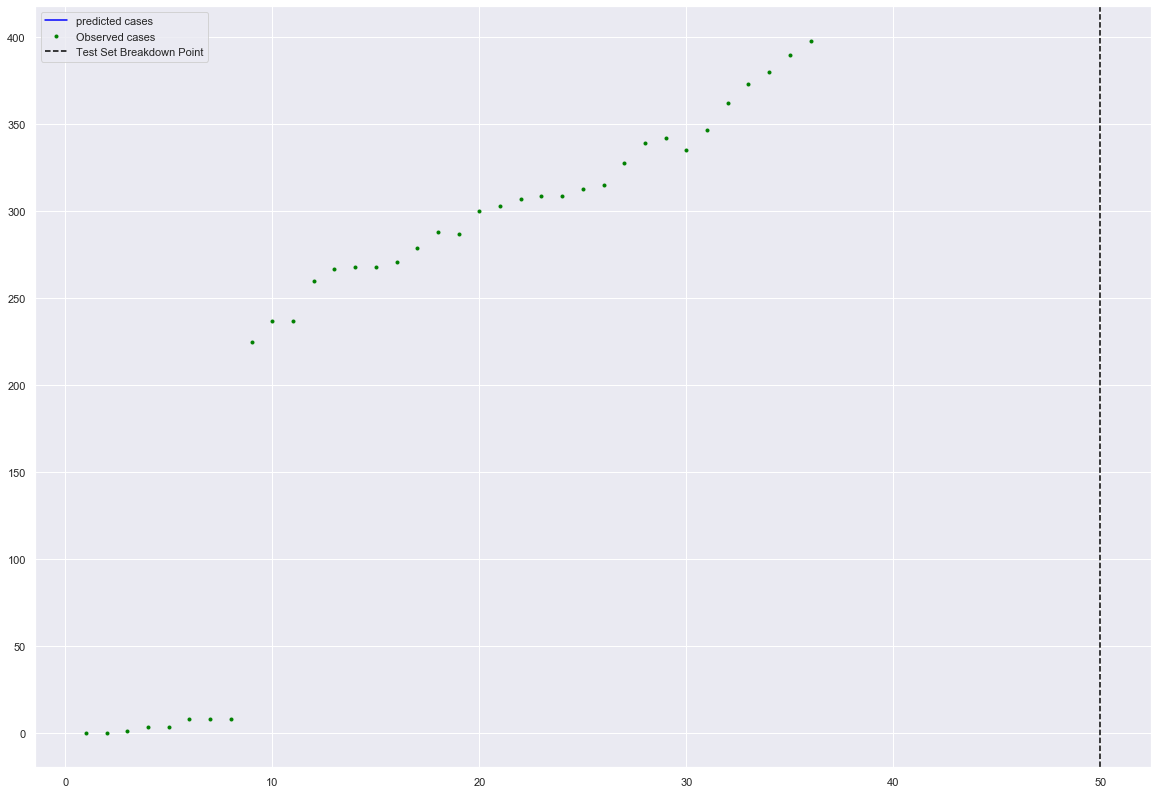

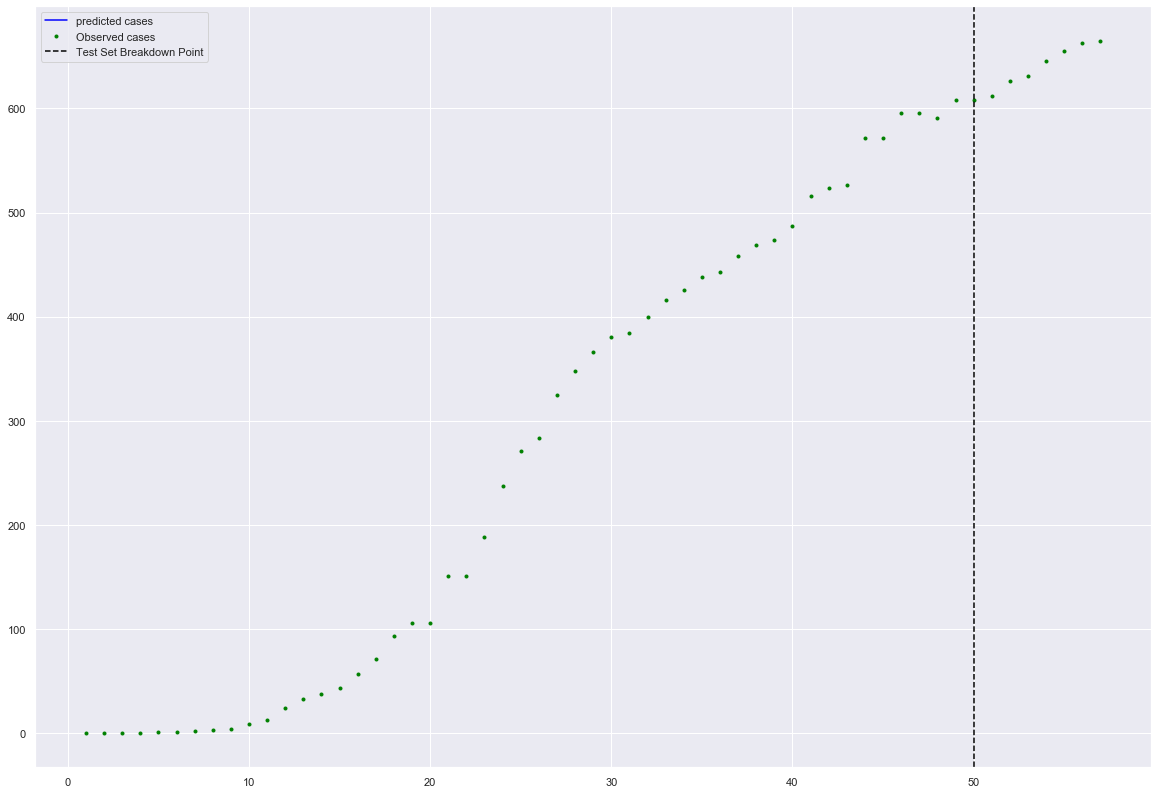

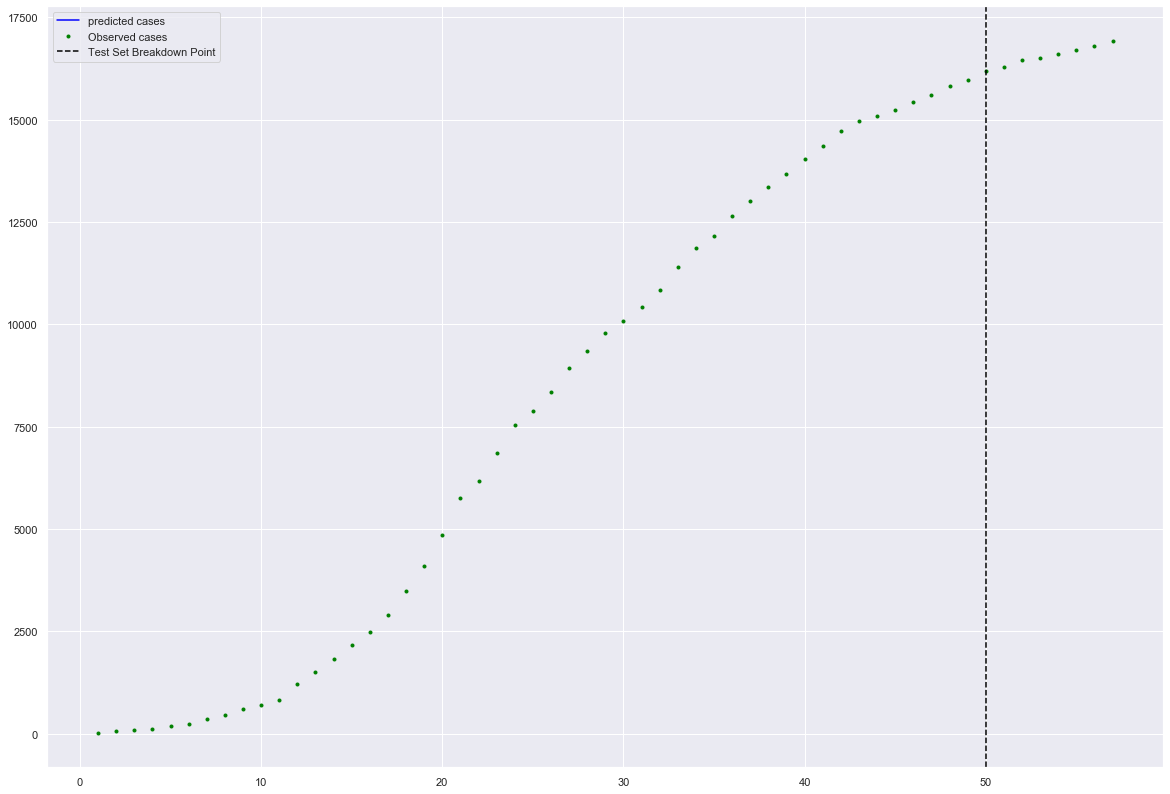

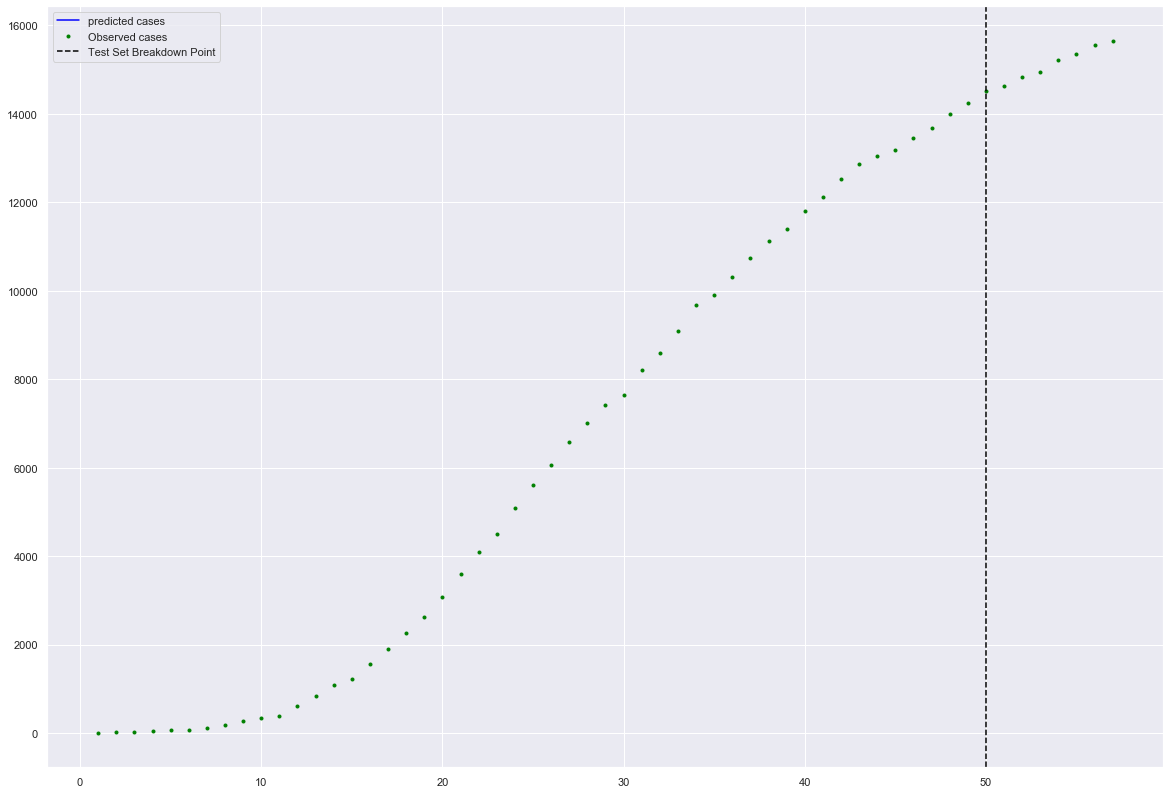

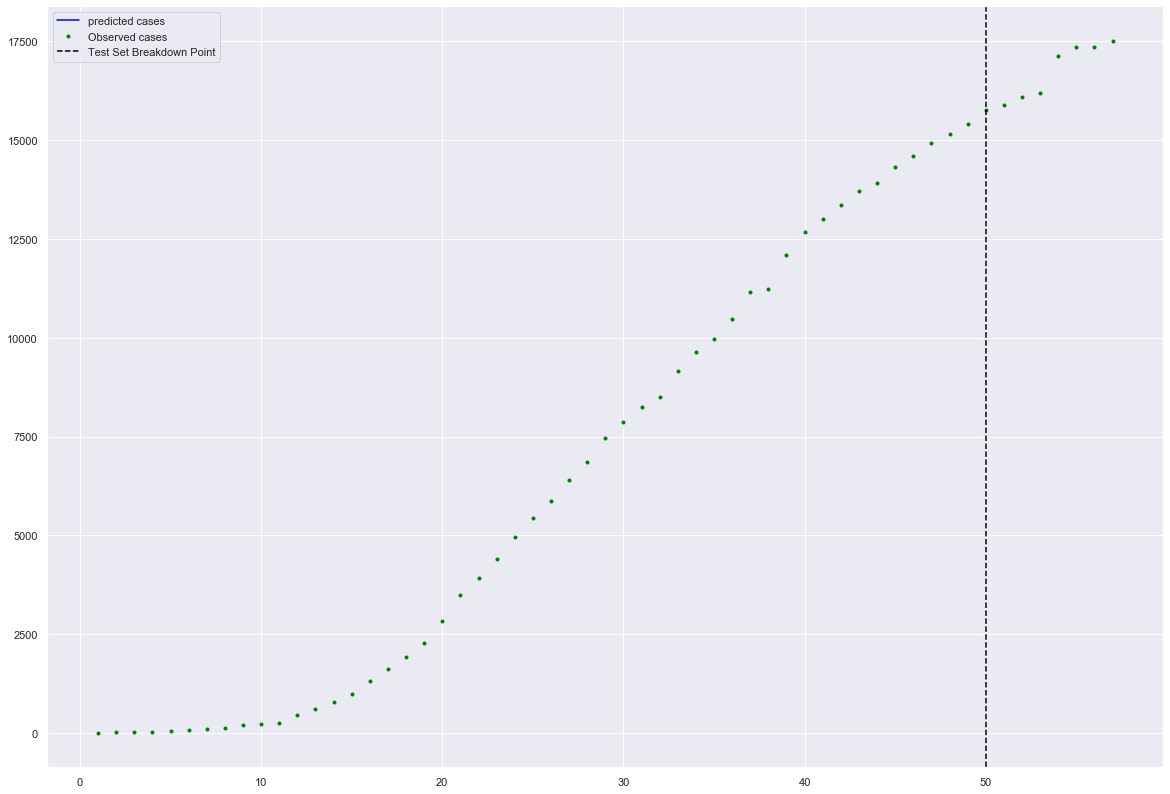

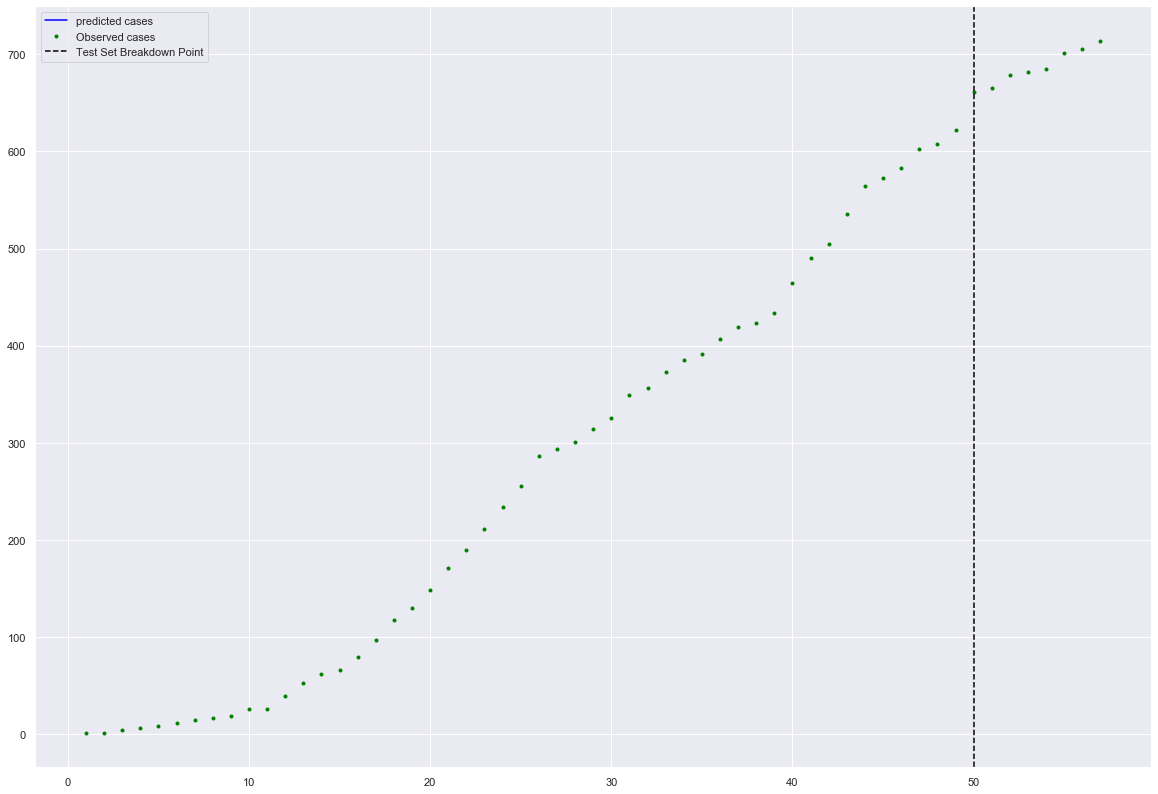

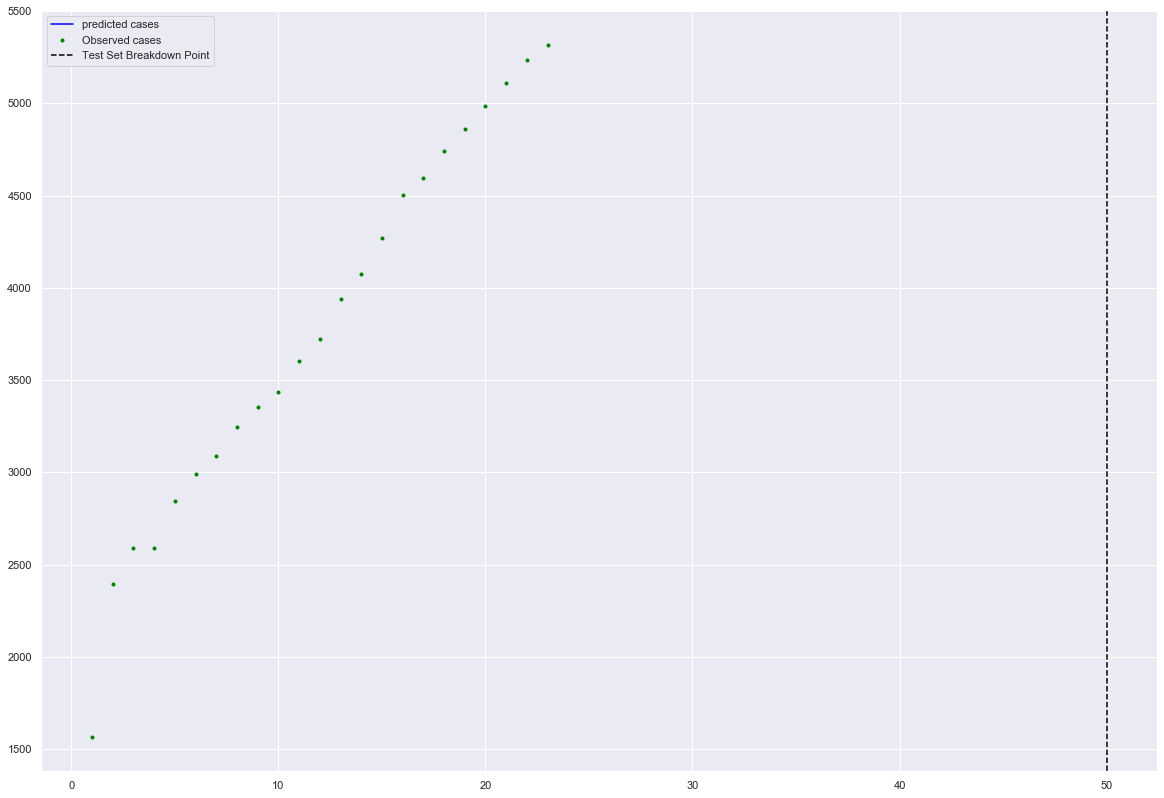

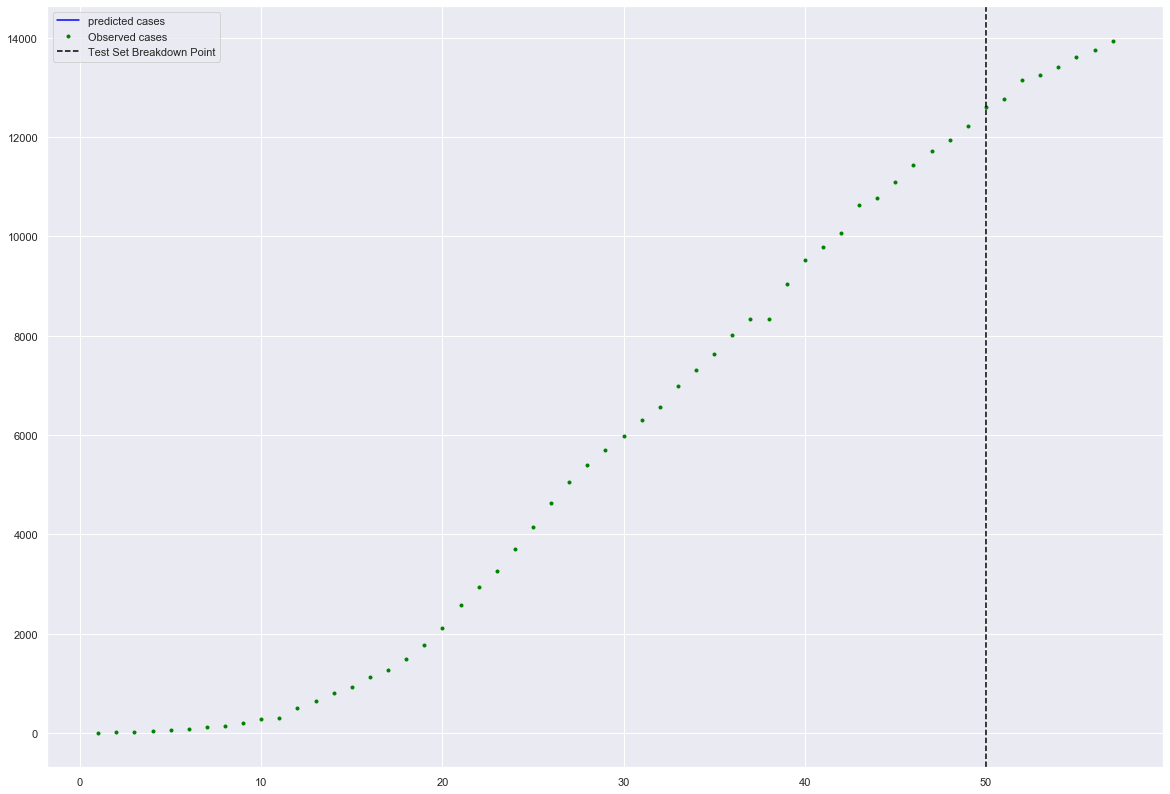

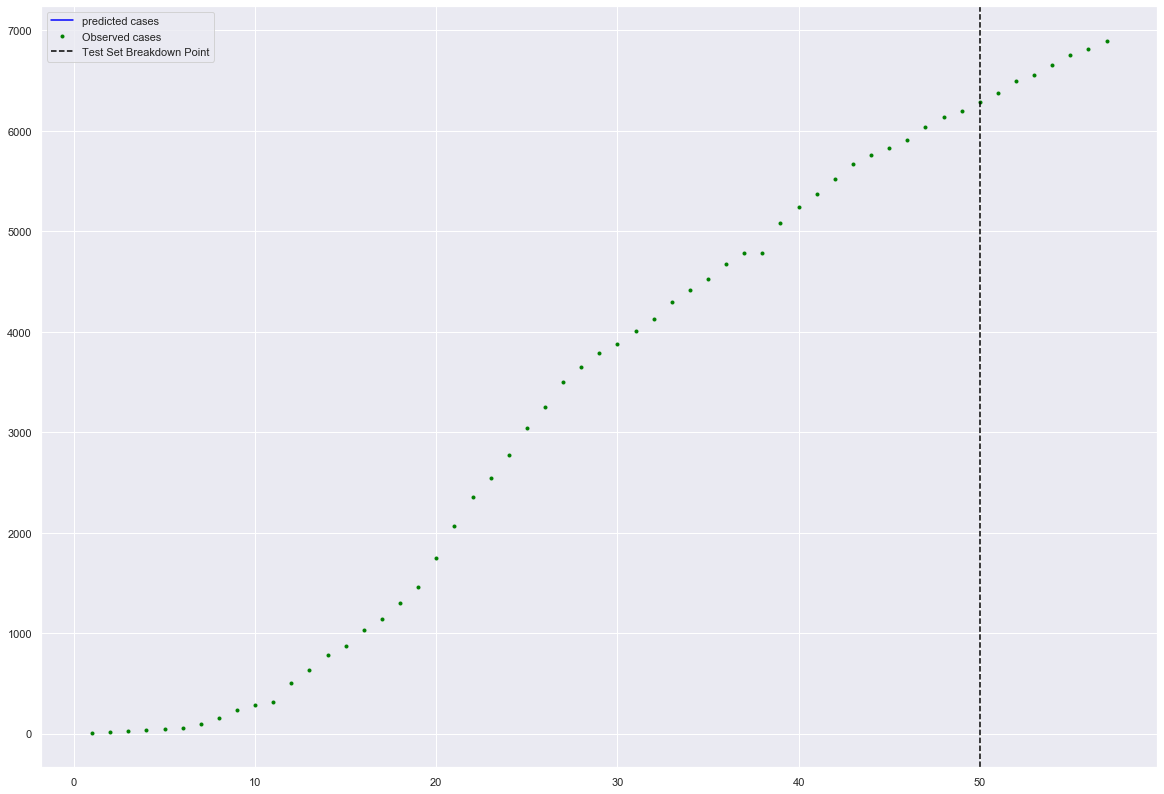

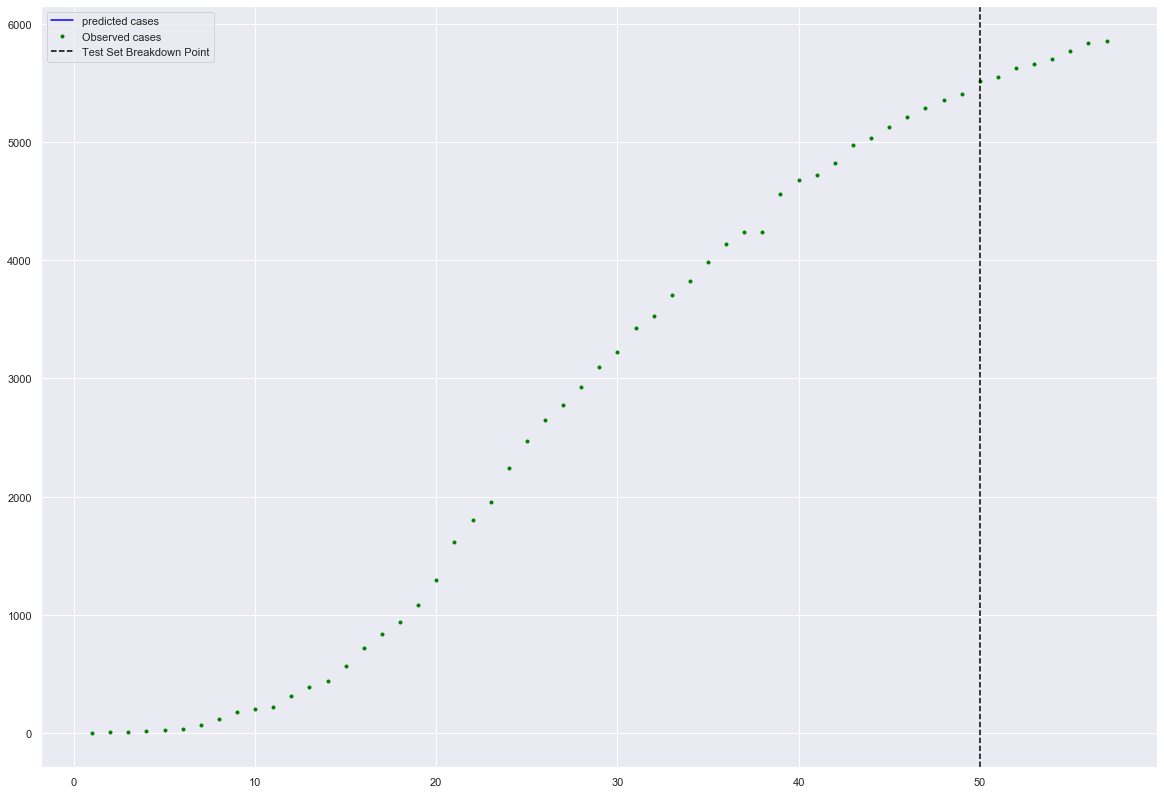

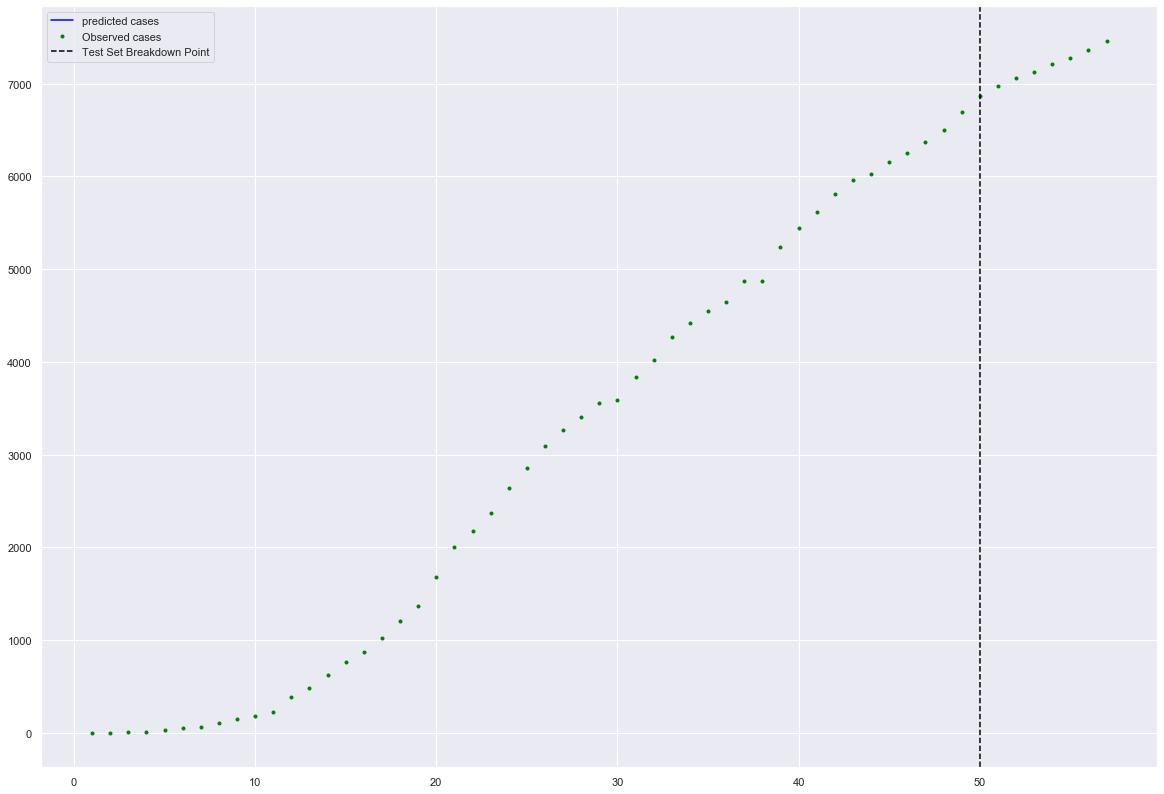

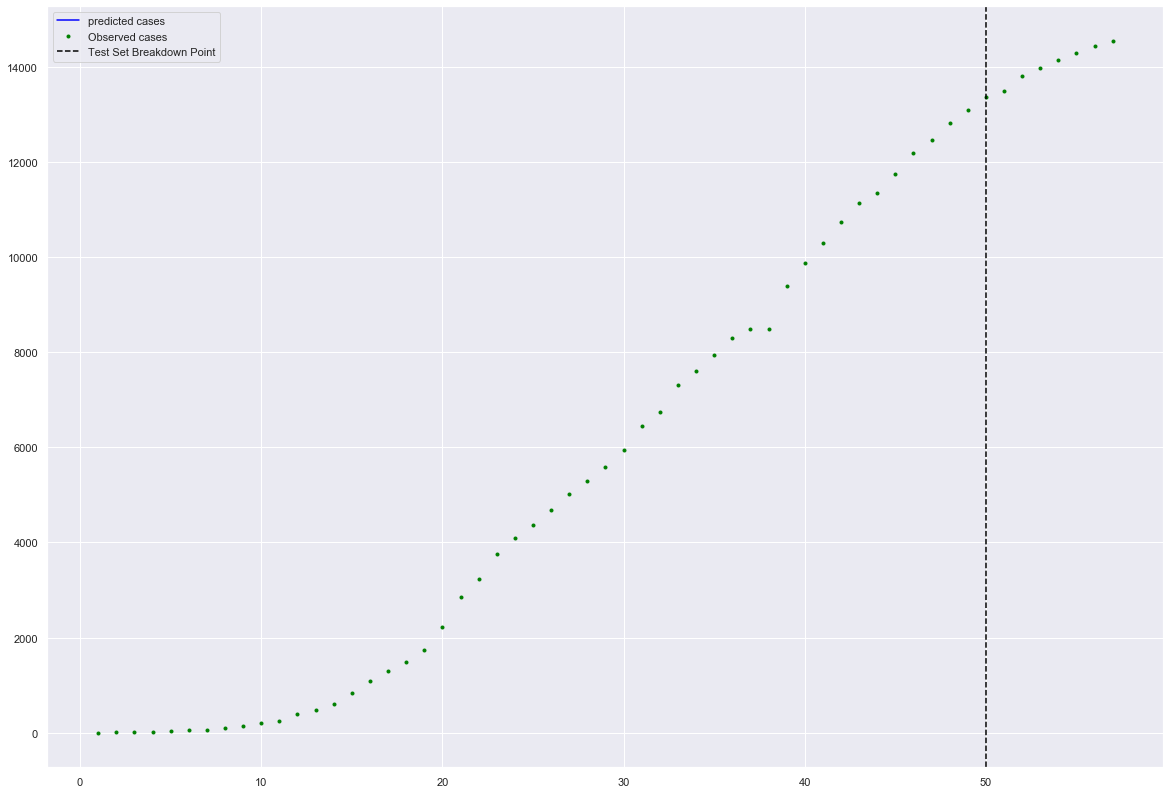

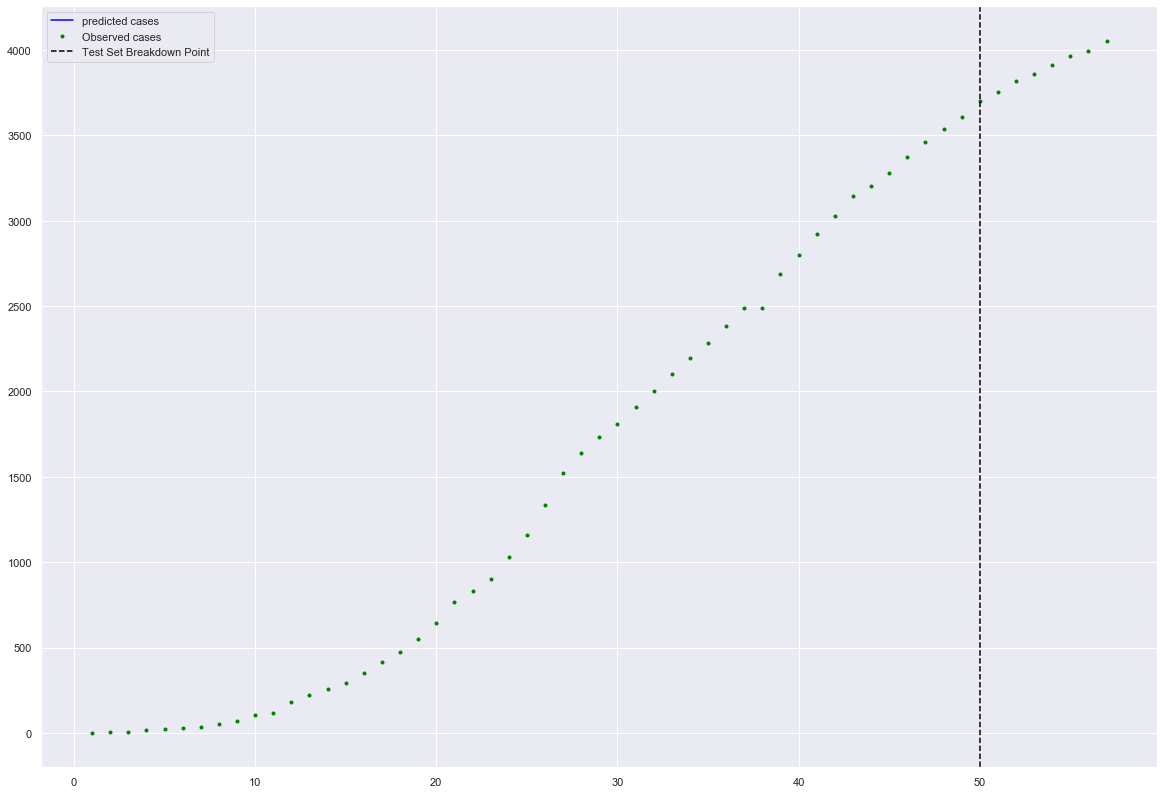

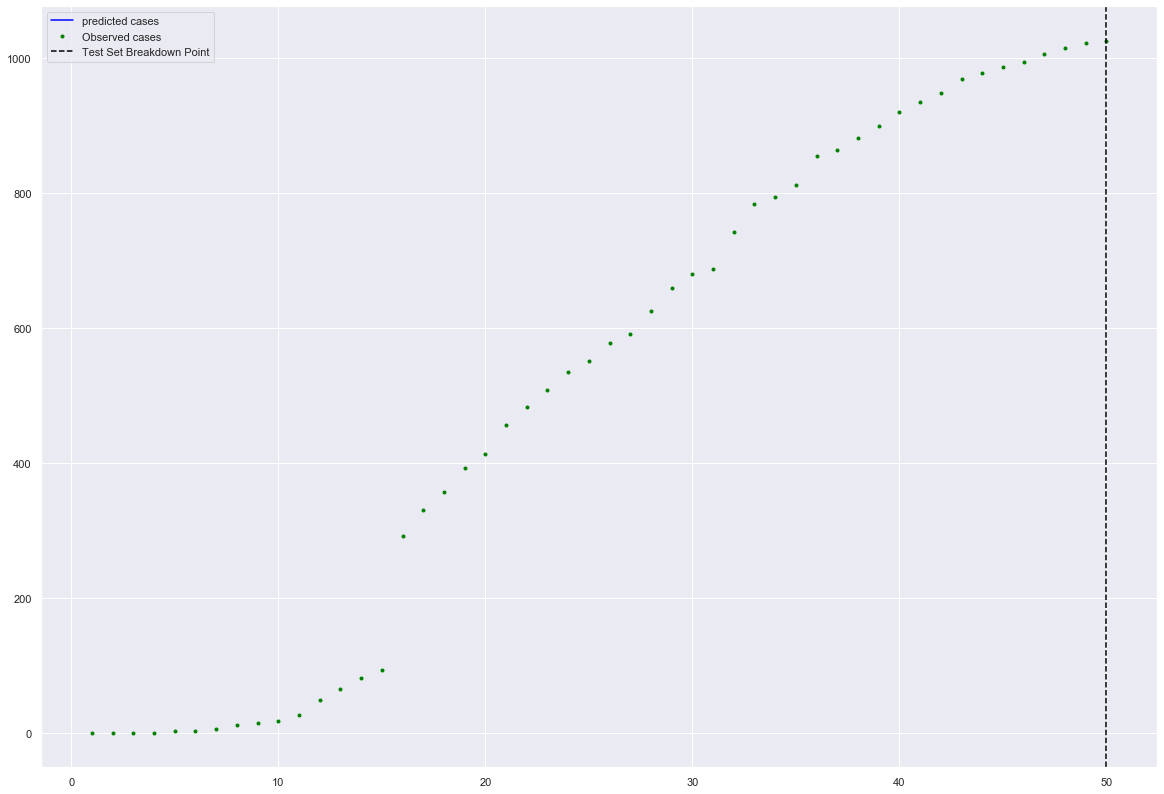

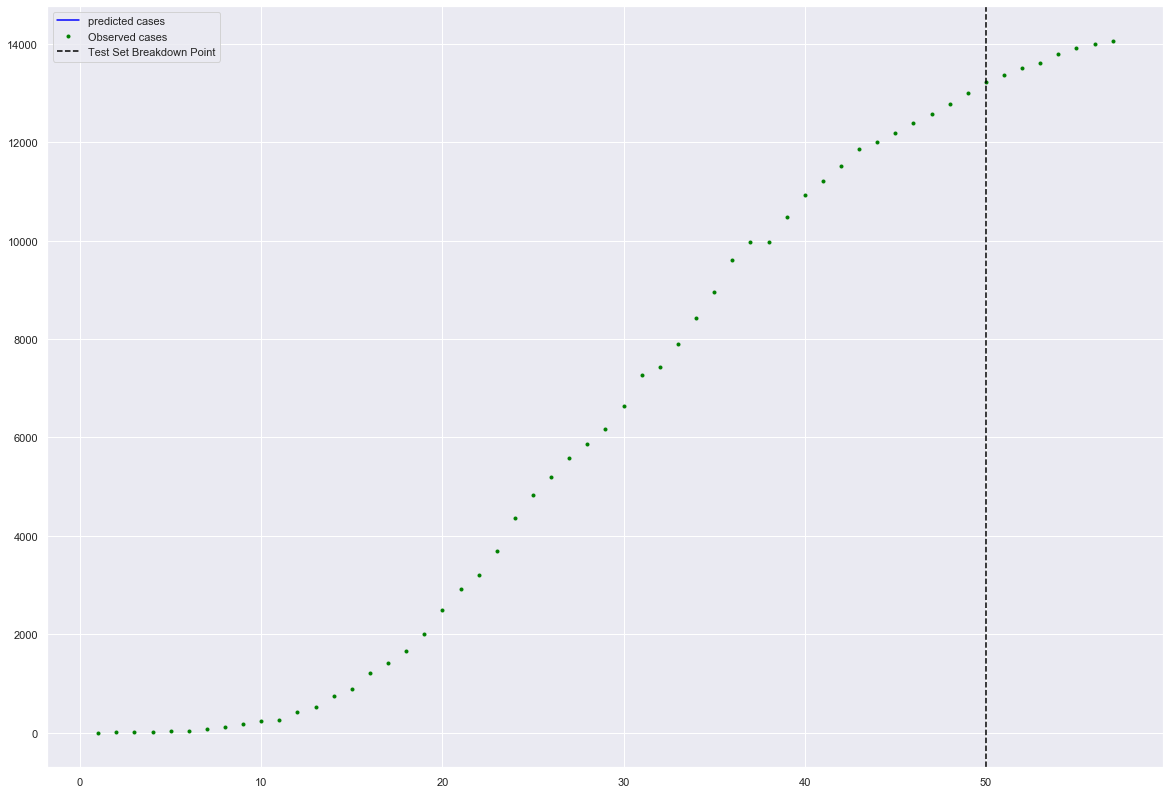

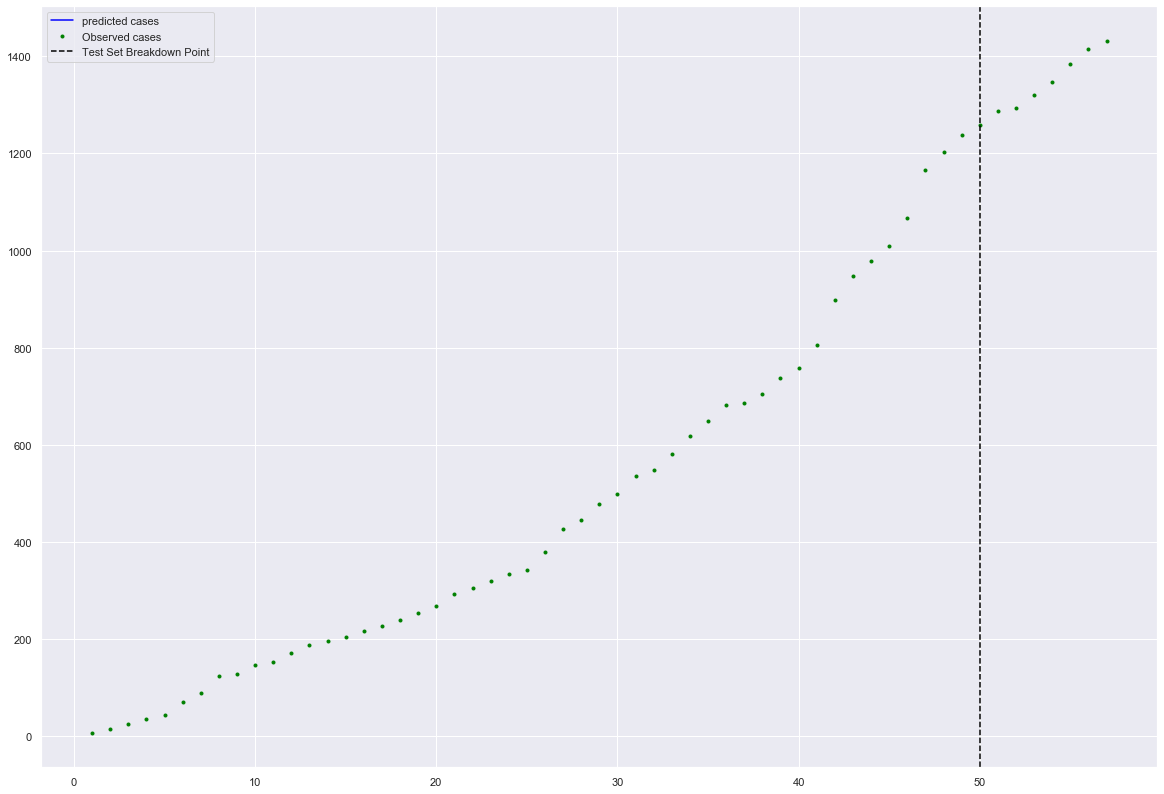

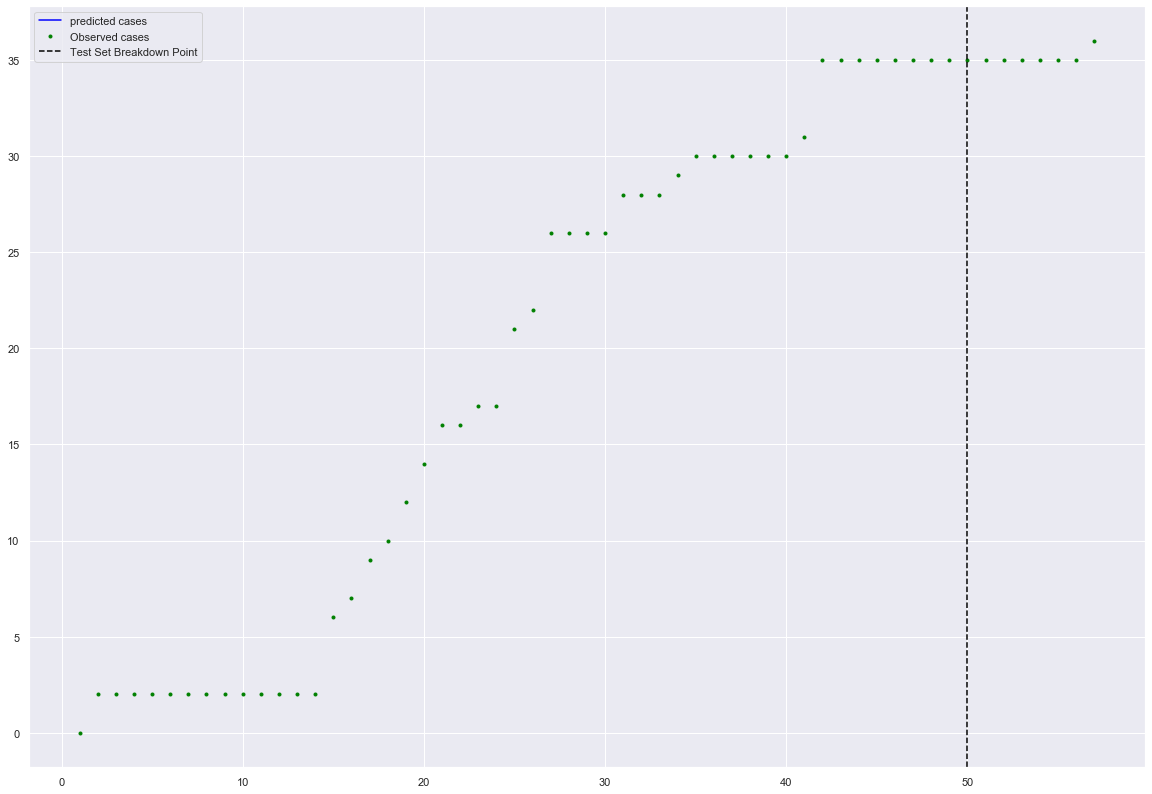

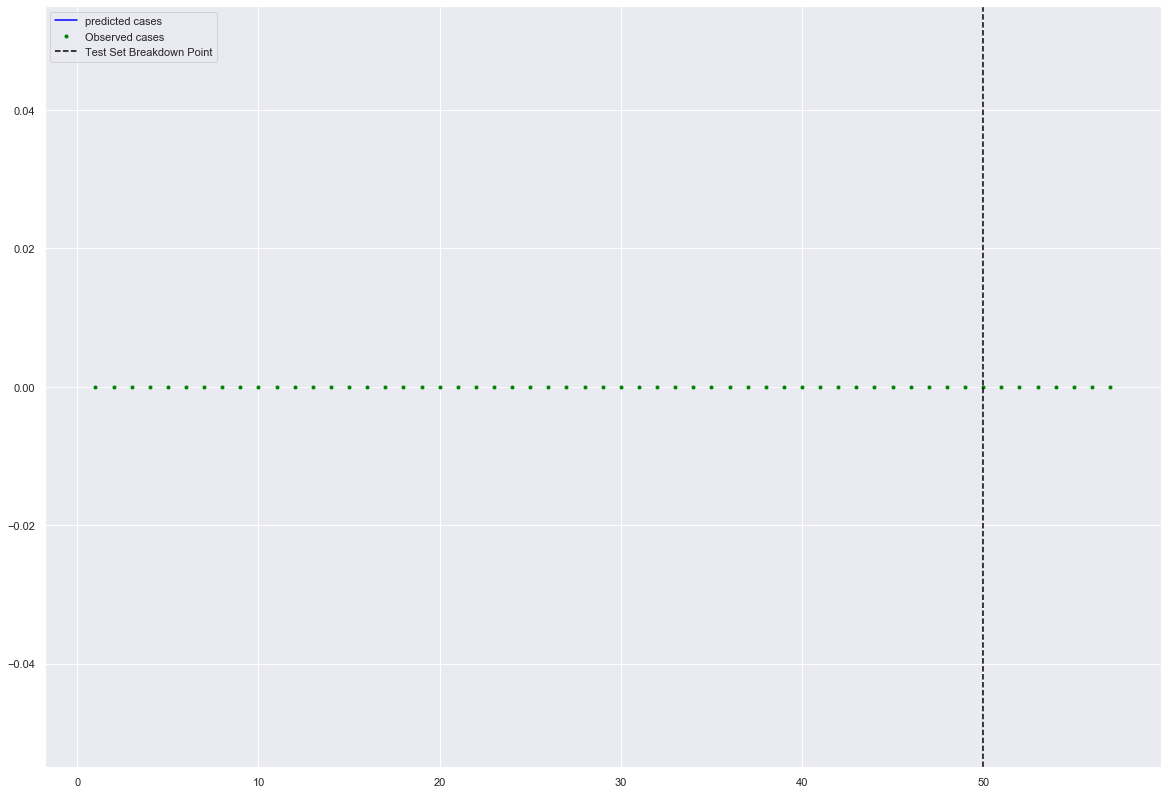

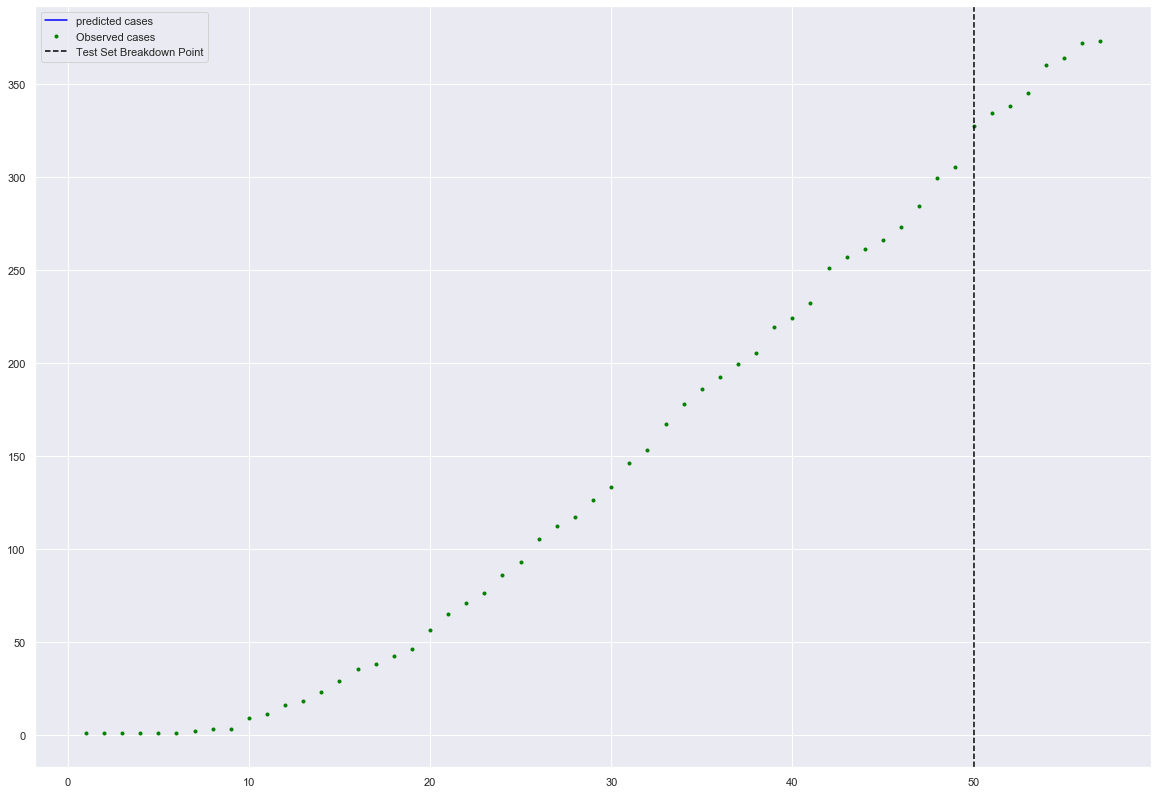

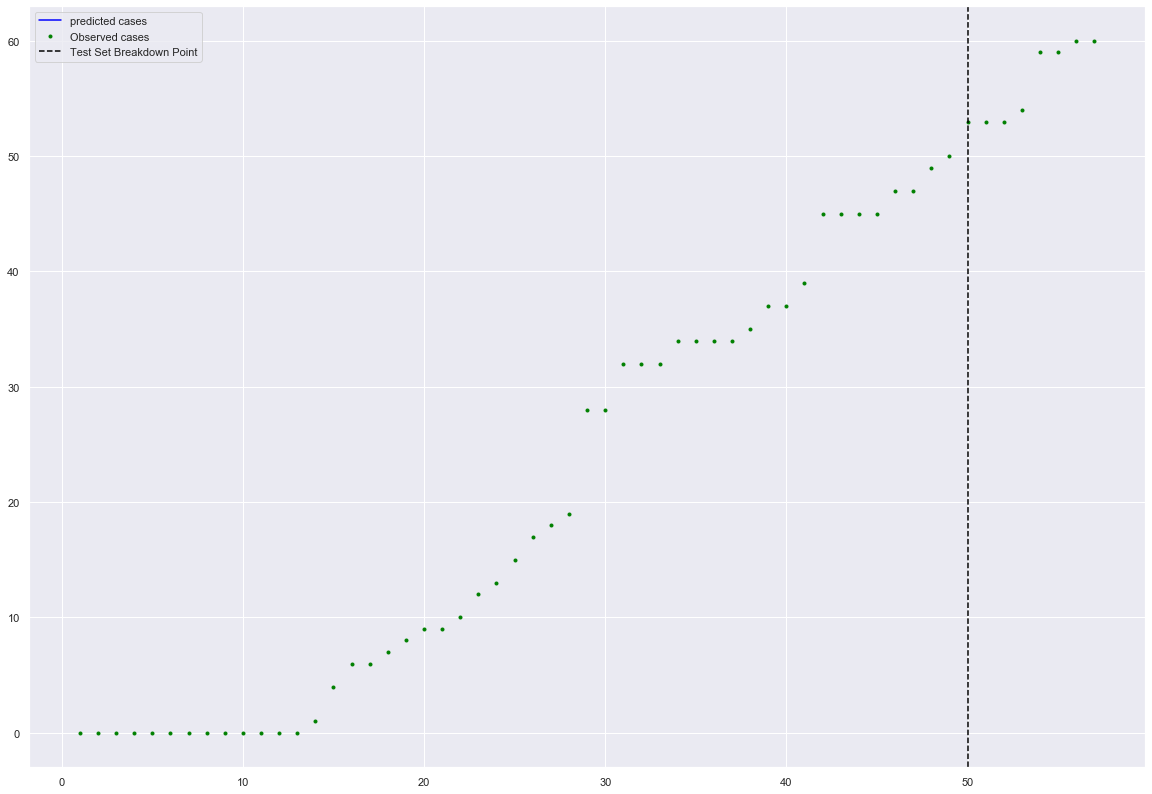

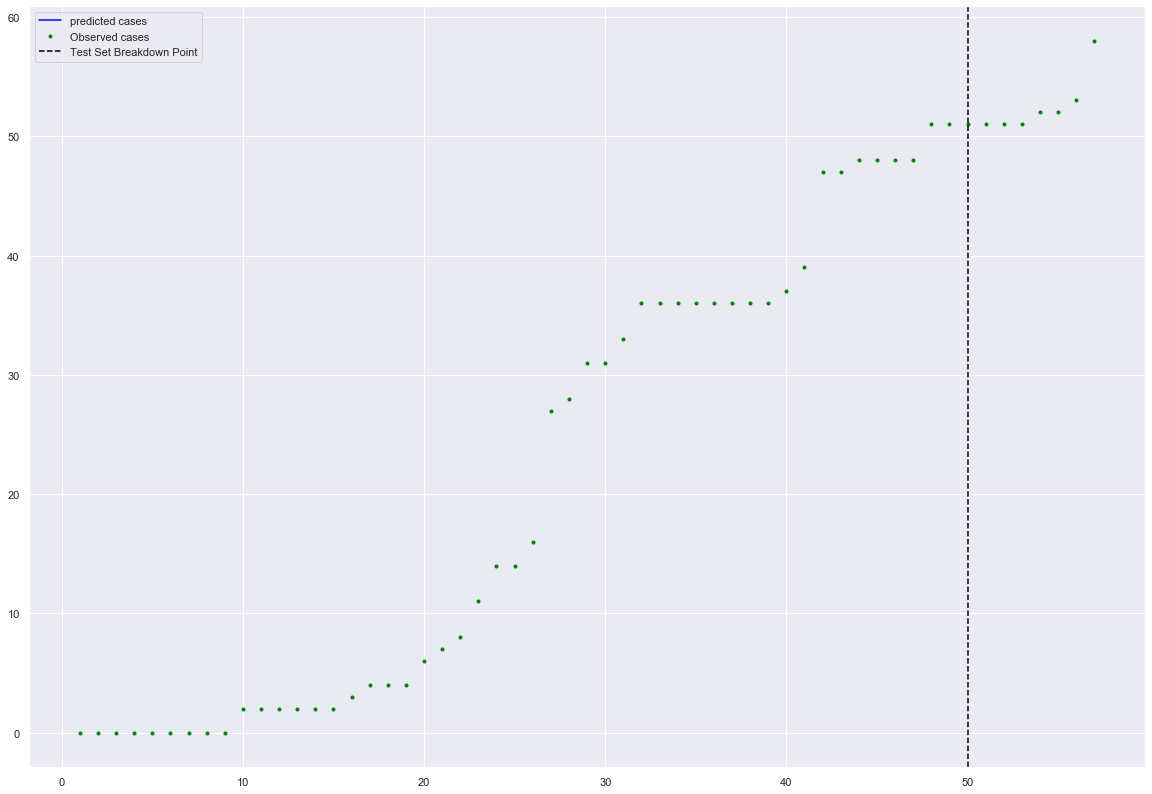

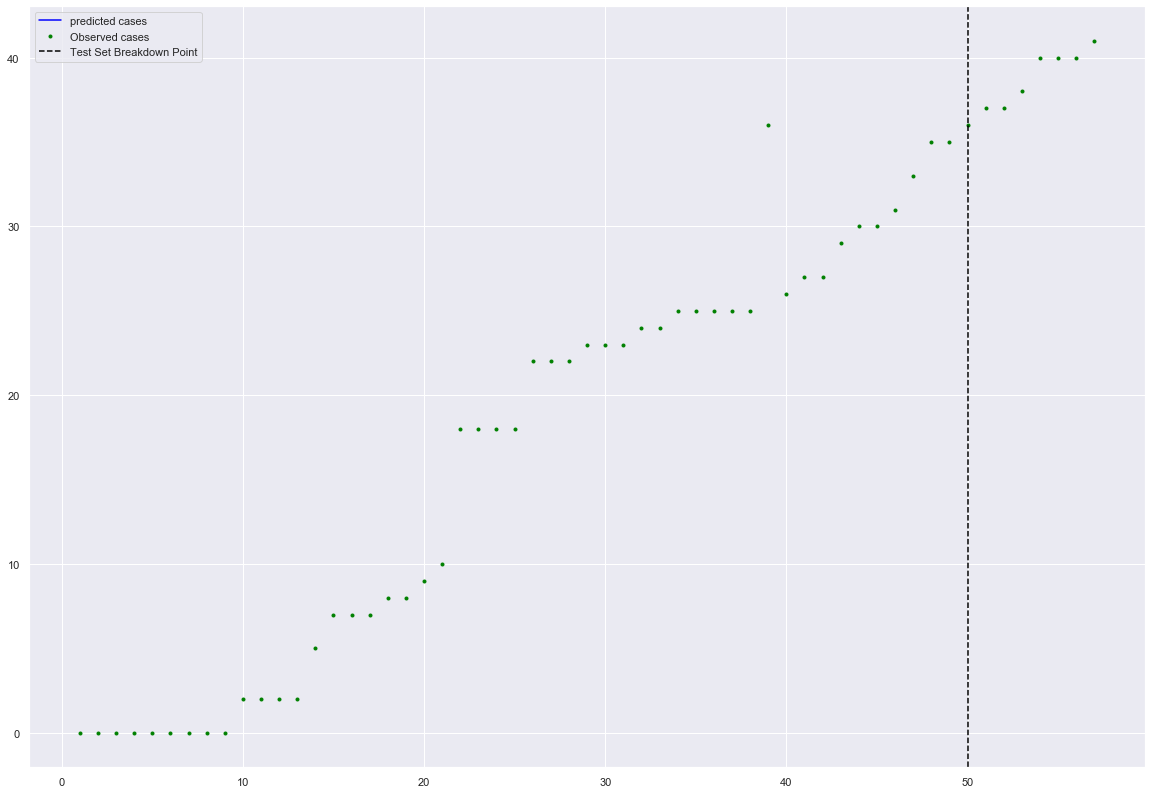

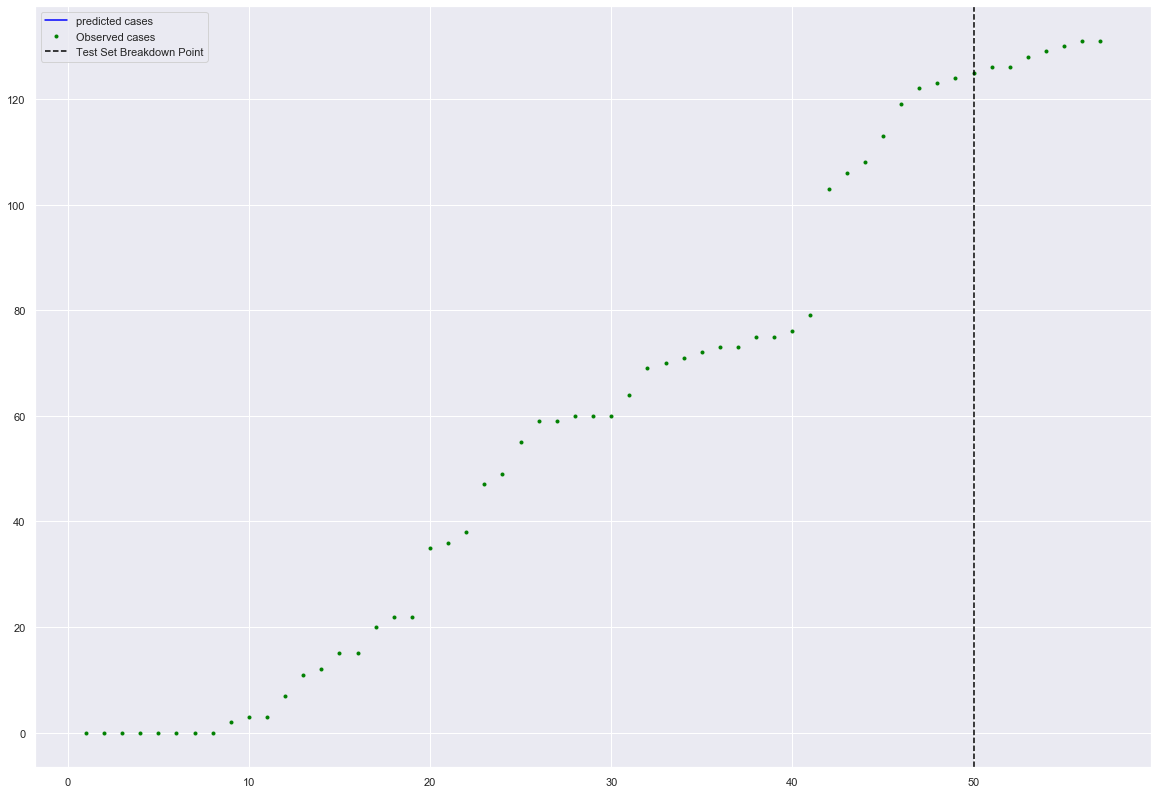

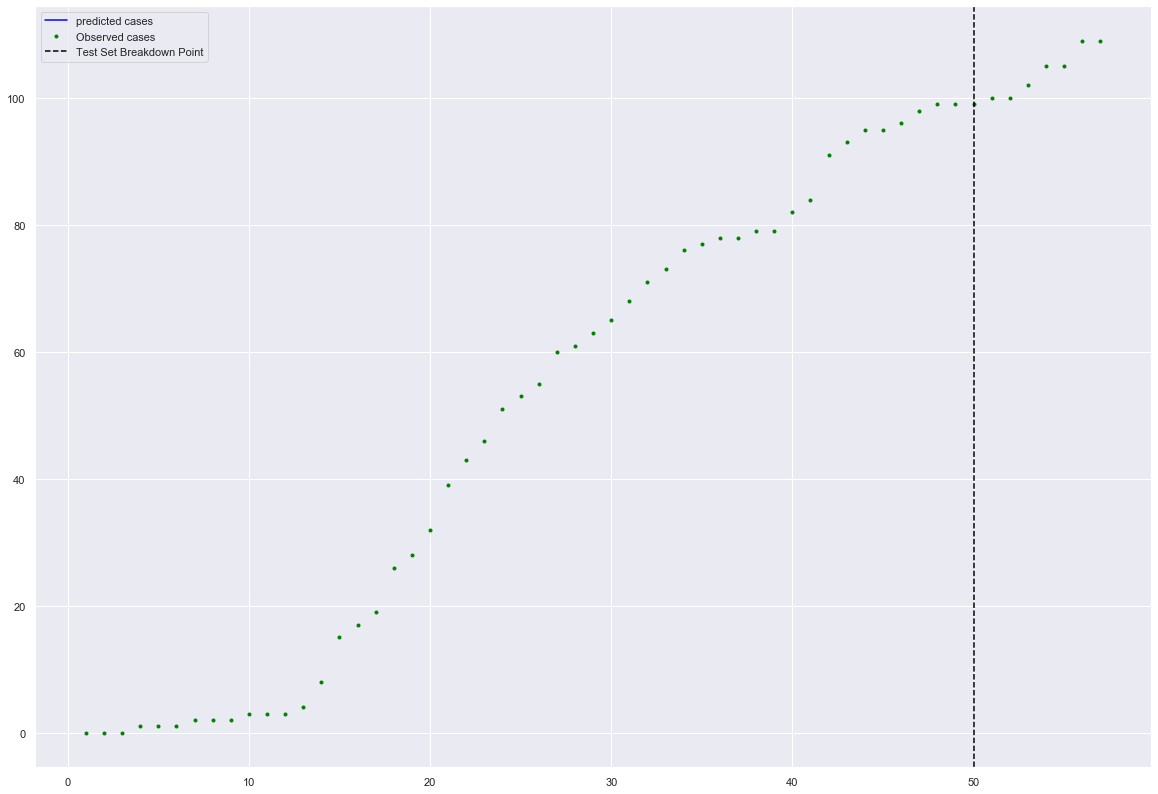

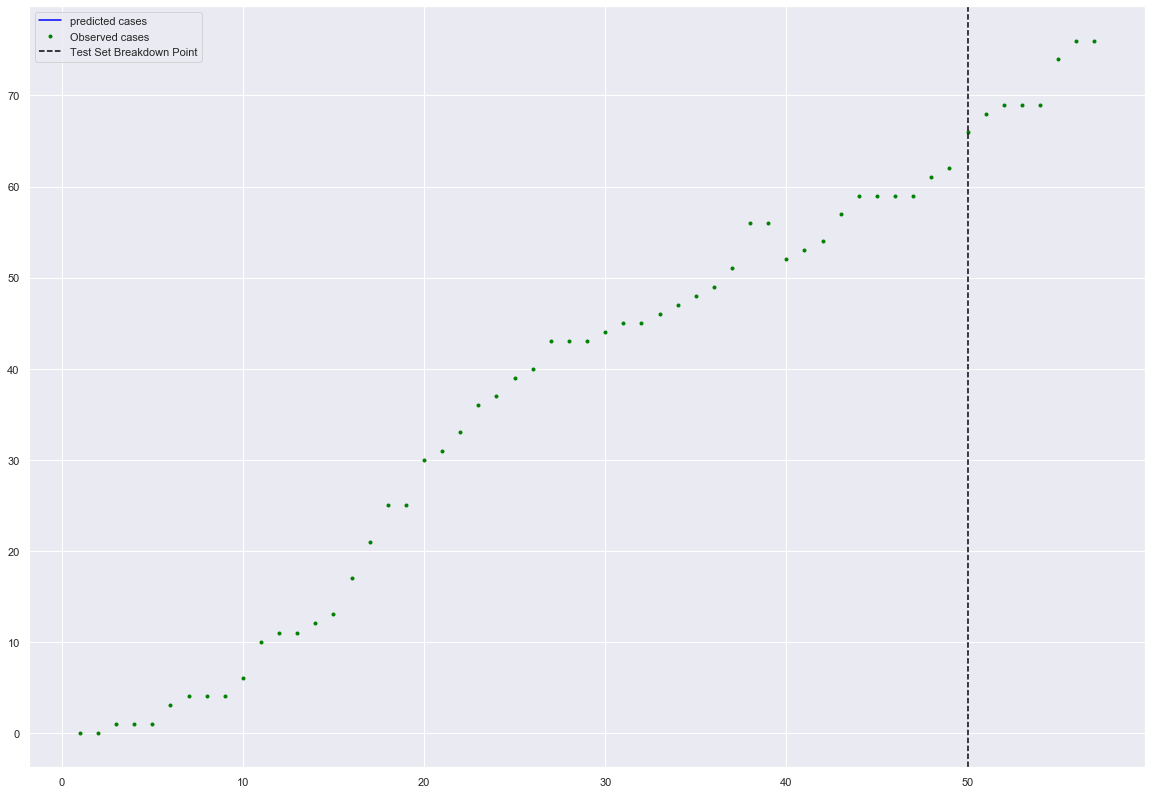

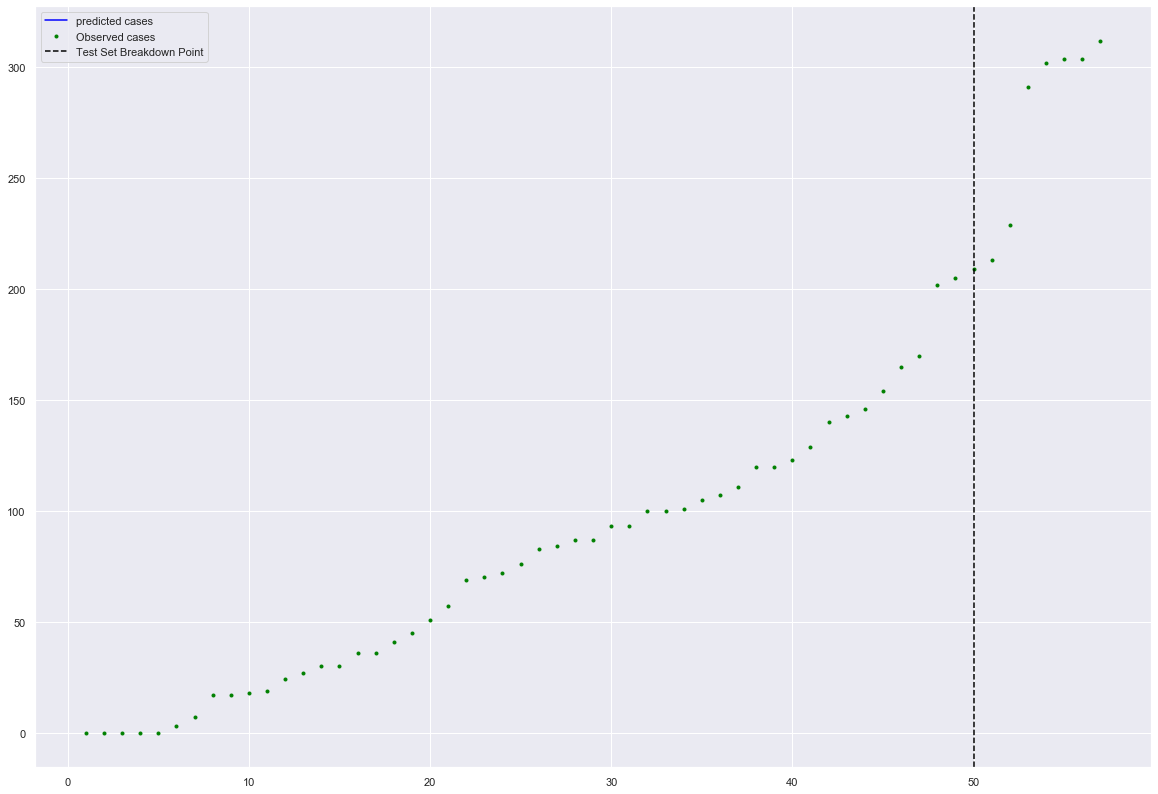

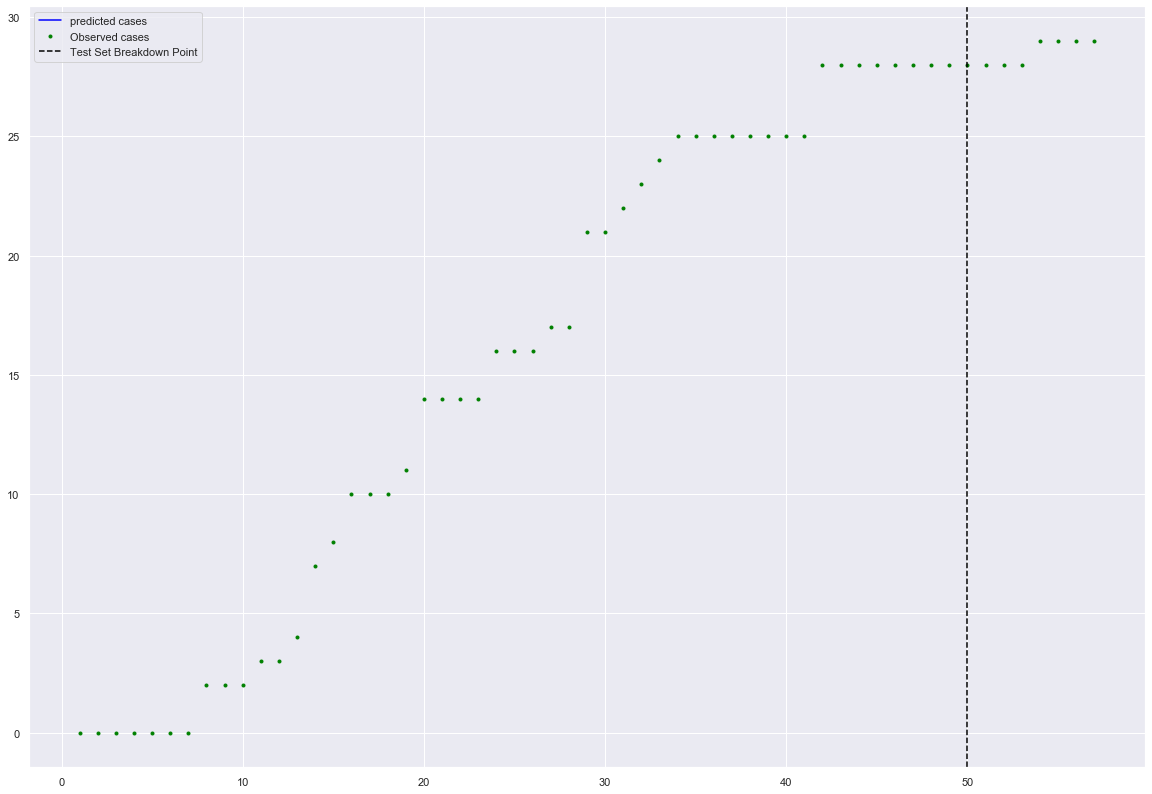

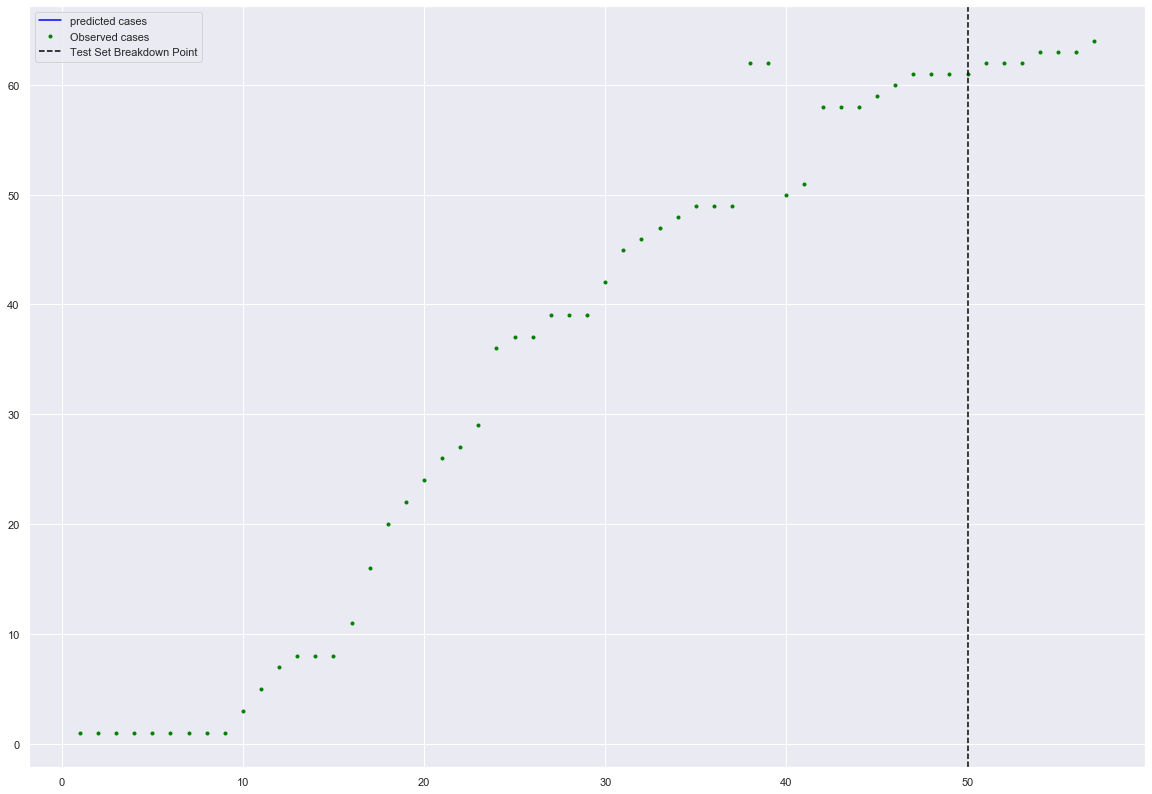

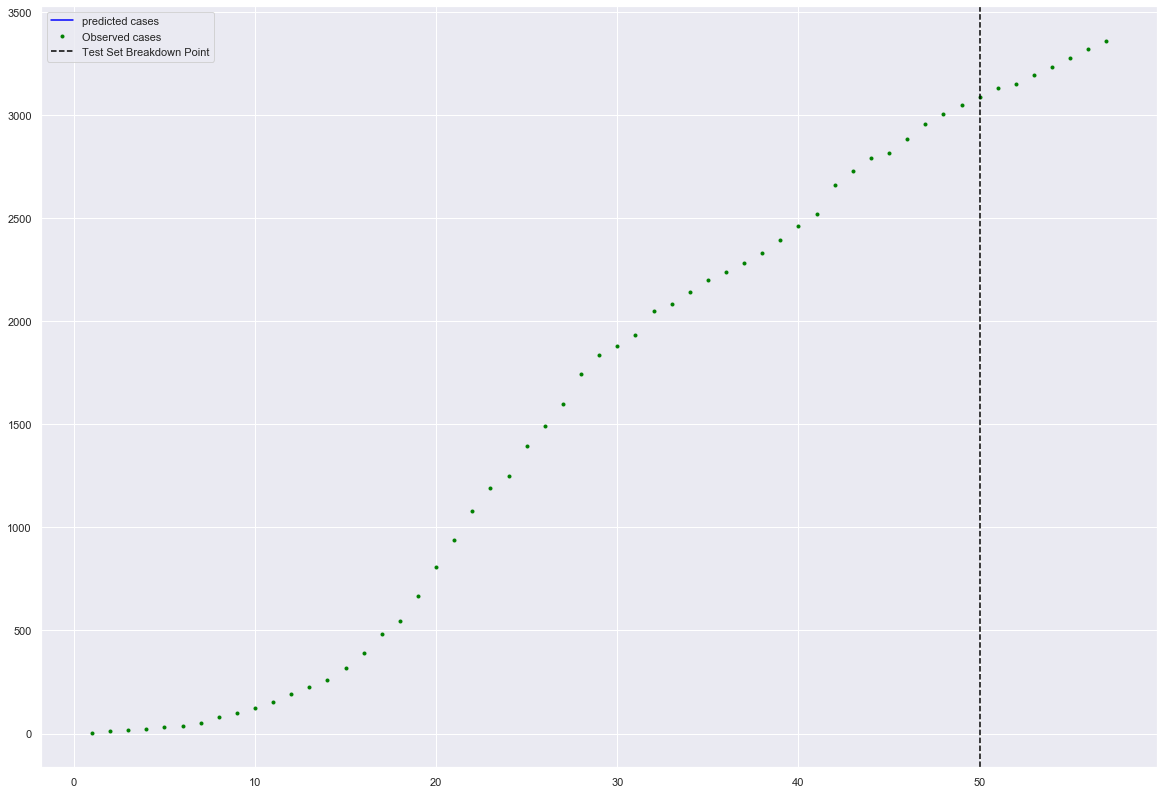

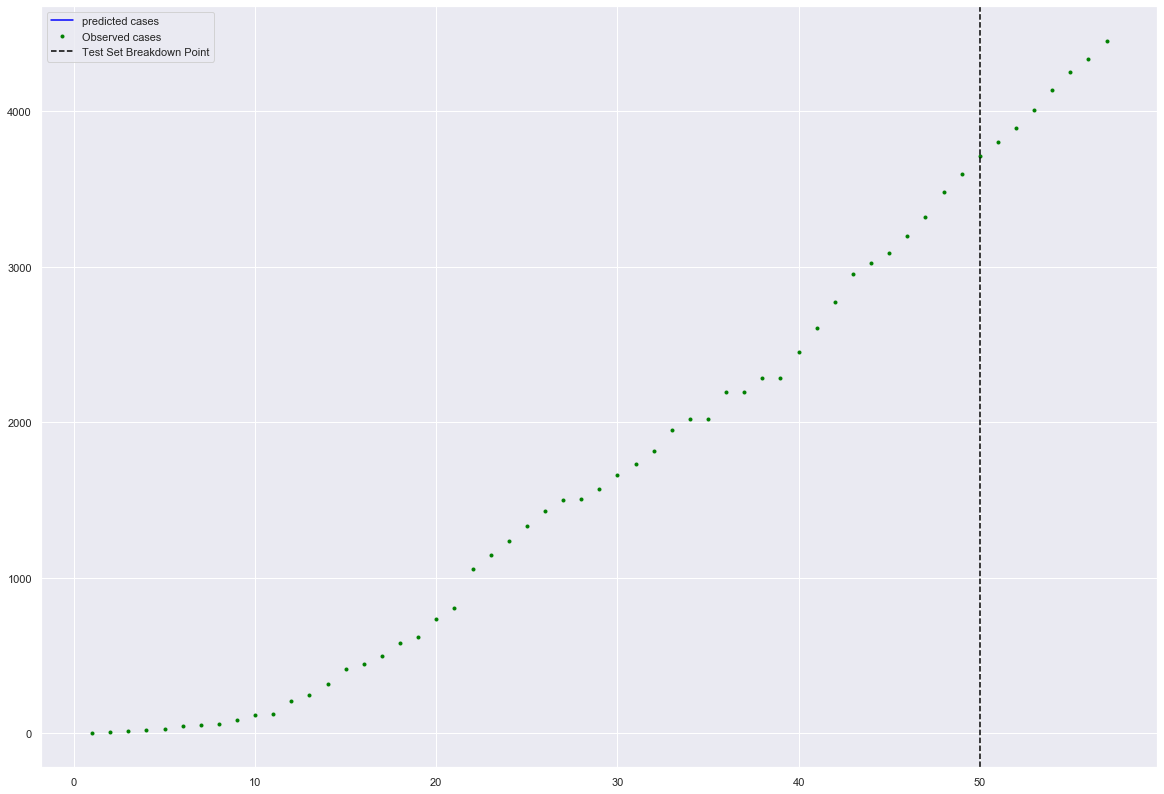

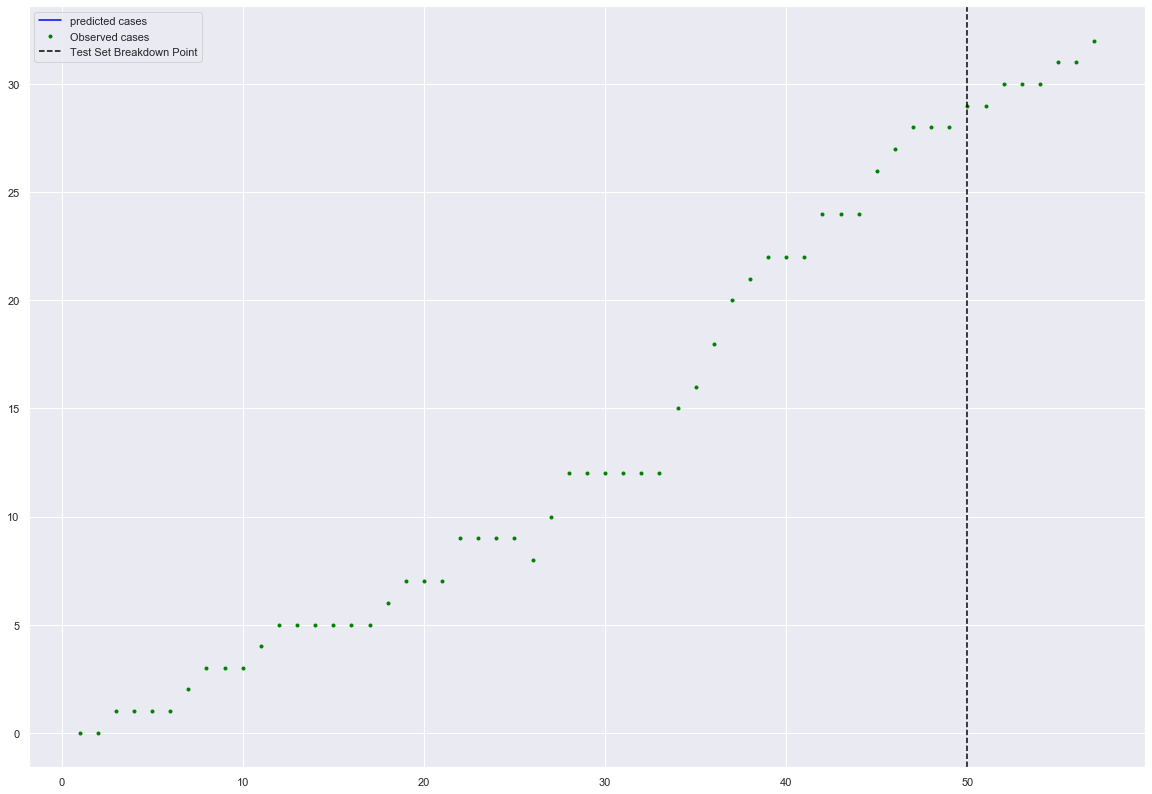

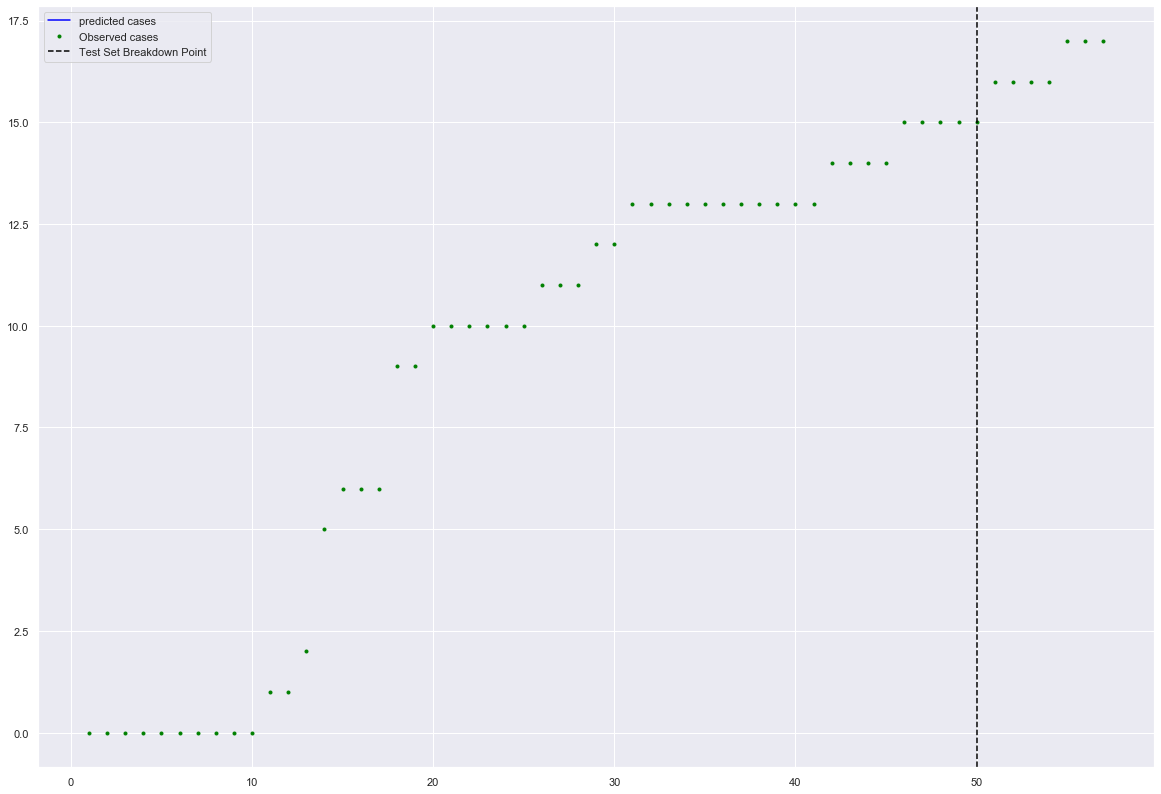

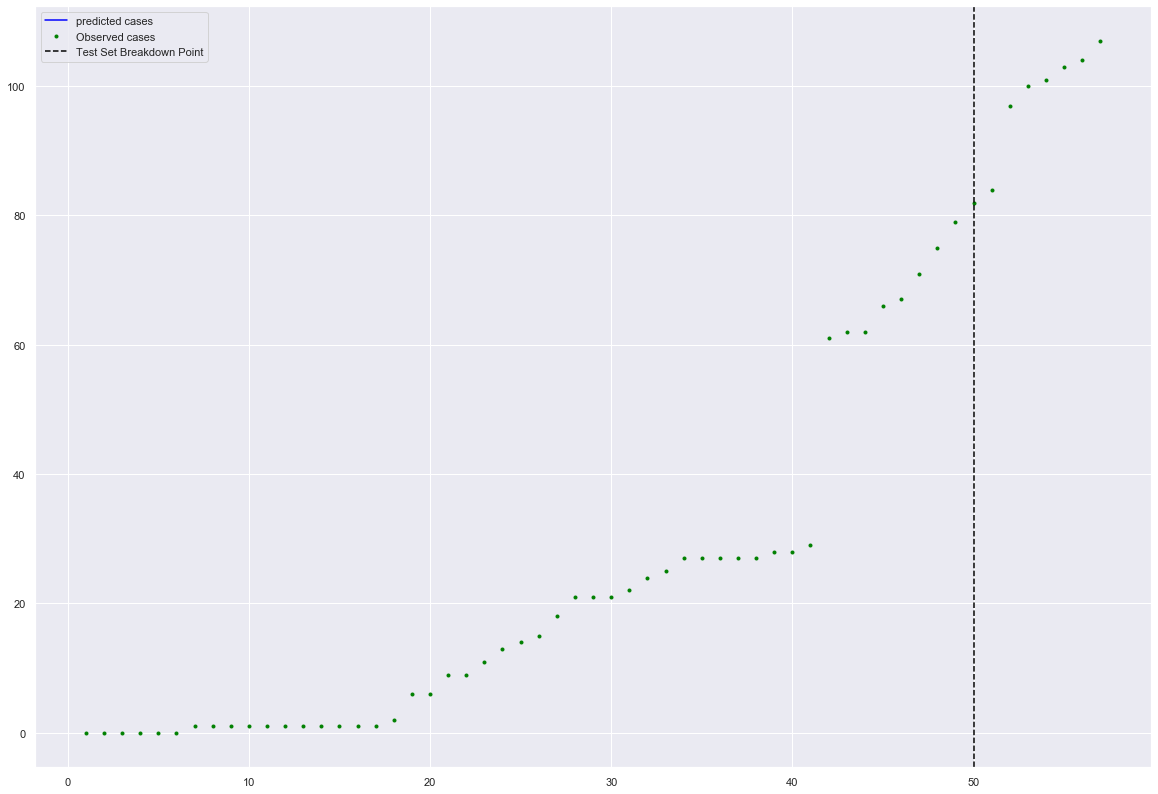

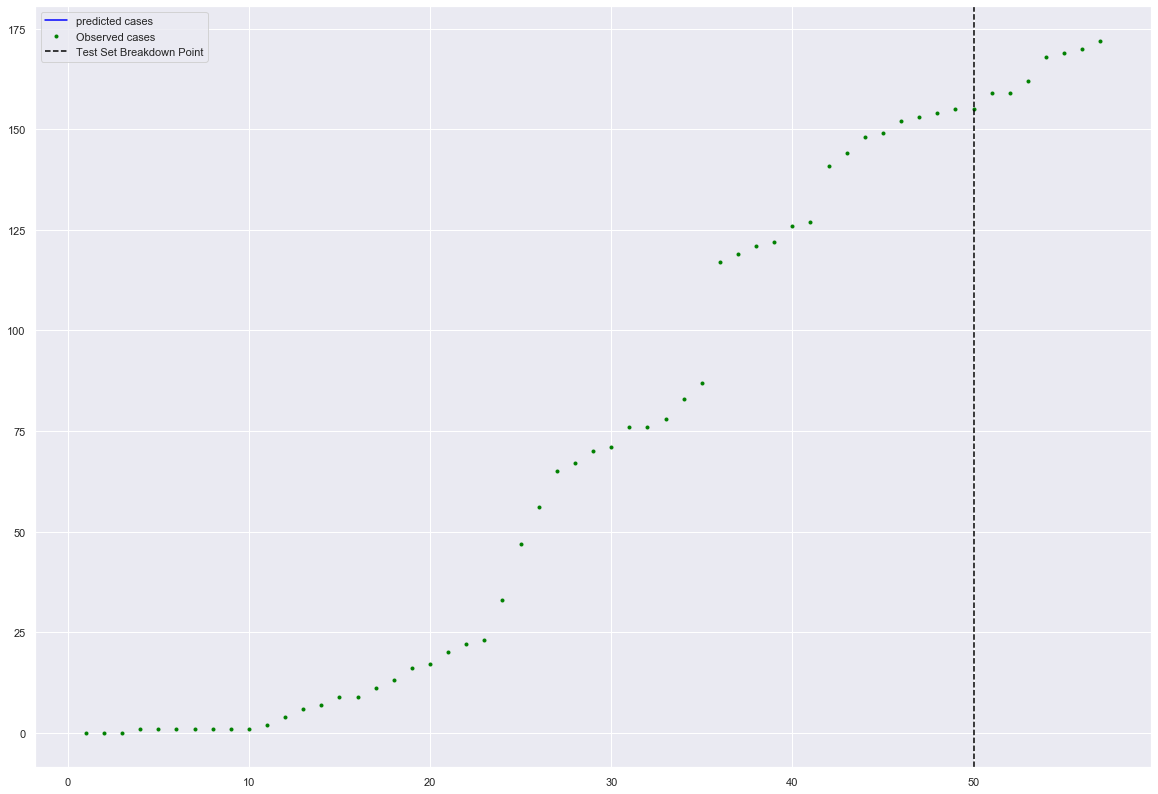

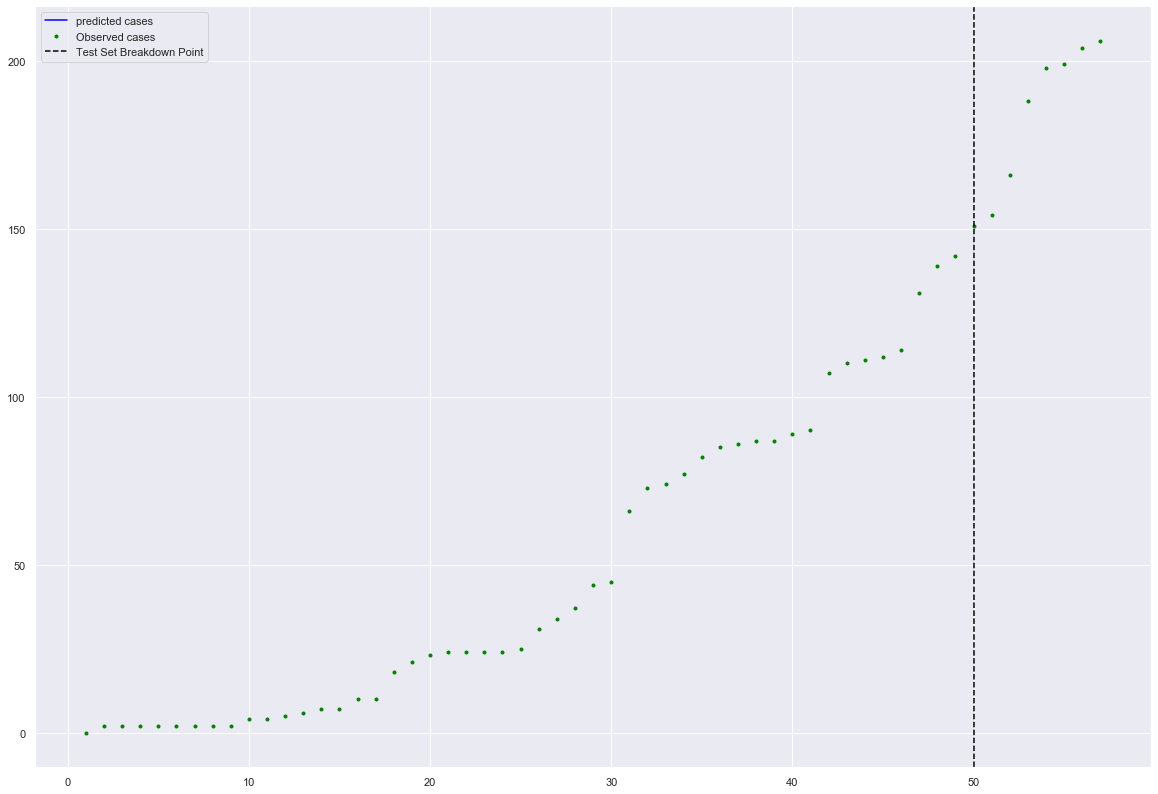

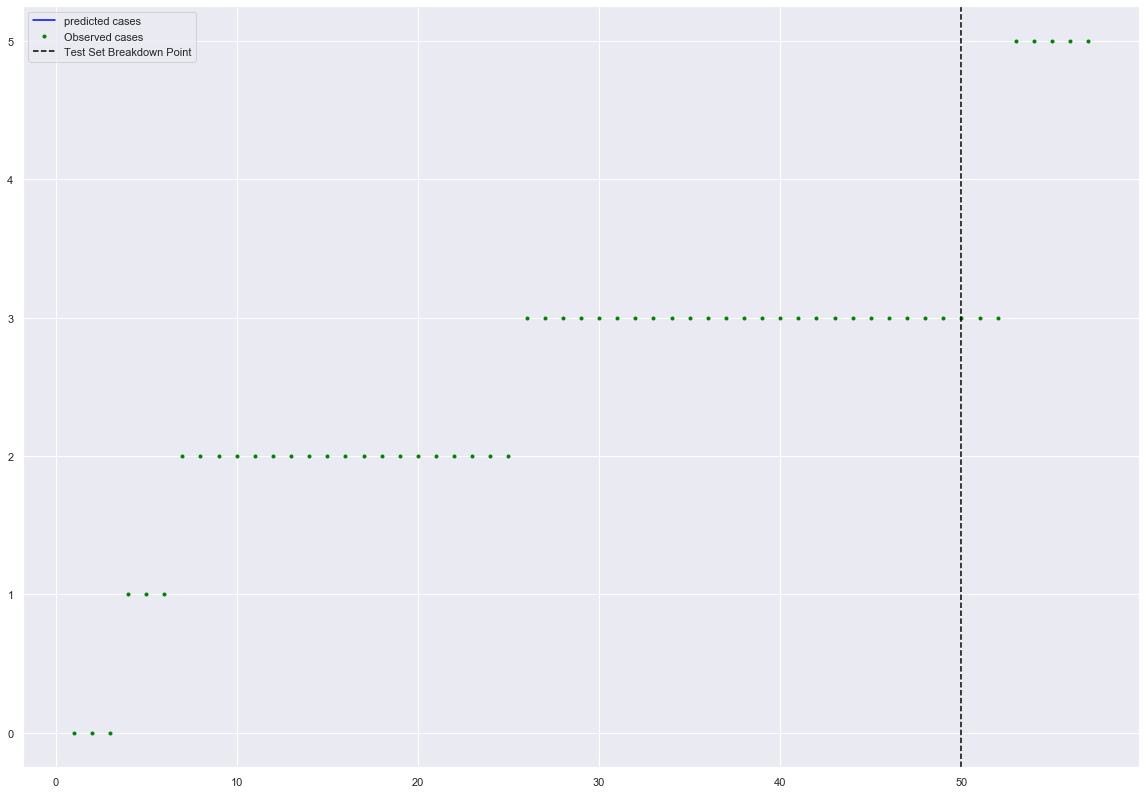

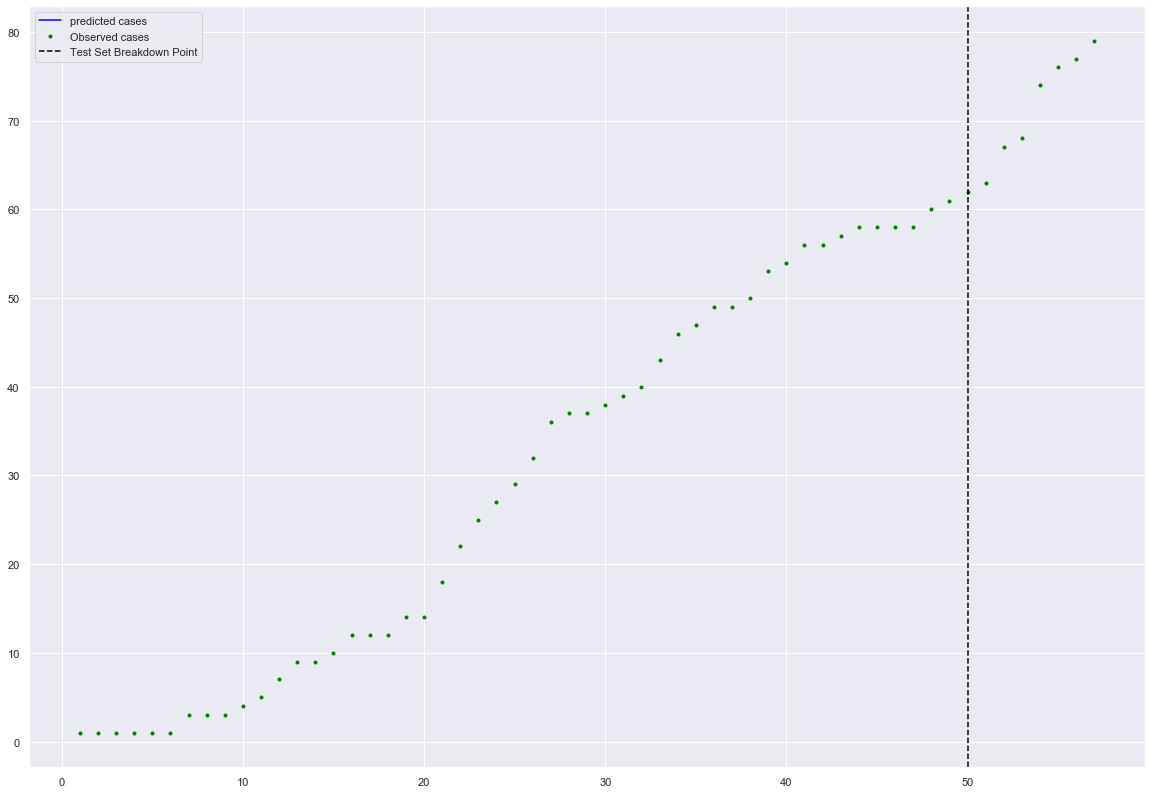

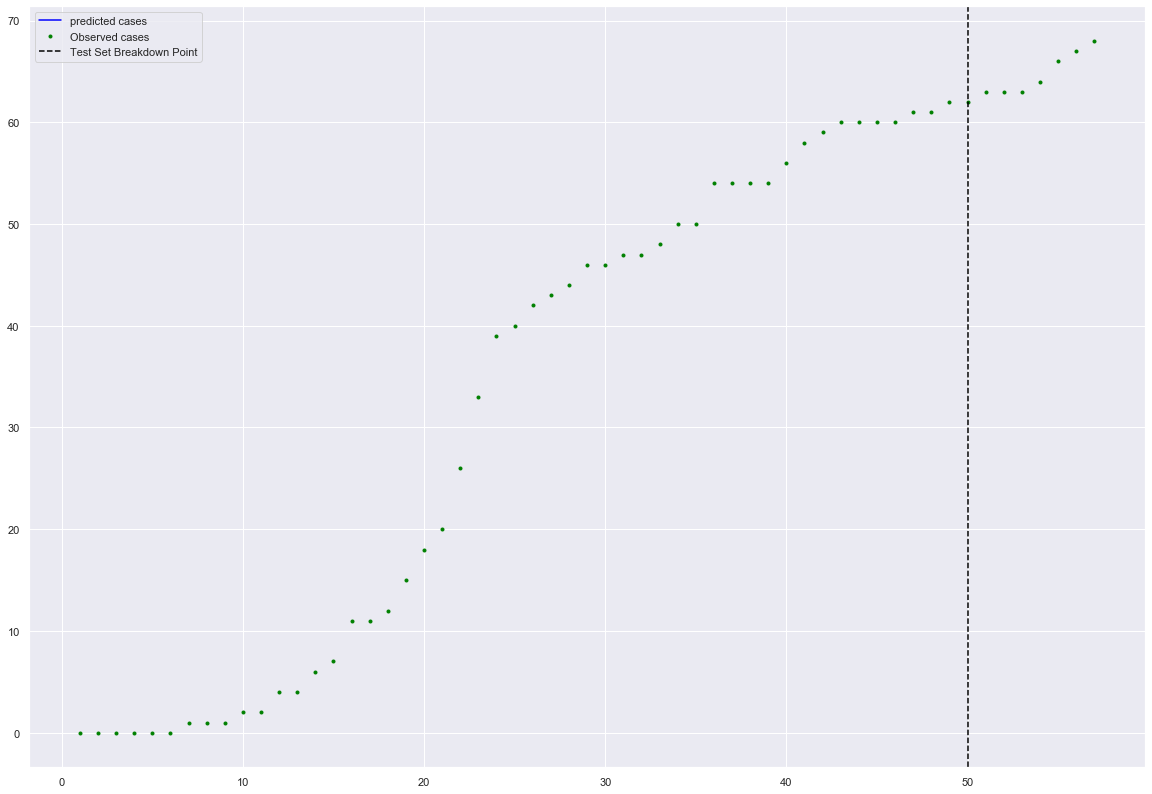

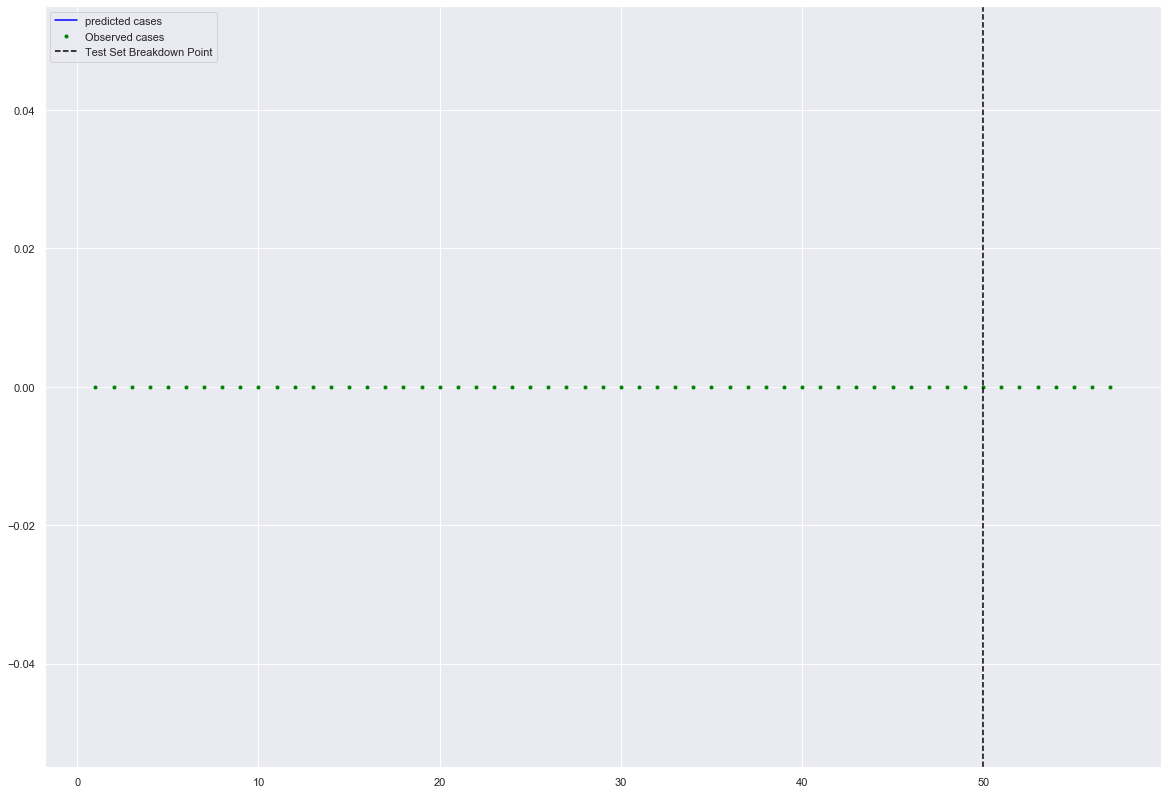

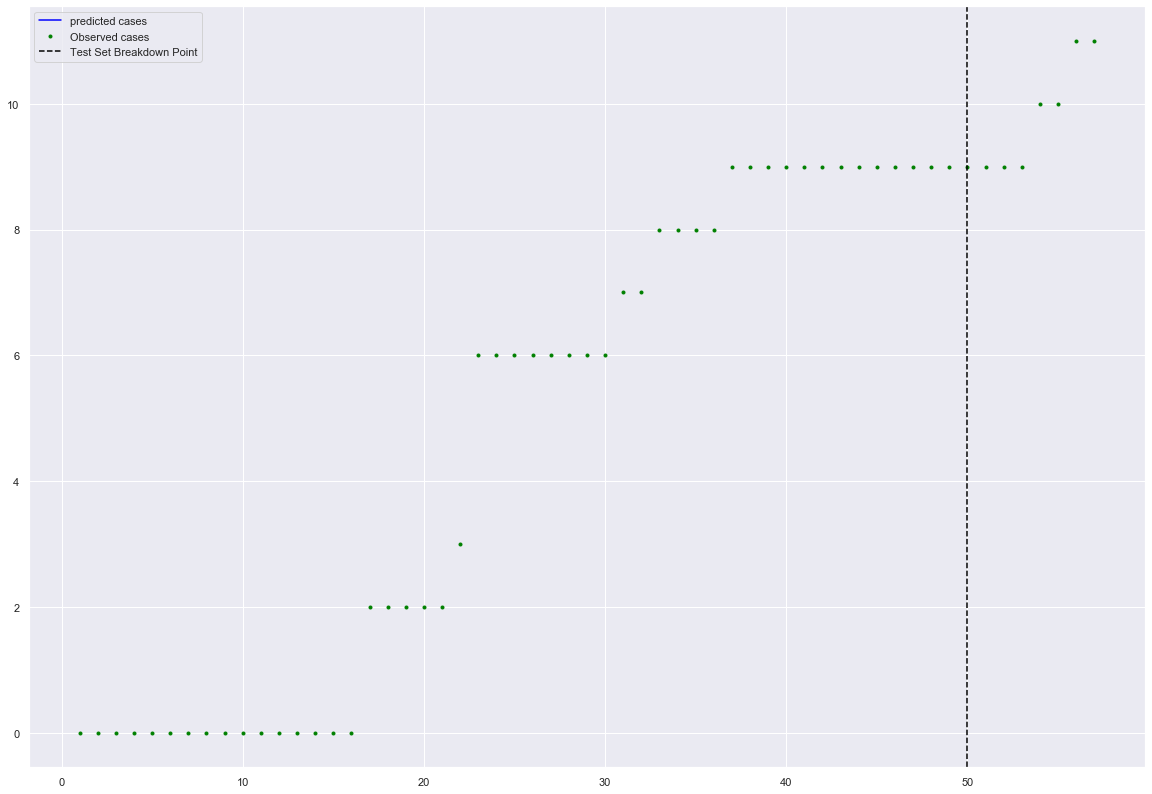

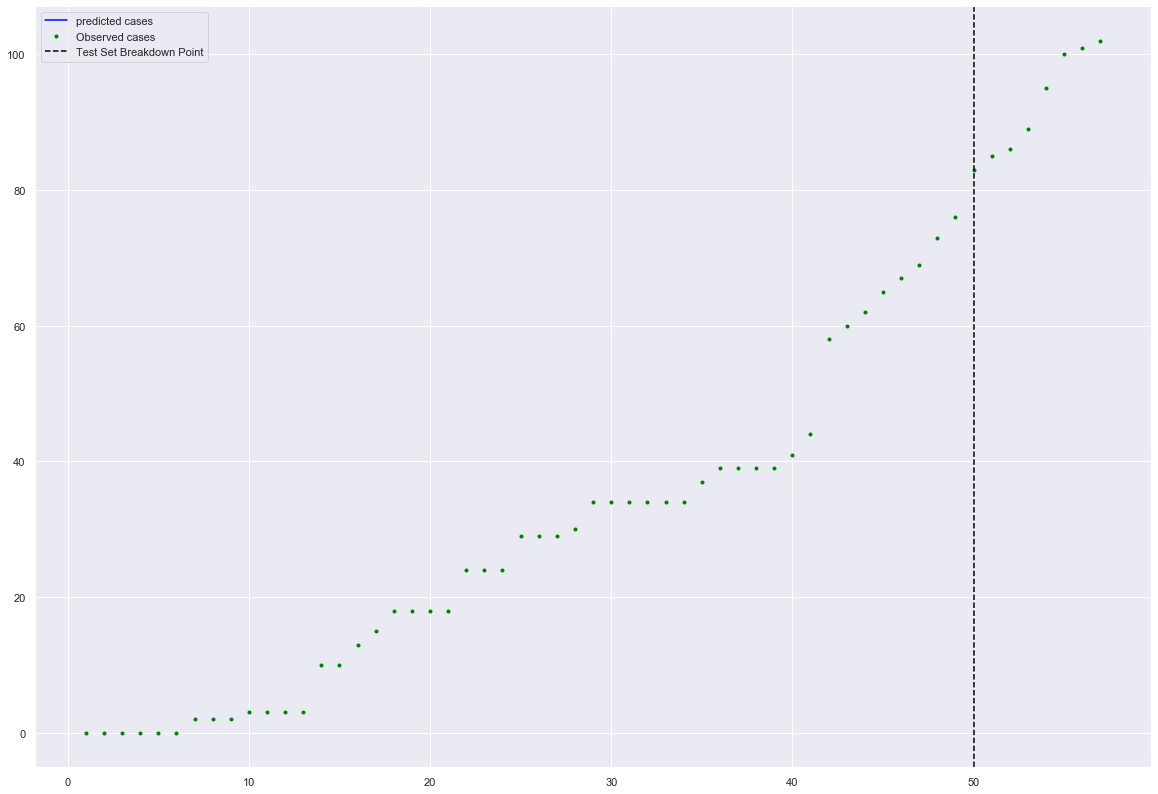

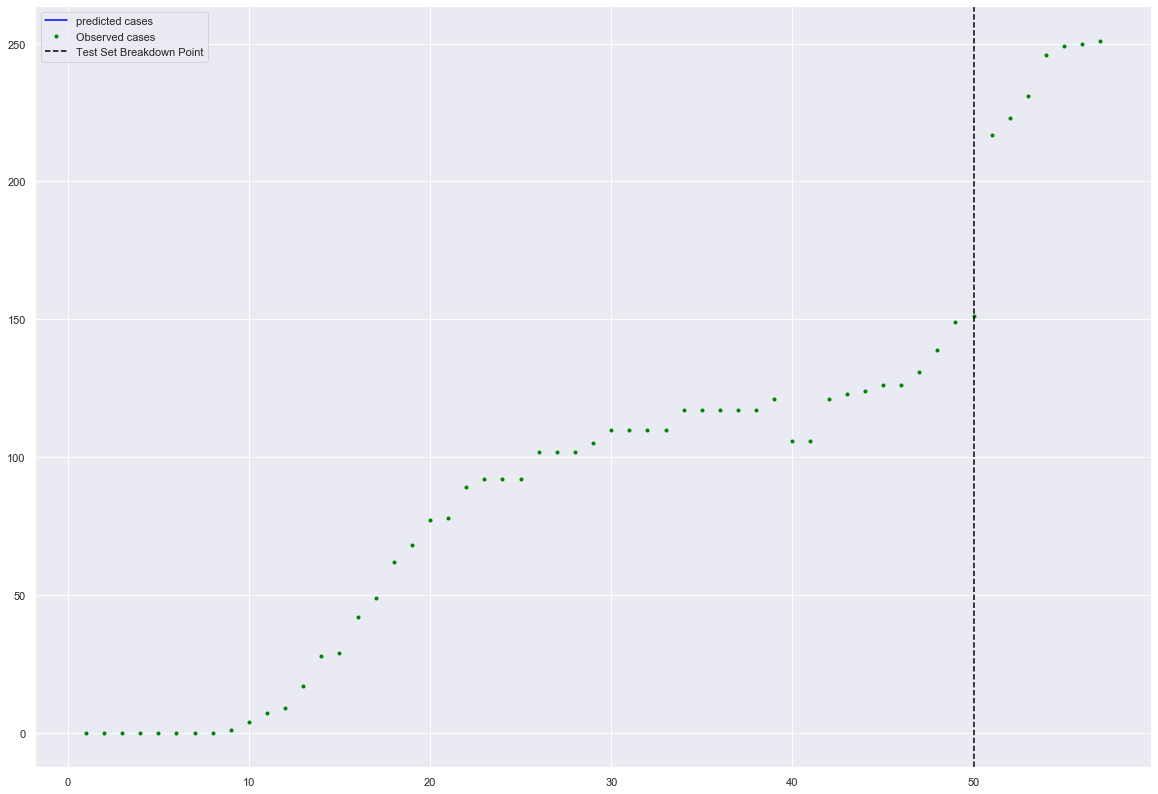

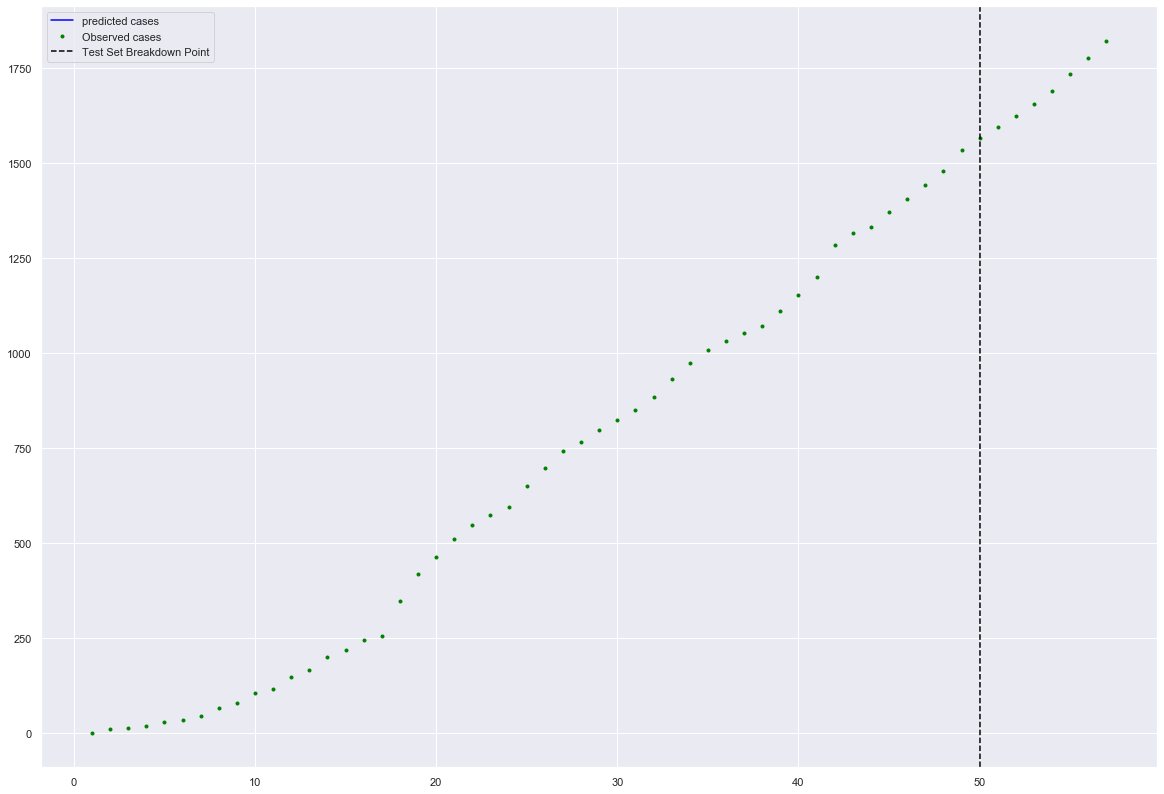

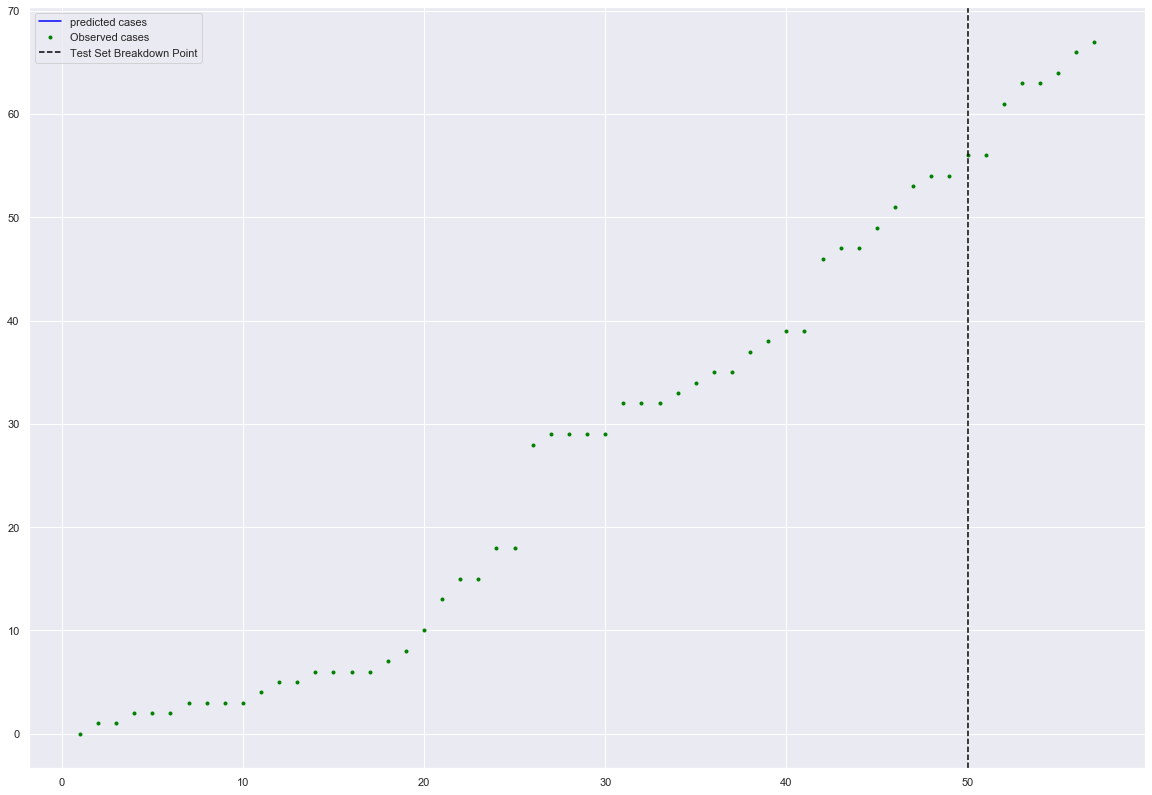

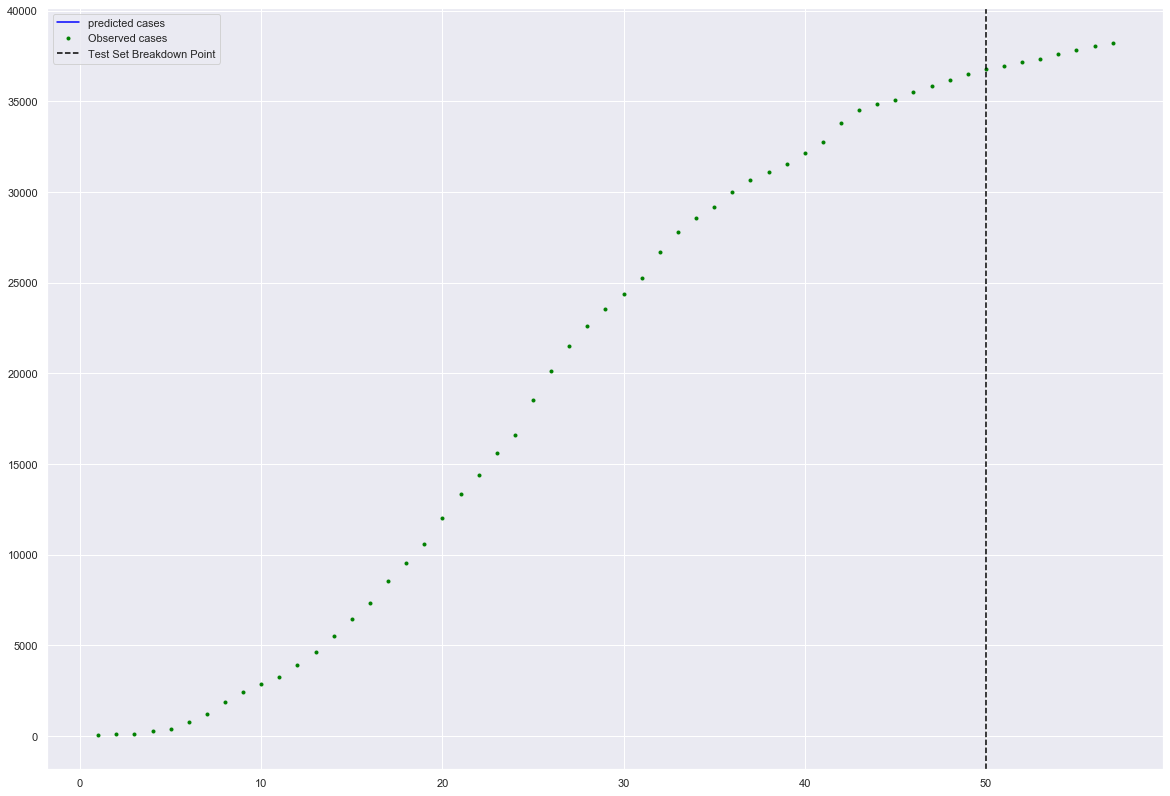

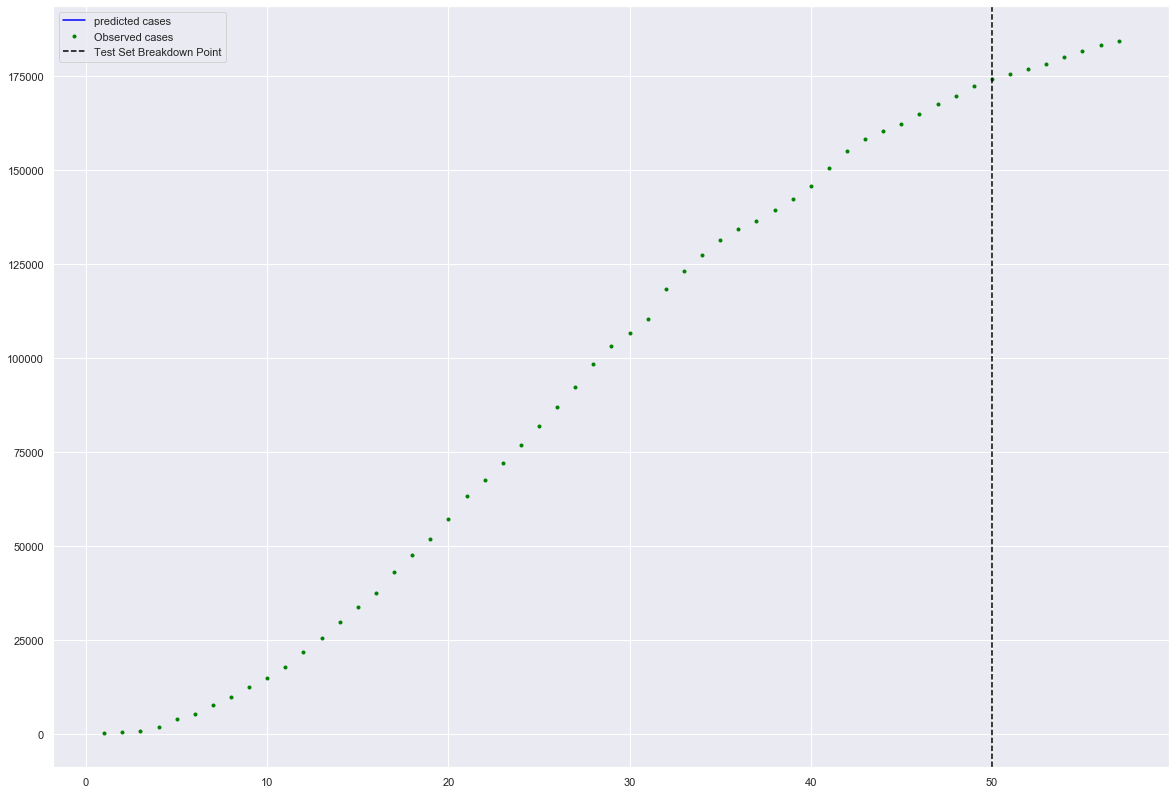

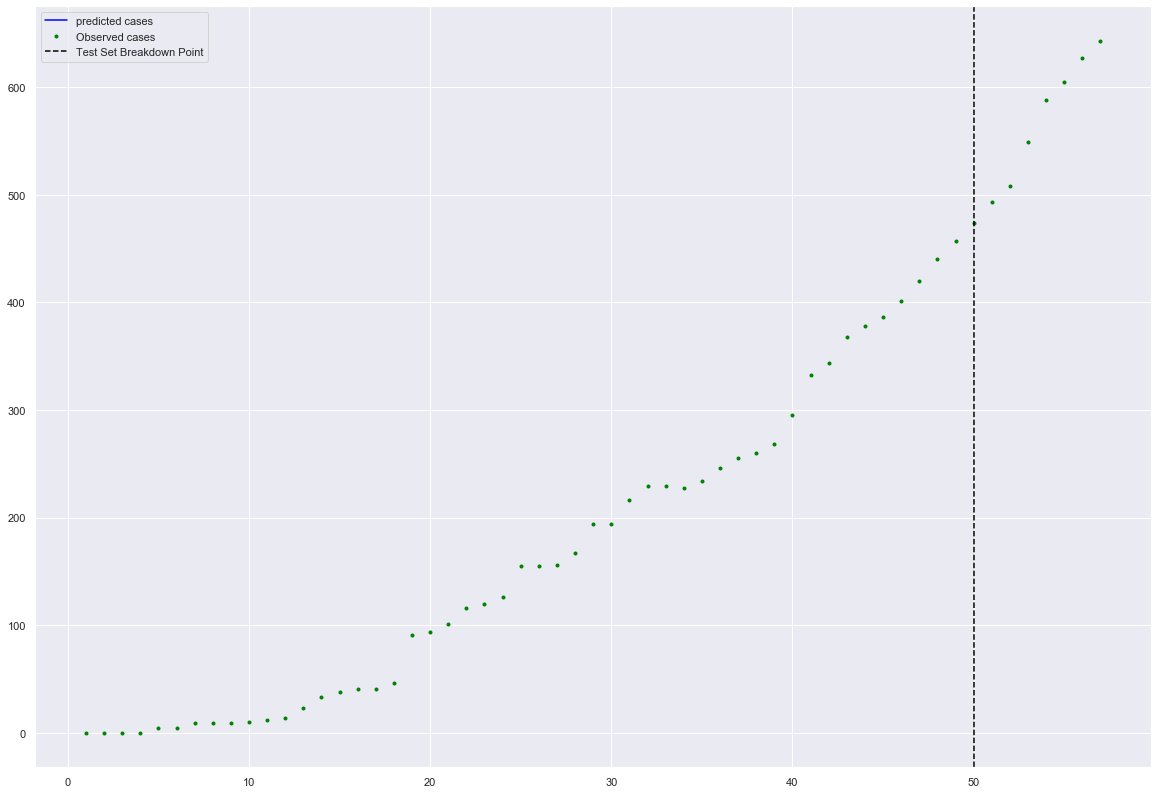

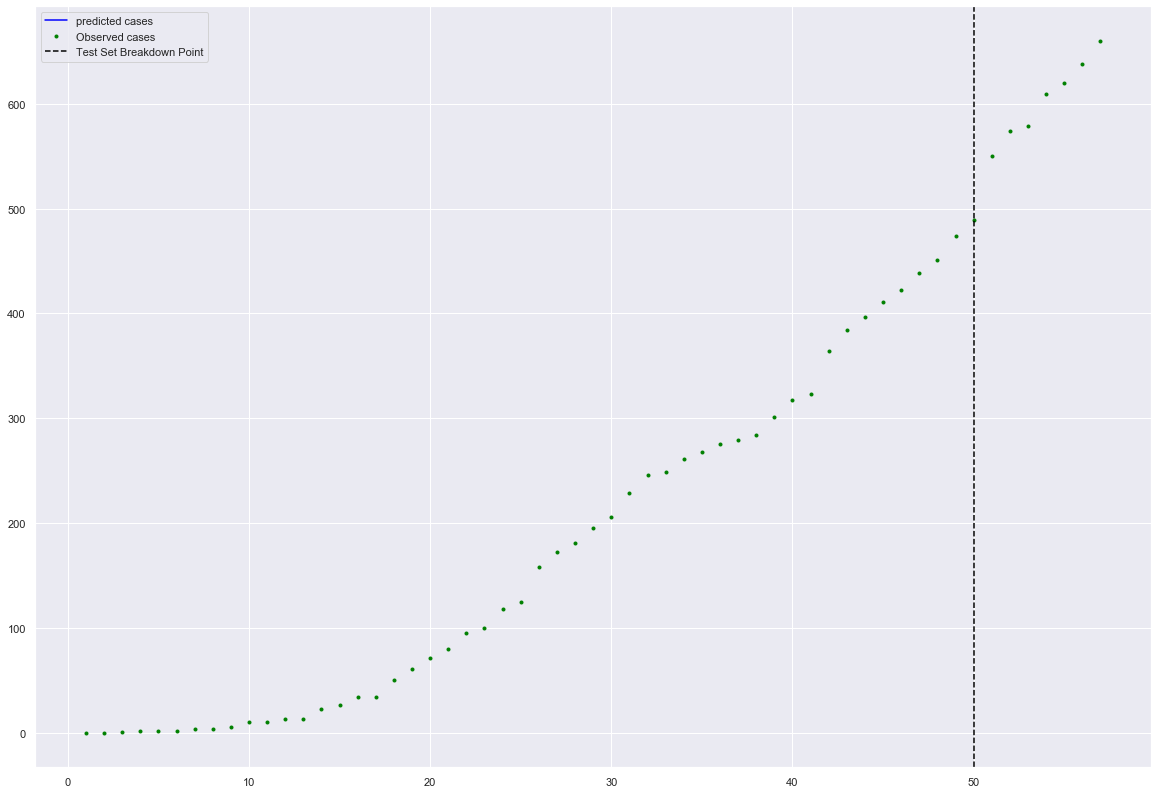

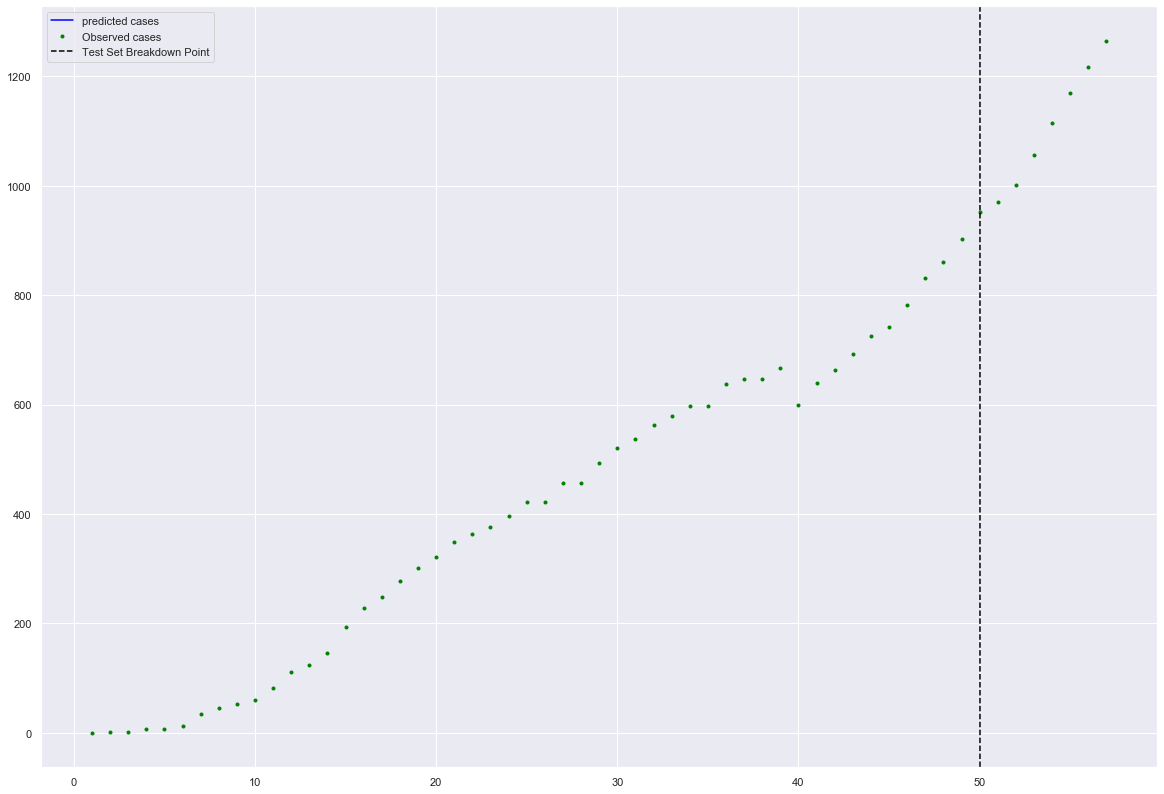

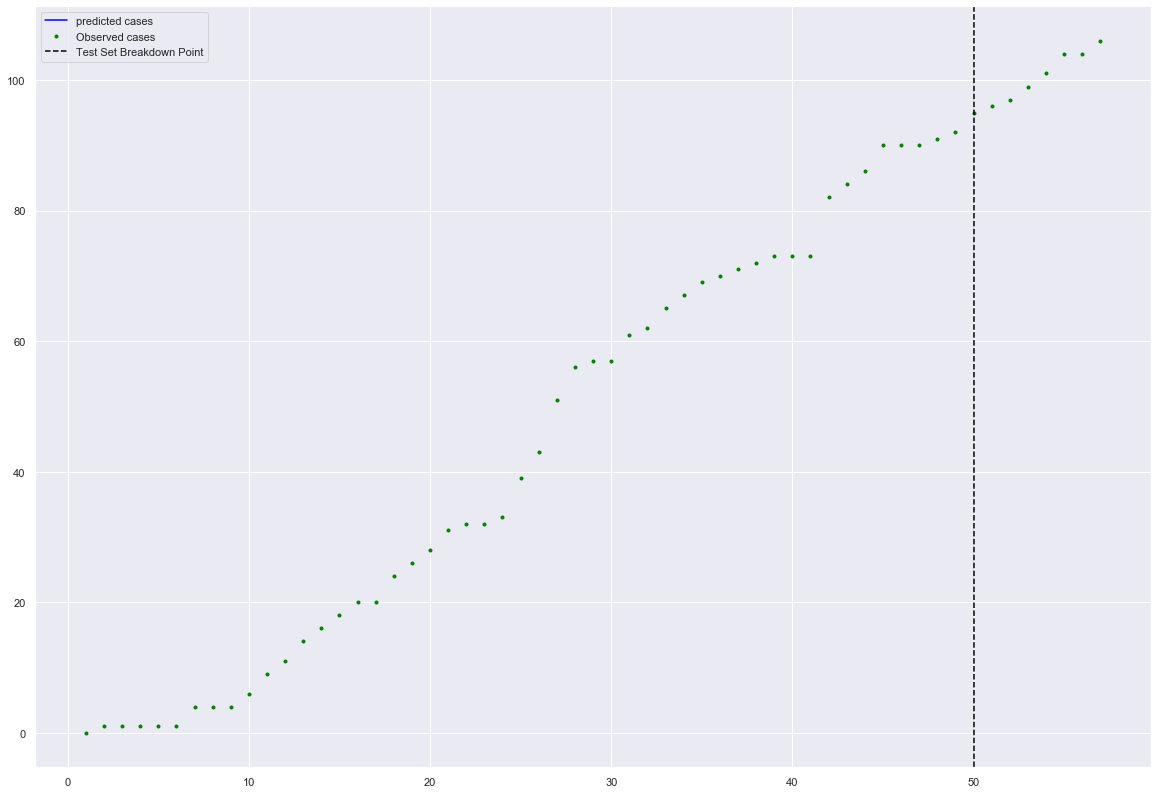

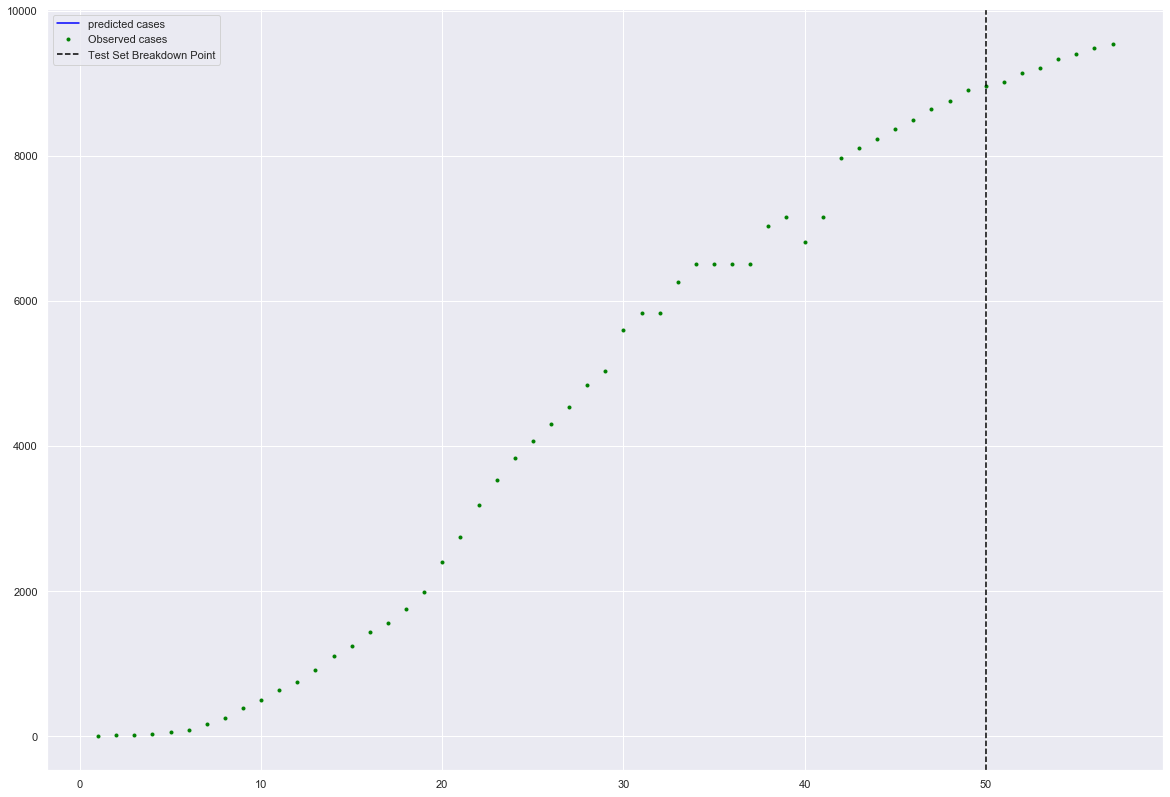

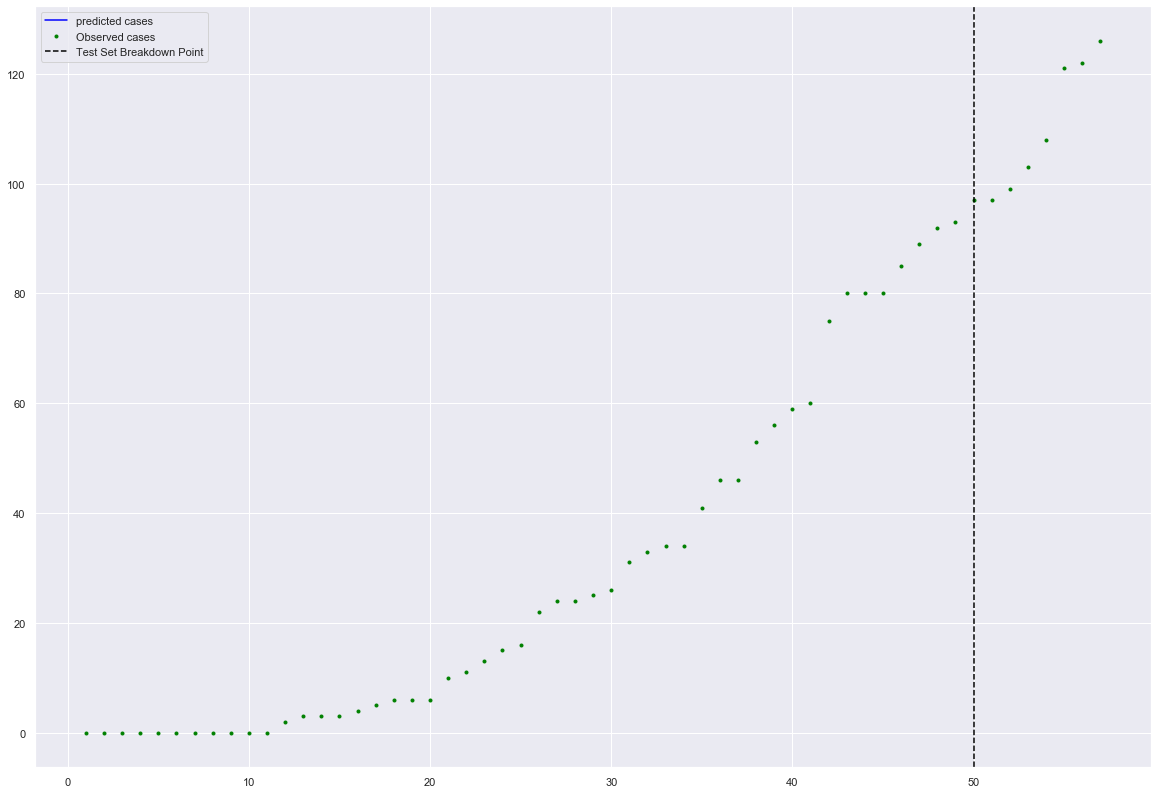

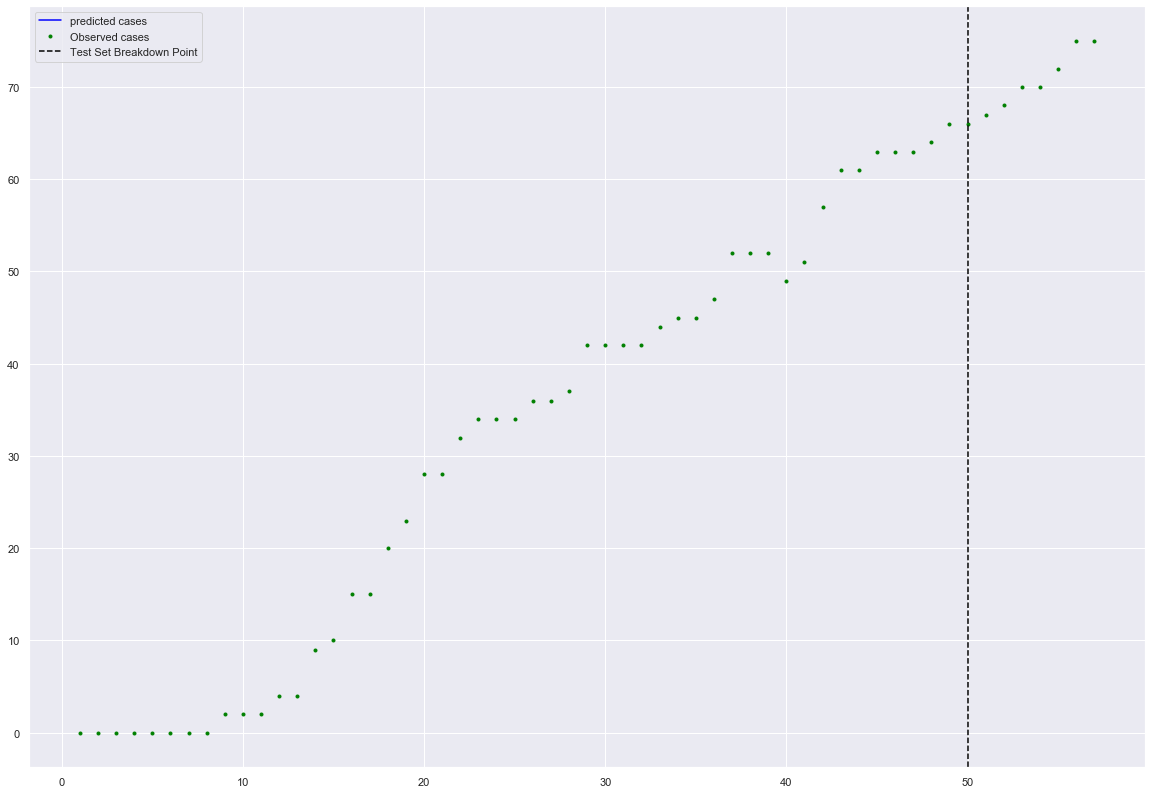

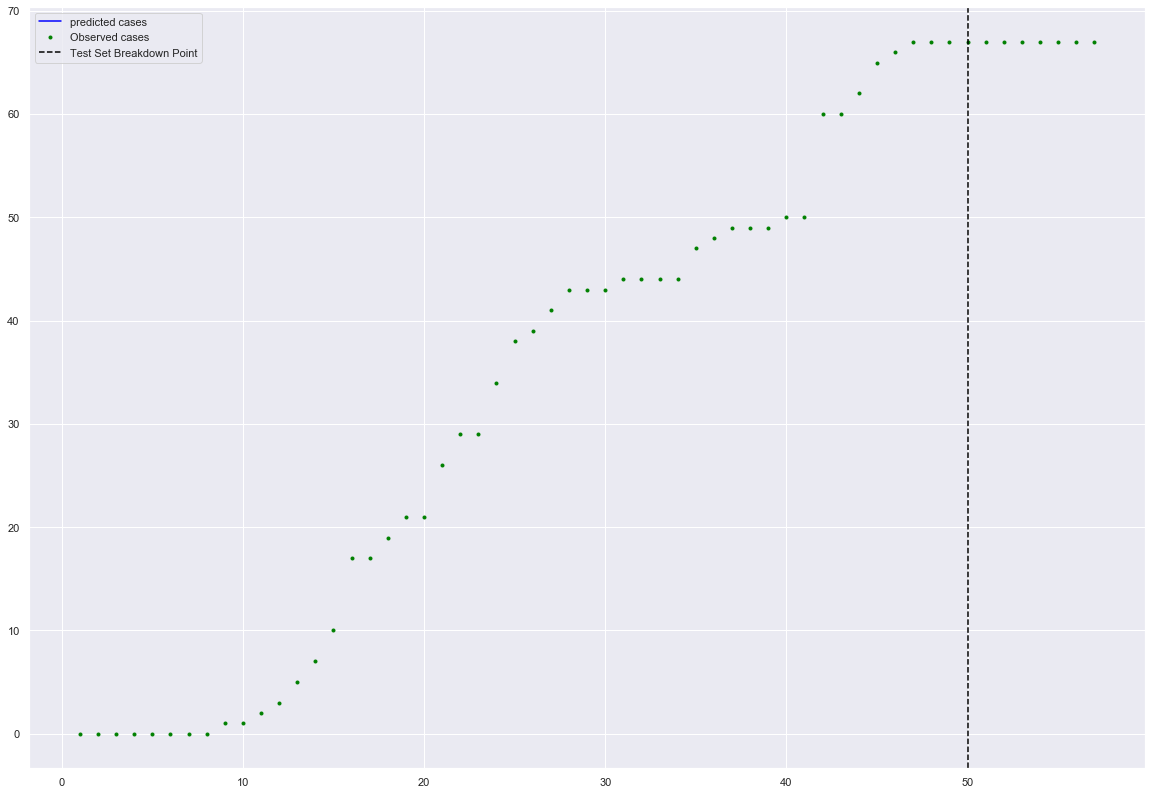

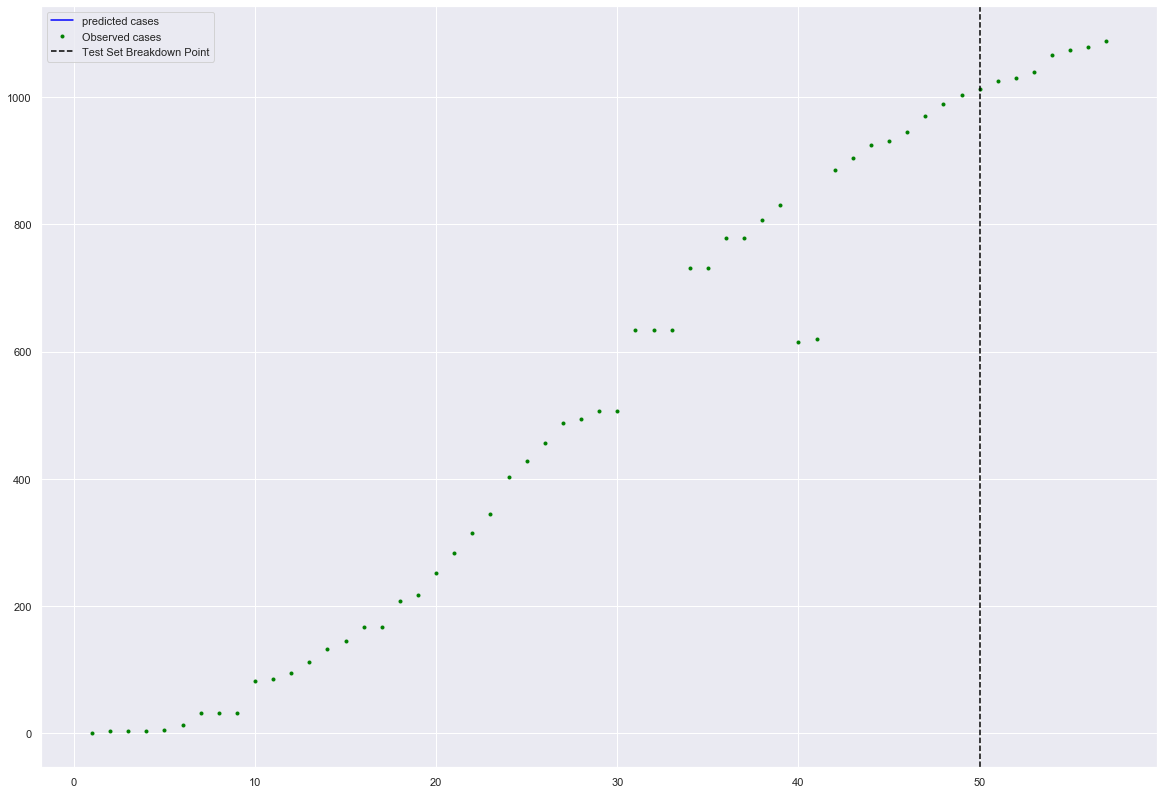

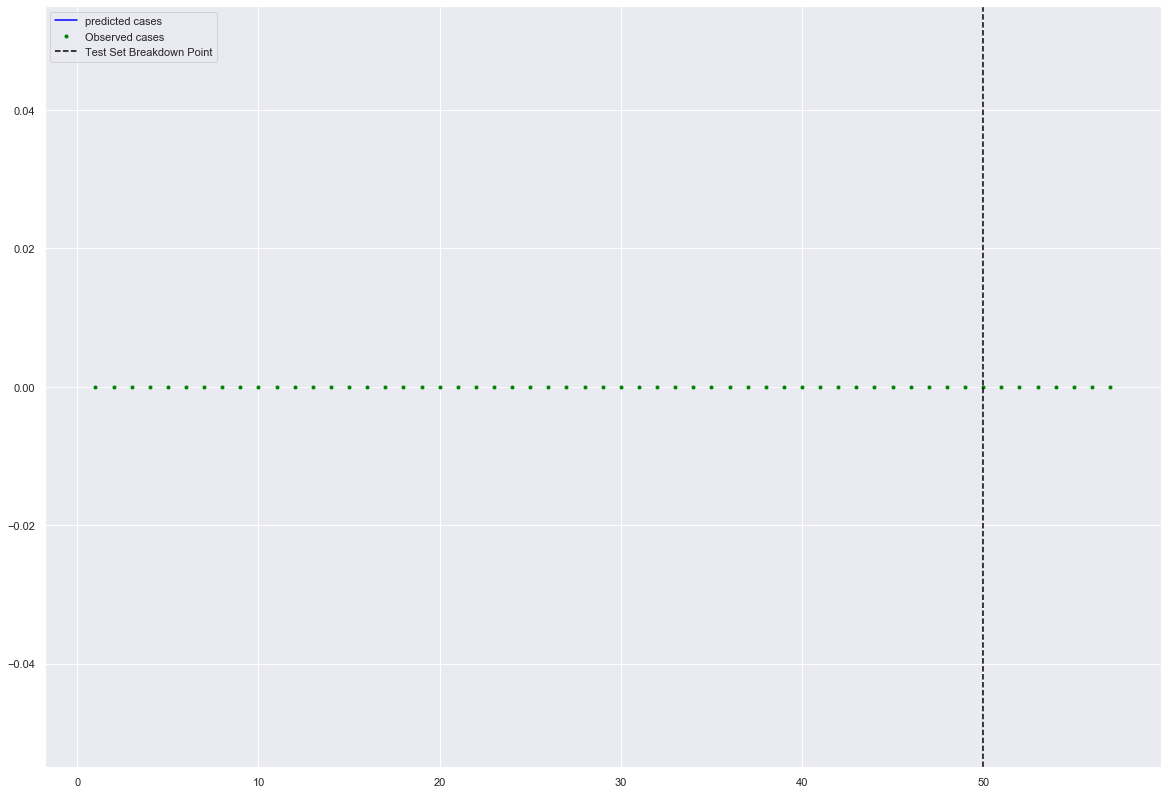

Error in callback <function flush_figures at 0x11eedcea0> (for post_execute):


KeyboardInterrupt: 

In [461]:
predicted_model_risk_density_weighted = \
predictAndSave(model = model_risk_density_weighted,
               save_name = 'risk_density_weighted')

predicted_model_risk_moving_avg_density_weighted = \
predictAndSave(model = model_risk_moving_avg_density_weighted,
               save_name = 'risk_moving_avg_density_weighted')

# predicted_model_risk_moving_avg = \
# predictAndSave(model = model_risk_moving_avg,
#                save_name = 'risk_moving_avg')

In [ ]:
### 5. Grid Search For better Modeling ### 

In [89]:
# 5.1 Try different Functional Forms
function_form_ls = [ln_gaussian_cdf, expit]
function_form_name_dict = dict(zip(function_form_ls, ['ln_gaussian_cdf','expit']))
'risk_density_weighted_{}'. \
                   format(function_form_name_dict[ln_gaussian_cdf])

'risk_density_weighted_ln_gaussian_cdf'

In [ ]:
for function_form in function_form_ls:
    # define each model 
    model_risk_density_weighted = defineModel(data = train,
                                              risk_var = 'risk_density_weighted', 
                                              group_var = 'FIPS',
                                              function_form = function_form)
    model_risk_moving_avg_density_weighted = defineModel(data = train,
                                                         risk_var = \
                                                         'risk_moving_avg_density_weighted',
                                                         group_var = 'FIPS',
                                                         function_form = function_form)
    ## we performed two fit as we found that first fit the data with prior and 
    ## then remove them make a more reasonable fit
    # first fit 
    model_risk_density_weighted.fit_params(fe_init= [0.30271352, 170.38490703,
                                                 25.19263101, 5.47675323],
                                       fe_gprior=[[alpha_prior, np.inf], 
                                                  [170.38490703, np.inf],
                                                  [ 25.19263101, np.inf], 
                                                  [10000, 19942.47999282086]],
                                       fe_bounds=[[0., 1.], 
                                                  [15., np.inf], 
                                                  [0., np.inf],
                                                  [0., np.inf]],
                                       re_bounds=[[-1., 1.], 
                                                  [-1., 1.], 
                                                  [-1., 1.], 
                                                  [-1., 1.]],
                                       smart_initialize = True)
    
    model_risk_moving_avg_density_weighted.fit_params(fe_init= [0.30271352, 170.38490703,
                                                 25.19263101, 5.47675323],
                                       fe_gprior=[[alpha_prior, np.inf], 
                                                  [170.38490703, np.inf],
                                                  [ 25.19263101, np.inf], 
                                                  [10000, 19942.47999282086]],
                                       fe_bounds=[[0., 1.], 
                                                  [15., np.inf], 
                                                  [0., np.inf],
                                                  [0., np.inf]],
                                       re_bounds=[[-1., 1.], 
                                                  [-1., 1.], 
                                                  [-1., 1.], 
                                                  [-1., 1.]],
                                       smart_initialize = True)
    # second fit
    model_risk_density_weighted.fit_params(fe_init= [0.30271352, 170.38490703,
                                                 25.19263101, 5.47675323],
                                       smart_initialize = True)
    
    model_risk_moving_avg_density_weighted.fit_params(fe_init= [0.30271352, 170.38490703,
                                                 25.19263101, 5.47675323],
                                       smart_initialize = True)
    
    # predict and save
    predicted_model_risk_density_weighted = \
    predictAndSave(model = model_risk_density_weighted,
                   save_name = 'risk_density_weighted_{}'. \
                   format(function_form_name_dict[function_form]))

    predicted_model_risk_moving_avg_density_weighted = \
    predictAndSave(model = model_risk_moving_avg_density_weighted,
                   save_name = 'risk_moving_avg_density_weighted_{}'. \
                   format(function_form_name_dict[function_form]))
    

In [531]:
### 6. Calculate MSE ### 
predicted_gaussian_cdf = \
pd.read_csv('PredictedConfirmedCases_Model_risk_density_weighted_gaussian_cdf.csv',
            header = 0).drop(['Unnamed: 0'], axis = 1)
predicted_ln_gaussian_cdf = \
pd.read_csv('PredictedConfirmedCases_Model_risk_density_weighted_ln_gaussian_cdf.csv',
            header = 0).drop(['Unnamed: 0'], axis = 1)
predicted_expit = \
pd.read_csv('PredictedConfirmedCases_Model_risk_density_weighted_expit.csv',
           header = 0).drop(['Unnamed: 0'], axis = 1)

In [533]:
predicted_gaussian_cdf.tail()

time   FIPS   predicted
4363    52  42103  341.787636
4364    53  42103  342.452839
4365    54  42103  342.971281
4366    55  42103  343.371371
4367    56  42103  343.677091

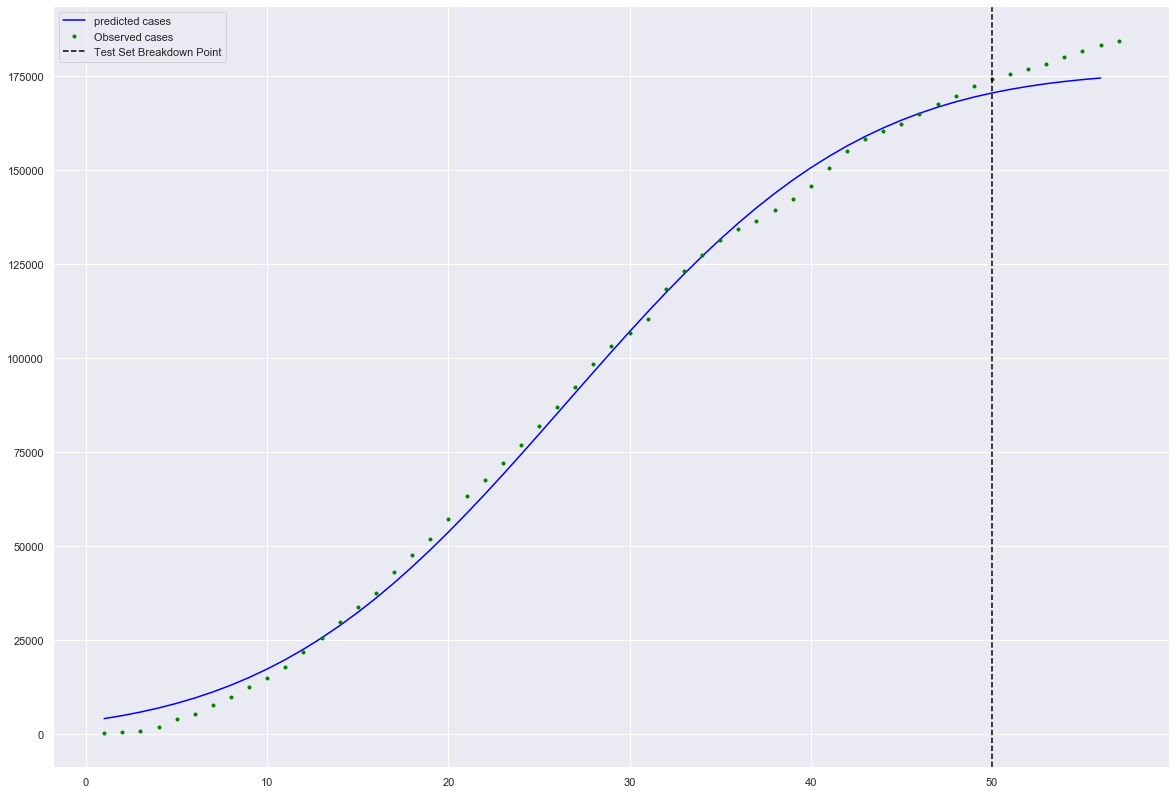

In [545]:
y_pred_data = predicted_gaussian_cdf[predicted_gaussian_cdf.FIPS == 36061].predicted
fig, ax2 = plt.subplots(nrows = 1, ncols = 1, figsize = (20,14))
plt.plot(range(1, len(y_pred_data)+1), y_pred_data, '-', 
         label = 'predicted cases', color = 'blue')
plt.plot(range(1,len(data[data.FIPS == 36061].confirmed_cases)+1),
         data[data.FIPS == 36061].confirmed_cases, '.',
        label = 'Observed cases', color = 'green')
ax2.axvline(x = 50, label = 'Test Set Breakdown Point', 
            ls = '--',color = 'black')
plt.legend(loc='upper left')

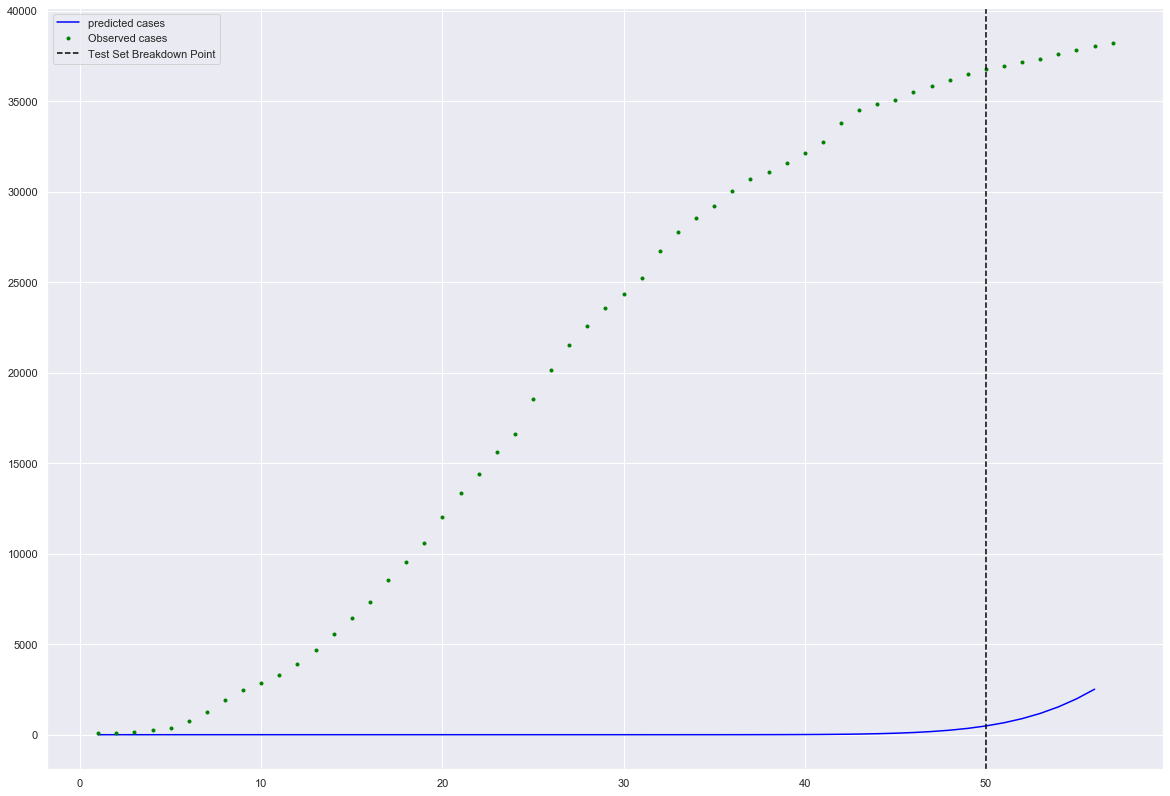

In [547]:
y_pred_data = predicted_gaussian_cdf[predicted_gaussian_cdf.FIPS == 36059].predicted
fig, ax2 = plt.subplots(nrows = 1, ncols = 1, figsize = (20,14))
plt.plot(range(1, len(y_pred_data)+1), y_pred_data, '-', 
         label = 'predicted cases', color = 'blue')
plt.plot(range(1,len(data[data.FIPS == 36059].confirmed_cases)+1),
         data[data.FIPS == 36059].confirmed_cases, '.',
        label = 'Observed cases', color = 'green')
ax2.axvline(x = 50, label = 'Test Set Breakdown Point', 
            ls = '--',color = 'black')
plt.legend(loc='upper left')

In [534]:
# observed cases
observed_data = data[['FIPS', 'confirmed_cases', 'time']]
observed_data.tail()

FIPS  confirmed_cases  time
4433  36017              109    57
4432  36015              131    57
4431  36013               41    57
4450  36051              102    57
4488  42103              432    57

In [535]:
# merge
observed_pred_data = observed_data.merge(predicted_gaussian_cdf,
                                         on = ['time','FIPS']). \
merge(predicted_ln_gaussian_cdf, on = ['time','FIPS'],
      suffixes = ("_gaussian","_lngaussian")). \
merge(predicted_expit, on = ['time','FIPS'],
      suffixes = ("_lngaussian","_expit"))

In [536]:
observed_pred_data.columns = ['FIPS', 'confirmed_cases', 'time', 'predicted_gaussian',
       'predicted_lngaussian', 'predicted_expit']

In [537]:
observed_pred_data_test = observed_pred_data[observed_pred_data.time >= 46]

In [337]:
# calculate MSE for each method 
mse_gaussian_col = []
mse_ln_gaussian_col = []
mse_expit_col = []
fips_col = []
for fips in observed_pred_data_test.FIPS.unique():
    data_sub = observed_pred_data_test[observed_pred_data_test.FIPS == fips]
    
    mse_gaussian = np.mean((data_sub.predicted_gaussian -
                   data_sub.confirmed_cases) ** 2)
    mse_ln_gaussian = np.mean((data_sub.predicted_lngaussian -
                   data_sub.confirmed_cases) ** 2)
    mse_expit = np.mean((data_sub.predicted_expit -
                   data_sub.confirmed_cases) ** 2)
    
    fips_col.append(fips)
    mse_gaussian_col.append(mse_gaussian)
    mse_ln_gaussian_col.append(mse_ln_gaussian)
    mse_expit_col.append(mse_expit)
    
    print('By Gaussian, MSE of',fips,'on test set is: ', mse_gaussian, '\n' )
    print('By Ln Gaussian CDF, MSE of',fips,'on test set is: ',mse_ln_gaussian, '\n' )
    print('By Expit, MSE of',fips,'on test set is: ', mse_expit, '\n' )
    
mse_df = pd.DataFrame({'fips':fips_col, 'mse_gaussian':mse_gaussian_col, 
                       'mse_ln_gaussian':mse_ln_gaussian_col, 'mse_expit':mse_expit_col})

By Gaussian, MSE of 29095 on test set is:  8439.313201977579 

By Ln Gaussian CDF, MSE of 29095 on test set is:  8439.313158414601 

By Expit, MSE of 29095 on test set is:  8439.313158414601 

By Gaussian, MSE of 29183 on test set is:  10516.242360943445 

By Ln Gaussian CDF, MSE of 29183 on test set is:  10516.242260474579 

By Expit, MSE of 29183 on test set is:  10516.242260474579 

By Gaussian, MSE of 34003 on test set is:  3917444.001044253 

By Ln Gaussian CDF, MSE of 34003 on test set is:  3917443.9395453124 

By Expit, MSE of 34003 on test set is:  3917443.9395453124 

By Gaussian, MSE of 34013 on test set is:  3708034.8495973037 

By Ln Gaussian CDF, MSE of 34013 on test set is:  3708034.7989304913 

By Expit, MSE of 34013 on test set is:  3708034.7989304913 

By Gaussian, MSE of 34017 on test set is:  4725620.792989066 

By Ln Gaussian CDF, MSE of 34017 on test set is:  4725620.731212645 

By Expit, MSE of 34017 on test set is:  4725620.731212645 

By Gaussian, MSE of 34019 o

By Ln Gaussian CDF, MSE of 36067 on test set is:  63566.89697765091 

By Expit, MSE of 36067 on test set is:  63566.89697765091 

By Gaussian, MSE of 36069 on test set is:  221.49362232011708 

By Ln Gaussian CDF, MSE of 36069 on test set is:  221.49362001843838 

By Expit, MSE of 36069 on test set is:  221.49362001843838 

By Gaussian, MSE of 36071 on test set is:  6026252.765097978 

By Ln Gaussian CDF, MSE of 36071 on test set is:  6026252.734377938 

By Expit, MSE of 36071 on test set is:  6026252.734377938 

By Gaussian, MSE of 36073 on test set is:  107.26704219440973 

By Ln Gaussian CDF, MSE of 36073 on test set is:  107.267040486282 

By Expit, MSE of 36073 on test set is:  107.267040486282 

By Gaussian, MSE of 36075 on test set is:  156.70192533812443 

By Ln Gaussian CDF, MSE of 36075 on test set is:  156.70192404158814 

By Expit, MSE of 36075 on test set is:  156.70192404158814 

By Gaussian, MSE of 36077 on test set is:  105.2942946682344 

By Ln Gaussian CDF, MSE of 360

In [338]:
baseline = pd.read_csv('baseline_mse.csv', header = 0).drop(['Unnamed: 0'], axis = 1)
baseline.columns = ['fips','mse_baseline']
mse_df = mse_df.merge(baseline, on = 'fips')
mse_df.to_csv('mse_models_baselines.csv')
mse_df[mse_df.mse_gaussian < mse_df.mse_baseline].shape
mse_df[mse_df.mse_ln_gaussian < mse_df.mse_baseline].shape
mse_df[mse_df.mse_expit < mse_df.mse_baseline].shape

In [345]:
### 7. Analyzing Performance ### 

# 1. Are there more cases in these counties?
better_fips_expit = mse_df[mse_df.mse_expit < mse_df.mse_baseline].fips.unique()
print(better_fips_expit)
better_fips_ln_gaussian = mse_df[mse_df.mse_ln_gaussian < mse_df.mse_baseline].fips.unique()
print(better_fips_ln_gaussian)
better_fips_gaussian = mse_df[mse_df.mse_gaussian < mse_df.mse_baseline].fips.unique()
print(better_fips_gaussian)

total_cases = data[data['time'] == max(data['time'])]['confirmed_cases'].sum()
better_fips_expit_cases = \
data[(data['time'] == max(data['time'])) & \
     (data.FIPS.isin(better_fips_expit))]['confirmed_cases'].sum()
print(better_fips_expit_cases/total_cases)

better_fips_ln_gaussian_cases = \
data[(data['time'] == max(data['time'])) & \
     (data.FIPS.isin(better_fips_ln_gaussian))]['confirmed_cases'].sum()
print(better_fips_ln_gaussian_cases/total_cases)

better_fips_gaussian_cases = \
data[(data['time'] == max(data['time'])) & \
     (data.FIPS.isin(better_fips_gaussian))]['confirmed_cases'].sum()
print(better_fips_gaussian_cases/total_cases)

[36007 36029 36031 36035 36051 36055 36057 36061 36063 36067 36083 36095
 36097 36105]
[36007 36029 36031 36035 36051 36055 36057 36061 36063 36067 36083 36095
 36097 36105]
[36007 36029 36031 36035 36051 36055 36057 36061 36063 36067 36083 36095
 36097 36105]
0.4224174937884563
0.4224174937884563
0.4224174937884563


In [354]:
# 2. What are the average improvement on the MSE, in percentage
mse_df_better = mse_df[mse_df.mse_ln_gaussian < mse_df.mse_baseline]
# mse_df_better = mse_df
avg_improvement_expit = np.mean((mse_df_better.mse_baseline - mse_df_better.mse_expit )/ \
                                mse_df_better.mse_baseline)
avg_improvement_ln_gaussian = np.mean((mse_df_better.mse_baseline - mse_df_better.mse_ln_gaussian)/ \
                                      mse_df_better.mse_baseline)
avg_improvement_gaussian = np.mean((mse_df_better.mse_baseline - mse_df_better.mse_gaussian)/ \
                                   mse_df_better.mse_baseline)
print(avg_improvement_expit)
print(avg_improvement_ln_gaussian)
print(avg_improvement_gaussian)

0.45995722814581796
0.45995722814581796
0.4599572220382866


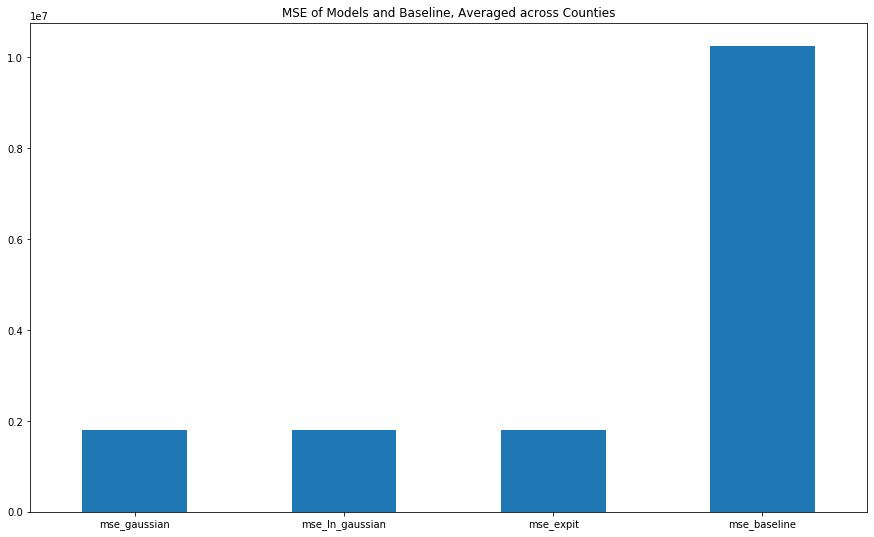

In [355]:
# 3. Can we visualize the improvement?
mse_df_mean = mse_df_better.mean()
# plt.figsize = (25,9)
f = mse_df_mean[1:].plot.bar(title = 'MSE of Models and Baseline, Averaged across Counties', 
                             rot = 0, figsize=(15,9))
plt.savefig('MSE of Models and Baseline, Averaged across Counties.png')

In [231]:
observed_pred_data[observed_pred_data.FIPS == 36061].head()

FIPS  confirmed_cases  time  predicted_gaussian  predicted_lngaussian  \
44   36061              269     1         3619.627976           4016.597813   
122  36061              463     2         4419.347340           4823.449067   
200  36061              814     3         5361.748046           5761.191932   
278  36061             1871     4         6464.359293           6844.404569   
356  36061             3954     5         7745.208659           8088.012054   

     predicted_expit  
44       3364.230117  
122      4133.169990  
200      5044.422451  
278      6116.286352  
356      7367.683535

In [359]:
# 3. Are there more people in these counties?
path = "/Users/yezichang/Desktop/NYU/COVID-19/NYU/data"
population_by_county = pd.read_csv(path + '/reference/' + \
                                  'population_by_county.csv', header = 0,
                                  thousands=',')
observed_pred_data = observed_pred_data.merge(population_by_county, 
                                              left_on = 'FIPS', right_on = 'Fipcode')

In [360]:
observed_pred_data.head()

FIPS  confirmed_cases  time  predicted_gaussian  predicted_lngaussian  \
0  29095                0     1                 0.0                   0.0   
1  29095                0     2                 0.0                   0.0   
2  29095                1     3                 0.0                   0.0   
3  29095                3     4                 0.0                   0.0   
4  29095                3     5                 0.0                   0.0   

   predicted_expit   County State_Name State  Fipcode  Population  
0              0.0  Jackson   Missouri    MO    29095      703011  
1              0.0  Jackson   Missouri    MO    29095      703011  
2              0.0  Jackson   Missouri    MO    29095      703011  
3              0.0  Jackson   Missouri    MO    29095      703011  
4              0.0  Jackson   Missouri    MO    29095      703011

In [370]:
observed_pred_data = observed_pred_data[(observed_pred_data['FIPS'] >= 36000) & \
                  (observed_pred_data['FIPS'] < 37000)]

In [371]:
total_pop = observed_pred_data[observed_pred_data['time'] == \
                               max(observed_pred_data['time'])]['Population'].sum()
print(total_pop)

19683424


In [524]:
# better_fips_expit_cases = \
better_pop = observed_pred_data[(observed_pred_data['time'] == max(observed_pred_data['time'])) & \
     (observed_pred_data.FIPS.isin(better_fips_expit))]['Population'].sum()
print(better_pop/total_pop)

better_fips_ln_gaussian_pop = \
observed_pred_data[(observed_pred_data['time'] == max(observed_pred_data['time'])) & \
     (observed_pred_data.FIPS.isin(better_fips_ln_gaussian))]['Population'].sum()
print(better_fips_ln_gaussian_pop/total_pop)

better_fips_gaussian_pop = \
observed_pred_data[(observed_pred_data['time'] == max(observed_pred_data['time'])) & \
     (observed_pred_data.FIPS.isin(better_fips_gaussian))]['Population'].sum()
print(better_fips_gaussian_pop/total_pop)

0.23546868674880955
0.23546868674880955
0.23546868674880955


In [522]:
# why the models perform better at these states?
len(better_fips_expit)

14

In [523]:
observed_pred_data.FIPS.unique()

array([36001, 36003, 36005, 36007, 36009, 36011, 36013, 36015, 36017,
       36019, 36021, 36023, 36025, 36027, 36029, 36031, 36033, 36035,
       36037, 36039, 36041, 36043, 36045, 36047, 36049, 36051, 36053,
       36055, 36057, 36059, 36061, 36063, 36065, 36067, 36069, 36071,
       36073, 36075, 36077, 36079, 36081, 36083, 36085, 36087, 36089,
       36091, 36093, 36095, 36097, 36099, 36101, 36103, 36105, 36107,
       36109, 36111, 36113, 36115, 36117, 36119, 36121, 36123])

In [379]:
fips_pop_density = data[['FIPS','Population Density']].drop_duplicates()

In [384]:
fips_pop_density['density_rank'] = fips_pop_density['Population Density'].rank(ascending = False)

In [471]:
fips_pop_density[fips_pop_density.FIPS.isin(better_fips_expit)].shape

(14, 3)

In [401]:
data = data.drop_duplicates()

In [403]:
data.head()

Unnamed: 0   FIPS        date  confirmed_cases  confirmed_cases_smooth  \
0            0  25003  2020-03-15                9                      10   
57          57  36083  2020-03-15                0                       1   
56          56  36081  2020-03-15                0                       1   
55          55  36079  2020-03-15                0                       1   
54          54  36077  2020-03-15                0                       1   

    num_visits_movavg_14  num_visitors_nmlz_movavg_14      risk  \
0               5.000000                     0.147059  0.000000   
57           1172.000000                    14.724881  0.000039   
56           1722.727273                    16.746930  0.000214   
55           1840.000000                    20.129153  0.000889   
54            499.166667                     7.415498  0.000057   

    risk_density_weighted  risk_moving_avg  risk_moving_avg_density_weighted  \
0                0.000000         0.000000                          0.000000   
57               0.000251         0.000039                          0.000251   
56               0.001914         0.000214                          0.001914   
55               0.006594         0.000889                          0.006594   
54               0.000196         0.000057                          0.000196   

        COUNTY STATE  num_hospital  num_beds  cum_deaths_count  \
0    BERKSHIRE    MA           3.0    -665.0               NaN   
57  RENSSELAER    NY           3.0     423.0               0.0   
56      QUEENS    NY          12.0     737.0               NaN   
55      PUTNAM    NY           1.0     164.0               0.0   
54      OTSEGO    NY           2.0     240.0               0.0   

    cum_recovered_count  Population Density  intercept  time  
0                   NaN          134.807894        1.0     1  
57                  0.0          243.265944        1.0     1  
56                  NaN        20767.142726        1.0     1  
55                  0.0          426.902870        1.0     1  
54                  0.0           59.392034        1.0     1

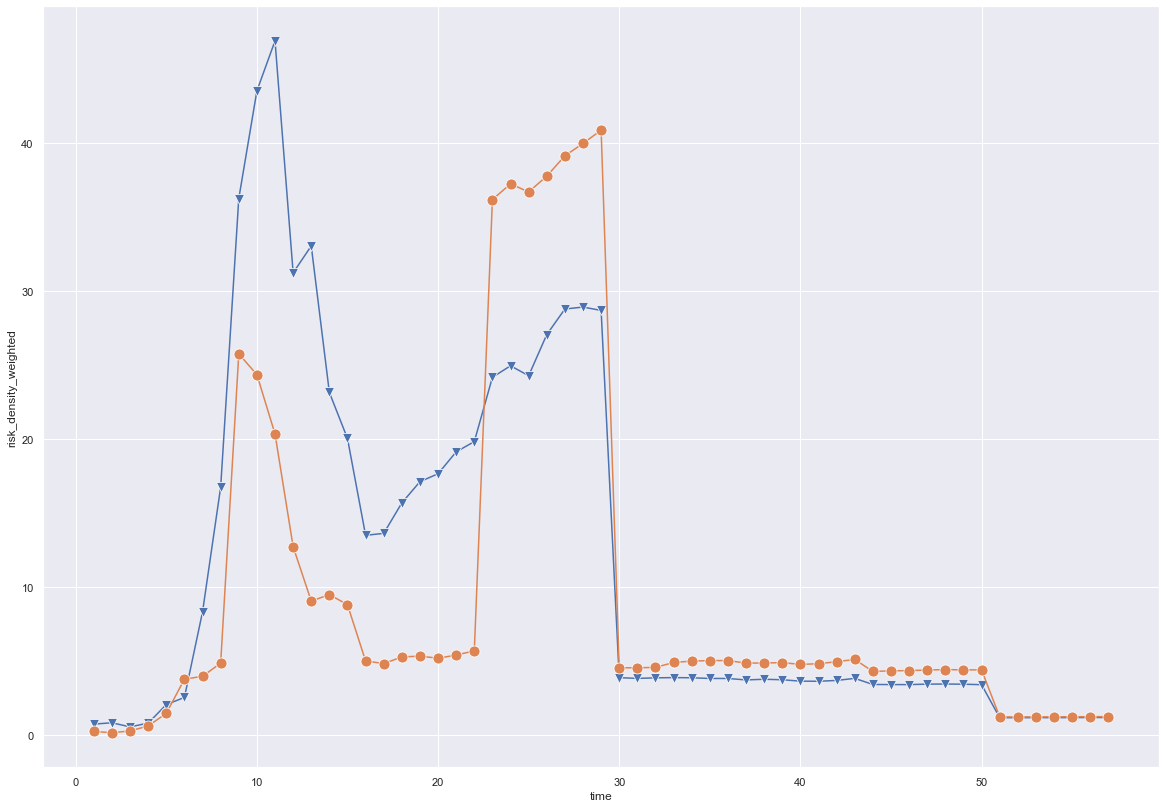

In [407]:
# What are the risks in these regions?
import matplotlib.pyplot as plt
import itertools
import seaborn as sns; sns.set()

fig, ax2 = plt.subplots(nrows = 1, ncols = 1, figsize = (20,14))
marker = itertools.cycle(('v', 'o', '^','>','<','*','+'))
size= itertools.cycle(tuple(range(10,13)))
data_better_fips = data[data.FIPS.isin(better_fips_expit)].sort_values(['time'])
data_risk_check = data[data.FIPS.isin([36059,36061])].sort_values(['time'])
data = data.sort_values(['time'])
for key, grp in data_risk_check.groupby(['FIPS']):
    sns.lineplot(grp['time'],grp['risk_density_weighted'], label = key, marker = next(marker), linestyle='-',
            markersize = next(size))
ax2.get_legend().remove()
plt.show()
# plt.title('Import Risk with Moving Averge of Visits,'+ \
#           'by County and Day')
# plt.savefig('Import Risk Weighted with Moving Average_v0517')

In [470]:
data_better_fips

Unnamed: 0   FIPS        date  confirmed_cases  confirmed_cases_smooth  \
19            19  36007  2020-03-15                1                       2   
69            69  36105  2020-03-15                0                       1   
65            65  36097  2020-03-15                0                       1   
64            64  36095  2020-03-15                0                       1   
57            57  36083  2020-03-15                0                       1   
...          ...    ...         ...              ...                     ...   
4439        4439  36029  2020-05-10             4453                    4454   
4428        4428  36007  2020-05-10              373                     374   
4474        4474  36097  2020-05-10                7                       8   
4452        4452  36055  2020-05-10             1821                    1822   
4478        4478  36105  2020-05-10             1093                    1094   

      num_visits_movavg_14  num_visitors_nmlz_movavg_14      risk  \
19             1600.444444                    20.204598  0.000256   
69              643.000000                    12.653504  0.000008   
65               82.800000                     1.838744  0.000000   
64              247.400000                     4.497894  0.000010   
57             1172.000000                    14.724881  0.000039   
...                    ...                          ...       ...   
4439            616.378641                    15.132977  0.020772   
4428            253.946429                     7.666172  0.004322   
4474             73.250000                     2.226234  0.000553   
4452            665.270588                    13.810059  0.011147   
4478            151.979167                     4.983067  0.025029   

      risk_density_weighted  risk_moving_avg  \
19                 0.001356         0.000256   
69                 0.000030         0.000008   
65                 0.000000         0.000000   
64                 0.000065         0.000010   
57                 0.000251         0.000039   
...                     ...              ...   
4439               0.140227         0.086384   
4428               0.023947         0.019022   
4474               0.002566         0.002171   
4452               0.080611         0.041964   
4478               0.138522         0.093101   

      risk_moving_avg_density_weighted      COUNTY STATE  num_hospital  \
19                            0.001356      BROOME    NY           4.0   
69                            0.000030    SULLIVAN    NY           2.0   
65                            0.000000    SCHUYLER    NY           1.0   
64                            0.000065   SCHOHARIE    NY           1.0   
57                            0.000251  RENSSELAER    NY           3.0   
...                                ...         ...   ...           ...   
4439                          0.581238        ERIE    NY          15.0   
4428                          0.103746      BROOME    NY           4.0   
4474                          0.010074    SCHUYLER    NY           1.0   
4452                          0.294165      MONROE    NY           7.0   
4478                          0.497338    SULLIVAN    NY           2.0   

      num_beds  cum_deaths_count  cum_recovered_count  Population Density  \
19      -257.0               0.0                  0.0          269.900959   
69       169.0               0.0                  0.0           77.915156   
65        25.0               0.0                  0.0           54.235068   
64        40.0               0.0                  0.0           49.852047   
57       423.0               0.0                  0.0          243.265944   
...        ...               ...                  ...                 ...   
4439   -1646.0               NaN                  NaN          881.088339   
4428    -257.0               NaN                  NaN          269.900959   
4474      25.0               NaN                  NaN    

In [418]:
# check their 
model_risk_density_weighted.params[:,np.where(model_risk_density_weighted.group_names 
                                              == 36059)[0][0]]

array([9.07957646e-02, 6.64675110e+01, 2.80990533e+04])

In [419]:
model_risk_density_weighted.params[:,np.where(model_risk_density_weighted.group_names 
                                              == 36061)[0][0]]

array([5.53569626e-02, 2.65420887e+01, 1.76386244e+05])

In [420]:
def gaussian_cdf(t, params): 
 return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)

In [444]:
md_36059 = gaussian_cdf(t = np.array(range(1,200)), 
                        params = [5.53569626e-02, 25, 3.50990533e+04])

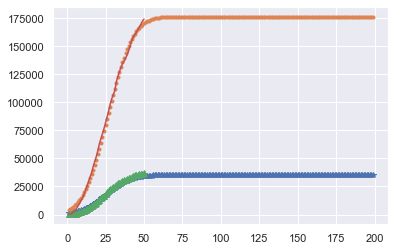

In [529]:
# y_pred_36059 = model_risk_density_weighted.predict(
#     t = range(1,200),
#     group_name=36059
# )
# y_pred_36061 = model_risk_density_weighted.predict(
#     t = range(1,200),
#     group_name=36061
# )
plt.plot(np.array(range(1,200)), md_36059, '*')
plt.plot(np.array(range(1,200)), y_pred_36061, '.')
plt.plot(range(1,51), train[train.FIPS == 36059].confirmed_cases, '^')
plt.plot(range(1,51), train[train.FIPS == 36061].confirmed_cases, '-')

In [446]:
data.head()

Unnamed: 0   FIPS        date  confirmed_cases  confirmed_cases_smooth  \
0            0  25003  2020-03-15                9                      10   
56          56  36081  2020-03-15                0                       1   
55          55  36079  2020-03-15                0                       1   
54          54  36077  2020-03-15                0                       1   
53          53  36075  2020-03-15                0                       1   

    num_visits_movavg_14  num_visitors_nmlz_movavg_14      risk  \
0               5.000000                     0.147059  0.000000   
56           1722.727273                    16.746930  0.000214   
55           1840.000000                    20.129153  0.000889   
54            499.166667                     7.415498  0.000057   
53           1129.333333                    12.310253  0.000000   

    risk_density_weighted  risk_moving_avg  risk_moving_avg_density_weighted  \
0                0.000000         0.000000                          0.000000   
56               0.001914         0.000214                          0.001914   
55               0.006594         0.000889                          0.006594   
54               0.000196         0.000057                          0.000196   
53               0.000000         0.000000                          0.000000   

       COUNTY STATE  num_hospital  num_beds  cum_deaths_count  \
0   BERKSHIRE    MA           3.0    -665.0               NaN   
56     QUEENS    NY          12.0     737.0               NaN   
55     PUTNAM    NY           1.0     164.0               0.0   
54     OTSEGO    NY           2.0     240.0               0.0   
53     OSWEGO    NY           2.0     158.0               0.0   

    cum_recovered_count  Population Density  intercept  time  
0                   NaN          134.807894        1.0     1  
56                  NaN        20767.142726        1.0     1  
55                  0.0          426.902870        1.0     1  
54                  0.0           59.392034        1.0     1  
53                  0.0          123.074660        1.0     1

In [500]:
# only 36059
data_36059 = data[data.FIPS == 36059]
data_36059_train = data_36059[data_36059.time <= 46]
data_36059_test = data_36059[data_36059.time > 46]

In [502]:
data_36059_train

Unnamed: 0   FIPS        date  confirmed_cases  confirmed_cases_smooth  \
45            45  36059  2020-03-15               79                      80   
124          124  36059  2020-03-16              109                     110   
203          203  36059  2020-03-17              140                     141   
282          282  36059  2020-03-18              278                     279   
361          361  36059  2020-03-19              372                     373   
440          440  36059  2020-03-20              754                     755   
519          519  36059  2020-03-21             1234                    1235   
598          598  36059  2020-03-22             1900                    1901   
676          676  36059  2020-03-23             2442                    2443   
754          754  36059  2020-03-24             2869                    2870   
832          832  36059  2020-03-25             3285                    3286   
910          910  36059  2020-03-26             3914                    3915   
988          988  36059  2020-03-27             4657                    4658   
1066        1066  36059  2020-03-28             5537                    5538   
1144        1144  36059  2020-03-29             6445                    6446   
1220        1220  36059  2020-03-30             7344                    7345   
1295        1295  36059  2020-03-31             8544                    8545   
1370        1370  36059  2020-04-01             9554                    9555   
1445        1445  36059  2020-04-02            10587                   10588   
1520        1520  36059  2020-04-03            12024                   12025   
1595        1595  36059  2020-04-04            13346                   13347   
1670        1670  36059  2020-04-05            14398                   14399   
1746        1746  36059  2020-04-06            15616                   15617   
1823        1823  36059  2020-04-07            16610                   16611   
1900        1900  36059  2020-04-08            18548                   18549   
1977        1977  36059  2020-04-09            20140                   20141   
2054        2054  36059  2020-04-10            21512                   21513   
2131        2131  36059  2020-04-11            22584                   22585   
2209        2209  36059  2020-04-12            23553                   23554   
2288        2288  36059  2020-04-13            24358                   24359   
2367        2367  36059  2020-04-14            25250                   25251   
2446        2446  36059  2020-04-15            26715                   26716   
2525        2525  36059  2020-04-16            27772                   27773   
2604        2604  36059  2020-04-17            28539                   28540   
2683        2683  36059  2020-04-18            29180                   29181   
2764        2764  36059  2020-04-19            30013                   30014   
2845        2845  36059  2020-04-20            30677                   30678   
2926        2926  36059  2020-04-21            31079                   31080   
3007        3007  36059  2020-04-22            31555                   31556   
3088        3088  36059  2020-04-23            32124                   32125   
3169        3169  36059  2020-04-24            32765                   32766   
3250        3250  36059  2020-04-25            33798                   33799   
3331        3331  36059  2020-04-26            34522                   34523   
3413        3413  36059  2020-04-27            34865                   34866   
3494        3494  36059  2020-04-28            35085                   35086   
3575        3575  36059  2020-04-29            35505                   35506   

      num_visits_movavg_14  num_visitors_nmlz_movavg_14      risk  \
45            12324.909091                   126.655313  0.084141   
124           16760.125000                   174.258303  0.094517   
203           16618.083333            

In [503]:
def redefineModel(data = data, risk_var = 'risk_density_weighted', 
                date_var = 'date', confirmed_var = 'confirmed_cases',
               group_var = 'FIPS', function_form = gaussian_cdf):
    date_int_map = dict(zip(np.unique(data[date_var]), range(1,1+len(np.unique(data[date_var])))))
    data['time'] = data[date_var].map(date_int_map)
    max_value = max(data[risk_var])
    min_value = min(data[risk_var])
    data[risk_var + '_1'] = pd.Series((data[risk_var] - min_value) \
                                                / (max_value - min_value))
    #use FIPS to filter records in NY state
    data = data[(data.FIPS >= 36000)&(data.FIPS < 37000)]
    data = data[data.STATE == 'NY']
    

    model = CurveModel(
    df=train,
    col_t='time',
    col_obs=confirmed_var,
    col_group= group_var,
    col_covs=[[risk_var + '_1', 'intercept'],[risk_var + '_1','intercept'],['intercept']],
    param_names=['alpha', 'beta', 'p'],
    link_fun=[lambda x: np.exp(x), lambda x: x, lambda x: np.exp(x)],
    var_link_fun=[lambda x: np.log(x), lambda x: x, lambda x: x, lambda x: x, lambda x: x],
    fun=gaussian_cdf
    )
    return model

In [511]:
function_form_ls = [gaussian_cdf]
function_form_name_dict = dict(zip(function_form_ls, ['gaussian_cdf']))
for function_form in function_form_ls:
    # define each model 
    model_risk_density_weighted_check2 = defineModel(data = data_36059_train,
                                              risk_var = 'risk_density_weighted', 
                                              group_var = 'FIPS',
                                              function_form = function_form)
    model_risk_moving_avg_density_weighted_check2 = defineModel(data = data_36059_train,
                                                         risk_var = \
                                                         'risk_moving_avg_density_weighted',
                                                         group_var = 'FIPS',
                                                         function_form = function_form)
    ## we performed two fit as we found that first fit the data with prior and 
    ## then remove them make a more reasonable fit
    print('Hi I am running')
    # first fit 
    model_risk_density_weighted_check2.fit_params(fe_init= [0.30271352, 170.38490703,
                                                 25.19263101, 25.47675323],
#                                        fe_gprior=[[5.53569626e-02, np.inf],
#                                                   [25, np.inf],
#                                                   [25.19263101, np.inf], 
#                                                   [320,]],
#                                        fe_bounds=[[0., 1.], 
#                                                   [15., np.inf], 
#                                                   [0., np.inf],
#                                                   [200., np.inf]],
#                                        re_bounds=[[-1., 1.], 
#                                                   [-1., 1.], 
#                                                   [-1., 1.],
#                                                   [-1., 1.]],
                                                 smart_initialize = True)
    
    model_risk_moving_avg_density_weighted_check2.fit_params(fe_init= [0.30271352, 170.38490703,
                                                 25.19263101, 25.47675323],
#                                        fe_gprior=[[5.53569626e-02, np.inf],
#                                                   [25, np.inf],
#                                                   [25.19263101, np.inf], 
#                                                   [320, 1000]],
#                                        fe_bounds=[[0., 0.1], 
#                                                   [15., np.inf], 
#                                                   [0., np.inf],
#                                                   [200, np.inf]],
#                                        re_bounds=[[-1., 1.],
#                                                   [-1., 1.], 
#                                                   [-1., 1.], 
#                                                   [-1., 1.]],
                                                             smart_initialize = True)
    print('Hi I am running')
    # second fit
    model_risk_density_weighted_check2.fit_params(fe_init= [0.30271352, 170.38490703,
                                                 25.19263101, 215.47675323],
#                                            fe_bounds=[[0., 0.1], 
#                                                   [15., np.inf], 
#                                                   [0., np.inf],
#                                                   [35000, np.inf]],
                                       smart_initialize = True)
    
    model_risk_moving_avg_density_weighted_check2.fit_params(fe_init= [0.30271352, 170.38490703,
                                                 25.19263101, 215.47675323],
#                                            fe_bounds=[[0., 0.1], 
#                                                   [15., np.inf], 
#                                                   [0., np.inf],
#                                                   [35000, np.inf]],
                                       smart_initialize = True)
    
#     # predict and save
#     predicted_model_risk_density_weighted = \
#     predictAndSave(data = data_36059_test, 
#                    model = model_risk_density_weighted_check2,
#                    save_name = 'risk_density_weighted_{}_check_v1'. \
#                    format(function_form_name_dict[function_form]))

#     predicted_model_risk_moving_avg_density_weighted = \
#     predictAndSave(data = data_36059_test, 
#                    model = model_risk_moving_avg_density_weighted_check2,
#                    save_name = 'risk_moving_avg_density_weighted_{}_check_v1'. \
#                    format(function_form_name_dict[function_form]))
    

/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Hi I am running


/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/curvefit/core/objective_fun.py:166: RuntimeWarning: divide by zero encountered in true_divide
  residual = (obs - model_fun(t, params))/obs_se
/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/curvefit/core/objective_fun.py:166: RuntimeWarning: invalid value encountered in true_divide
  residual = (obs - model_fun(t, params))/obs_se
/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:283: RuntimeWarning: invalid value encountered in multiply
  return 0.5 * np.sum(r * r)
/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:283: RuntimeWarning: overflow encountered in multiply
  return 0.5 * np.sum(r * r)
/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/curvefit/core/functions.py:283: RuntimeWarning: invalid value encountered in cdouble_scalars
  return 0.5 * np.sum(r * r)


Overriding fe_init with [-2.54744312 38.55613532 57.72423181  7.59447104].
Overriding re_init with [ 2.85015664e+00  1.31828772e+02 -3.25316008e+01 -1.06388500e+00
  2.85015664e+00  1.31828772e+02 -3.25316008e+01 -1.50672276e+00
  2.85015664e+00  1.31828772e+02 -3.25316008e+01 -1.93084937e+00
 -9.33886482e-02  1.31828813e+02 -3.03111405e+01 -1.22106346e+00
 -2.02297529e-01 -2.31449271e+02 -2.95529097e+01  2.09744006e+00
 -2.19051790e-01 -1.97514577e+02 -2.73317747e+01  1.99757481e+00
 -2.30528373e-01 -9.35116956e+01 -2.61750172e+01  2.10143986e+00
 -4.68710728e-01  1.31830484e+02 -2.61276921e+01 -1.05793438e+00
  2.85015664e+00  1.31828772e+02 -3.25316008e+01  4.96122809e-01
 -3.57709851e-01  1.31852779e+02 -2.61945140e+01  1.89372424e+00
 -2.45022087e-01 -2.45273602e+02 -2.92618602e+01  1.15185128e+00
 -1.84528839e-01  1.31830311e+02 -3.10647474e+01  9.91695172e-01
 -3.23953750e-01  1.31836535e+02 -2.92565653e+01  1.23223077e+00
 -3.75829529e-01  1.31854940e+02 -2.51143312e+01  1.9940

/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp
/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


Hi I am running
Overriding fe_init with [  0.30271352 170.38490703  25.19263101 215.47675323].
Overriding re_init with [-1.66533454e-16 -1.42108547e-13 -7.10542736e-15  3.12638804e-13
 -1.66533454e-16 -1.42108547e-13 -7.10542736e-15  3.12638804e-13
 -1.66533454e-16 -1.42108547e-13 -7.10542736e-15  3.12638804e-13
 -1.66533454e-16 -1.42108547e-13 -7.10542736e-15  3.12638804e-13
 -1.66533454e-16 -1.42108547e-13 -7.10542736e-15  3.12638804e-13
 -1.66533454e-16 -1.42108547e-13 -7.10542736e-15  3.12638804e-13
 -1.66533454e-16 -1.42108547e-13 -7.10542736e-15  3.12638804e-13
 -1.66533454e-16 -1.42108547e-13 -7.10542736e-15  3.12638804e-13
 -1.66533454e-16 -1.42108547e-13 -7.10542736e-15  3.12638804e-13
 -1.66533454e-16 -1.42108547e-13 -7.10542736e-15  3.12638804e-13
 -1.66533454e-16 -1.42108547e-13 -7.10542736e-15  3.12638804e-13
 -1.66533454e-16 -1.42108547e-13 -7.10542736e-15  3.12638804e-13
 -1.66533454e-16 -1.42108547e-13 -7.10542736e-15  3.12638804e-13
 -1.66533454e-16 -1.42108547e-13 -7.

In [506]:
model_risk_moving_avg_density_weighted_check2.params

array([[1.35352665e+00, 1.35352665e+00, 1.35352665e+00, 1.35352665e+00,
        1.35352665e+00, 1.35352665e+00, 1.35352665e+00, 1.35352665e+00,
        1.35352665e+00, 1.35352665e+00, 1.35352665e+00, 1.35352665e+00,
        1.35352665e+00, 1.35352665e+00, 1.35352665e+00, 1.35352665e+00,
        1.35352665e+00, 1.35352665e+00, 1.35352665e+00, 1.35352665e+00,
        1.35352665e+00, 1.35352665e+00, 1.35352665e+00, 1.35352665e+00,
        1.35352665e+00, 1.35352665e+00, 1.35352665e+00, 1.35352665e+00,
        1.35352665e+00, 1.35352665e+00, 1.35352665e+00, 1.35352665e+00,
        1.35352665e+00, 1.35352665e+00, 1.35352665e+00, 1.35352665e+00,
        1.35352665e+00, 1.35352665e+00, 1.35352665e+00, 1.35352665e+00,
        1.35352665e+00, 1.35352665e+00, 1.35352665e+00, 1.35352665e+00,
        1.35352665e+00, 1.35352665e+00, 1.35352665e+00, 1.35352665e+00,
        1.35352665e+00, 1.35352665e+00, 1.35352665e+00, 1.35352665e+00,
        1.35352665e+00, 1.35352665e+00, 1.35352665e+00, 1.353526

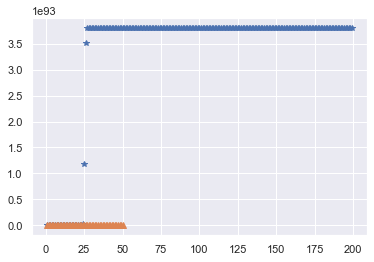

In [513]:
y_pred_36059 = model_risk_density_weighted_check2.predict(
    t = range(1,200),
    group_name=36059
)
y_pred_36059_mov = model_risk_moving_avg_density_weighted_check2.predict(
    t = range(1,200),
    group_name=36059
)
plt.plot(np.array(range(1,200)), y_pred_36059_mov, '*')
# plt.plot(np.array(range(1,200)), y_pred_36061, '.')
plt.plot(range(1,51), train[train.FIPS == 36059].confirmed_cases, '^')
# plt.plot(range(1,51), train[train.FIPS == 36061].confirmed_cases, '-')

In [16]:
#baseline model performance
cases = pd.read_csv('full_data_with_hospital_MA_v0517_v2.csv', index_col = "date", parse_dates=True, usecols=["date","COUNTY","FIPS","STATE","confirmed_cases","num_hospital", "num_beds"])
date_int_map = dict(zip(np.unique(cases.index), range(1,1+len(np.unique(cases.index)))))
cases['time'] = cases.index.map(date_int_map)
cases = cases[(cases.FIPS >= 36000)&(cases.FIPS < 37000)]
cases = cases[cases.STATE == 'NY']
cases

FIPS  confirmed_cases       COUNTY STATE  num_hospital  num_beds  \
date                                                                            
2020-03-15  36001                7       ALBANY    NY           7.0    -617.0   
2020-03-15  36003                0     ALLEGANY    NY           2.0      76.0   
2020-03-15  36005                0        BRONX    NY          14.0   -1535.0   
2020-03-15  36007                1       BROOME    NY           4.0    -257.0   
2020-03-15  36009                0  CATTARAUGUS    NY           2.0     248.0   
...           ...              ...          ...   ...           ...       ...   
2020-05-10  36113              207       WARREN    NY           1.0     410.0   
2020-05-10  36117               80        WAYNE    NY           1.0     120.0   
2020-05-10  36119            31294  WESTCHESTER    NY          18.0    2236.0   
2020-05-10  36121               77      WYOMING    NY           1.0      62.0   
2020-05-10  36123               21        YATES    NY           1.0      25.0   

            time  
date              
2020-03-15     1  
2020-03-15     1  
2020-03-15     1  
2020-03-15     1  
2020-03-15     1  
...          ...  
2020-05-10    57  
2020-05-10    57  
2020-05-10    57  
2020-05-10    57  
2020-05-10    57  

[3192 rows x 7 columns]

In [17]:
cases_train = cases[cases.time <= 46]
cases_train = cases_train.drop_duplicates()
cases_train = cases_train[cases_train.confirmed_cases != 0]
cases_train

FIPS  confirmed_cases       COUNTY STATE  num_hospital  num_beds  \
date                                                                            
2020-03-15  36001                7       ALBANY    NY           7.0    -617.0   
2020-03-15  36007                1       BROOME    NY           4.0    -257.0   
2020-03-15  36025                1     DELAWARE    NY           4.0      67.0   
2020-03-15  36027                4     DUTCHESS    NY           4.0    -323.0   
2020-03-15  36029                3         ERIE    NY          15.0   -1646.0   
...           ...              ...          ...   ...           ...       ...   
2020-04-29  36113              152       WARREN    NY           1.0     410.0   
2020-04-29  36117               70        WAYNE    NY           1.0     120.0   
2020-04-29  36119            28626  WESTCHESTER    NY          18.0    2236.0   
2020-04-29  36121               65      WYOMING    NY           1.0      62.0   
2020-04-29  36123               17        YATES    NY           1.0      25.0   

            time  
date              
2020-03-15     1  
2020-03-15     1  
2020-03-15     1  
2020-03-15     1  
2020-03-15     1  
...          ...  
2020-04-29    46  
2020-04-29    46  
2020-04-29    46  
2020-04-29    46  
2020-04-29    46  

[2183 rows x 7 columns]

In [18]:
cases_test = cases[(cases.time > 46) & (cases.time <= 56)]
cases_test = cases_test[cases_test.confirmed_cases != 0]

In [19]:
cases_dict = {}
cases = cases[cases.confirmed_cases != 0]
for county in cases.FIPS.unique():
    if isinstance(county, np.int64): #(county, str)
        cases_dict[county] = cases[cases.FIPS==county]

In [20]:
cases_train_dict = {}
for county in cases_train.FIPS.unique():
    if isinstance(county, np.int64): #(county, str)
        cases_train_dict[county] = cases_train[cases_train.FIPS==county]

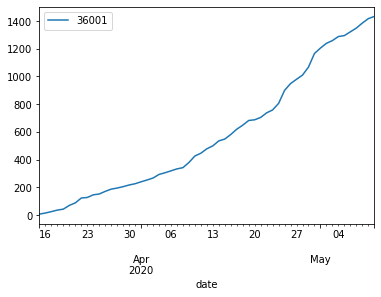

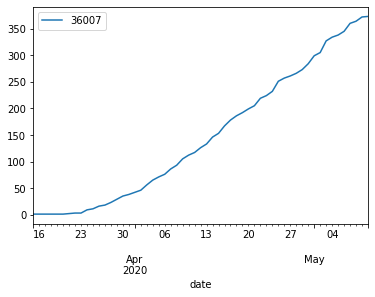

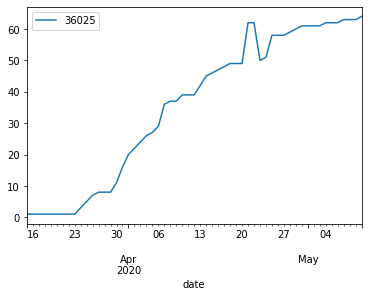

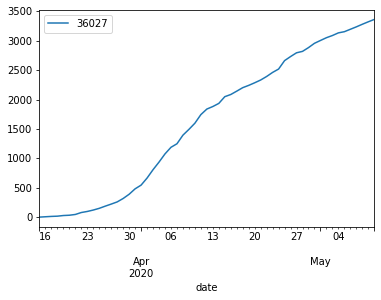

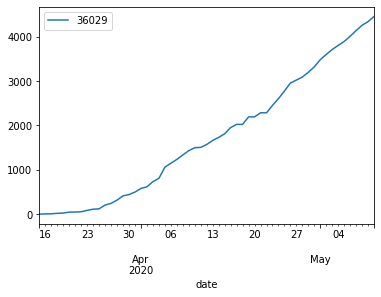

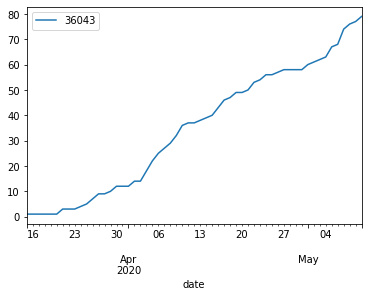

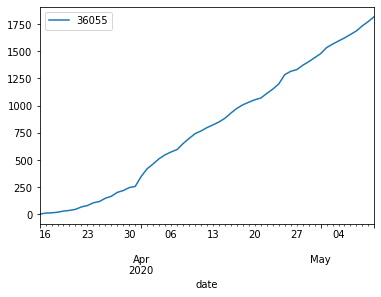

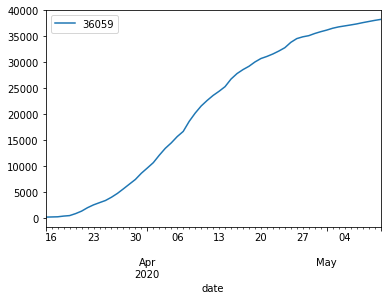

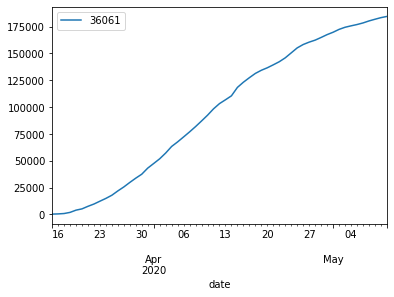

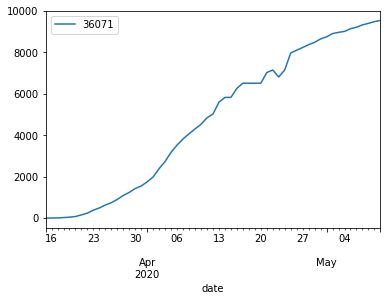

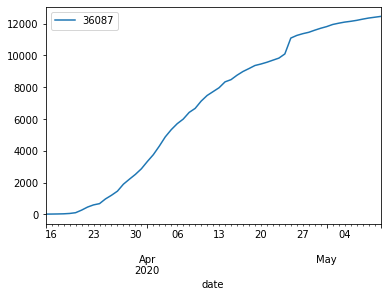

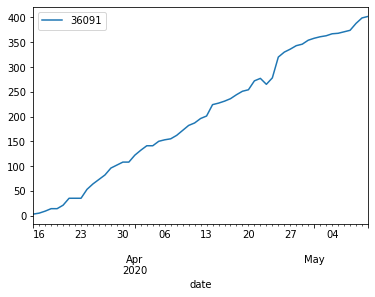

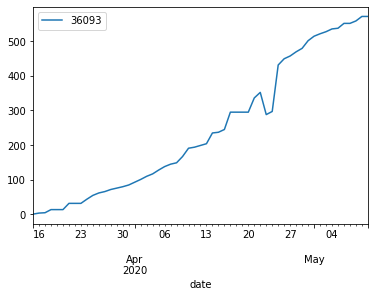

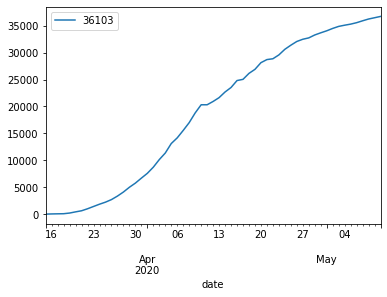

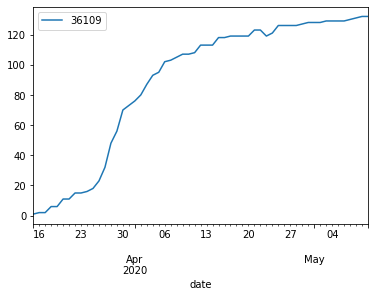

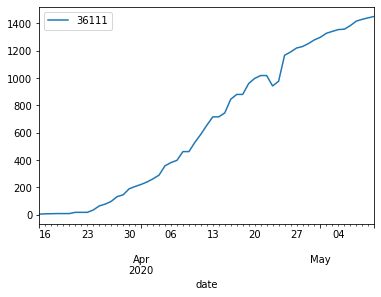

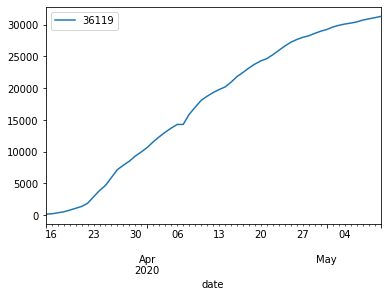

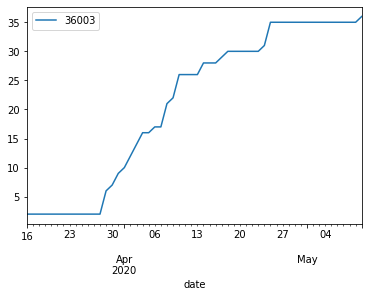

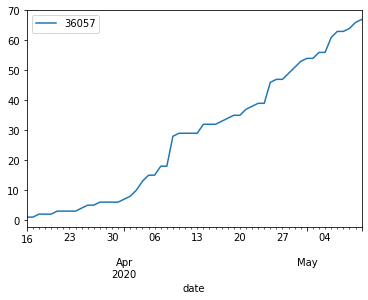

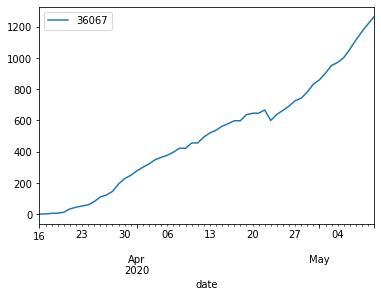

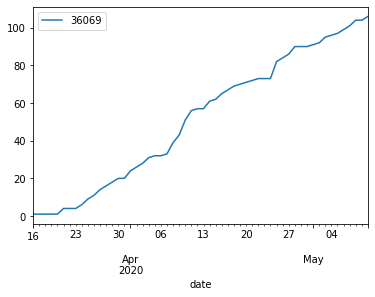

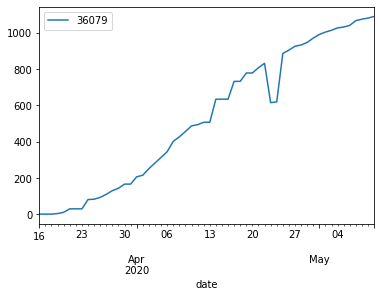

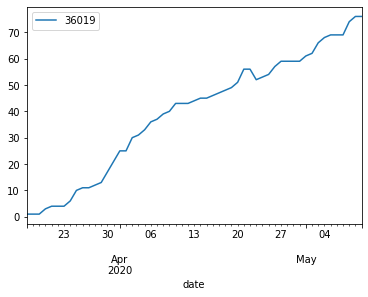

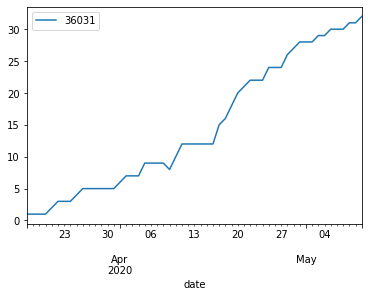

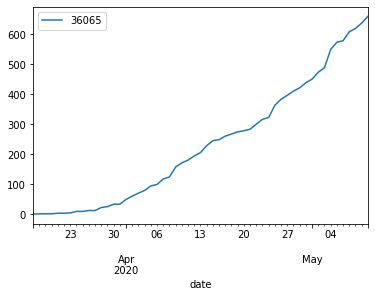

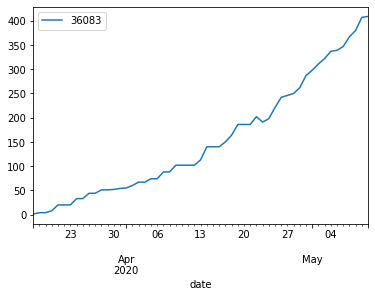

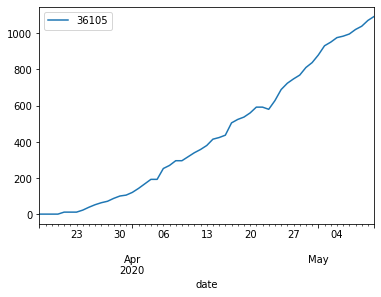

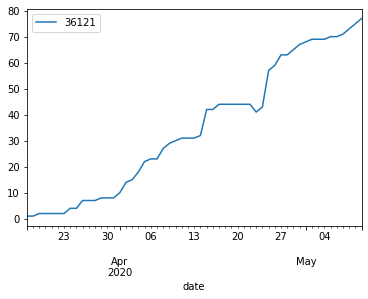

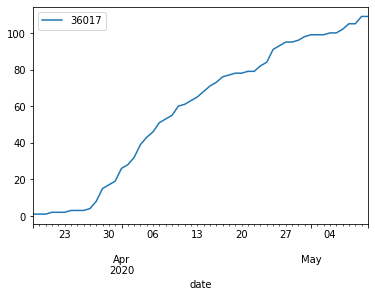

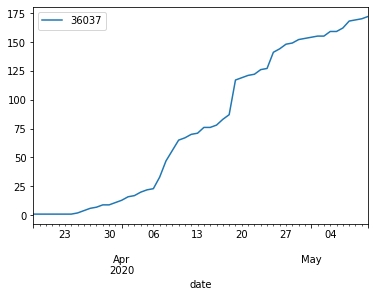

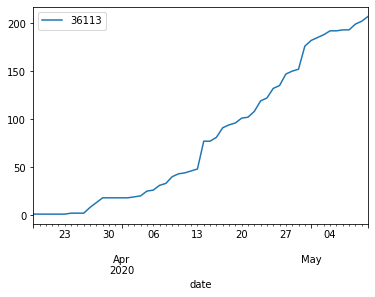

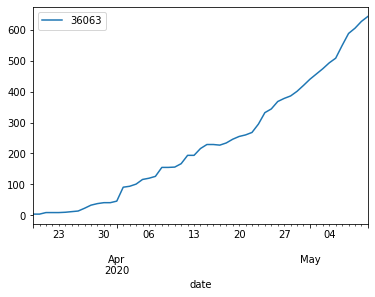

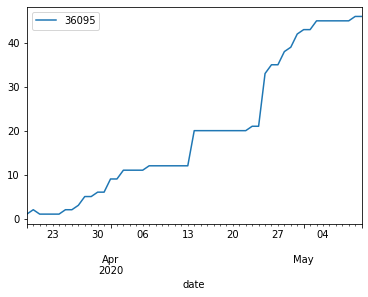

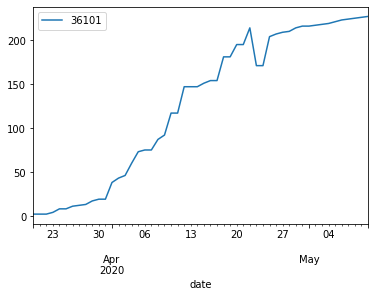

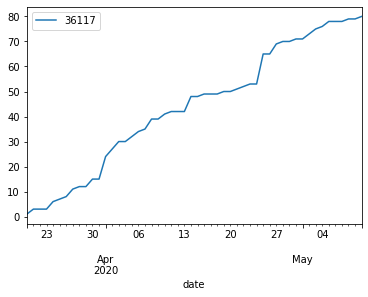

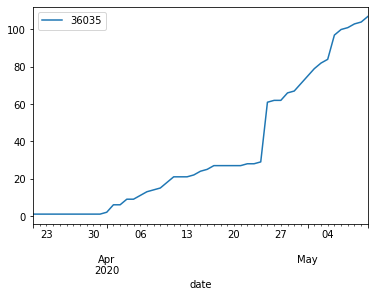

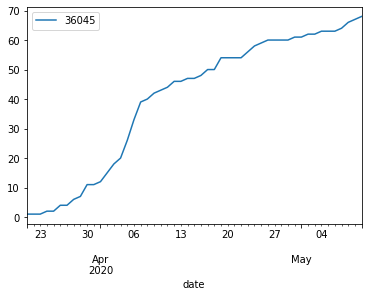

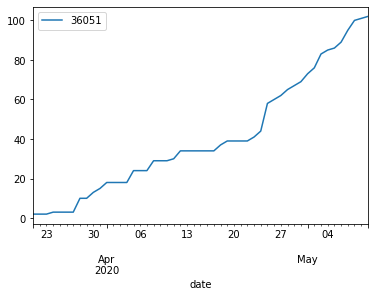

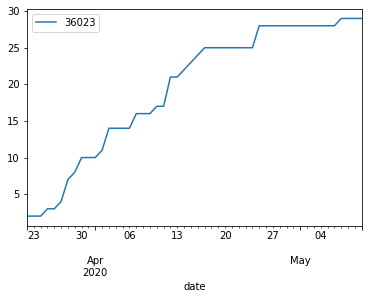

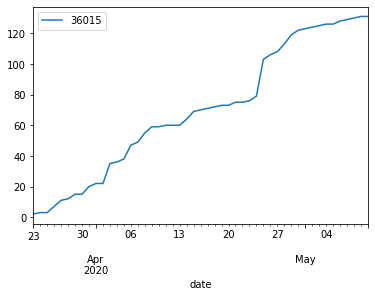

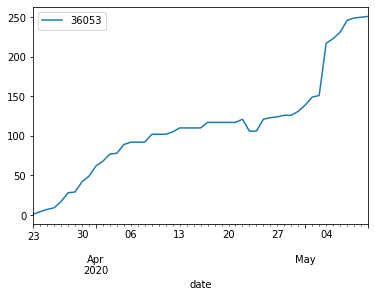

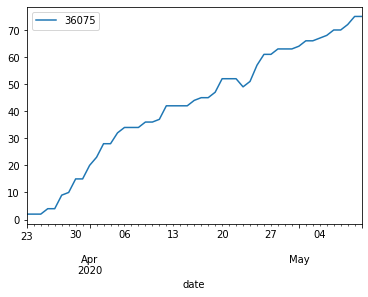

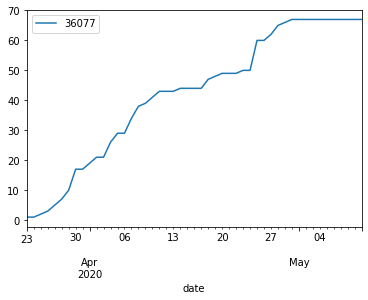

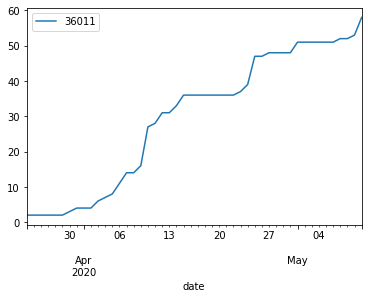

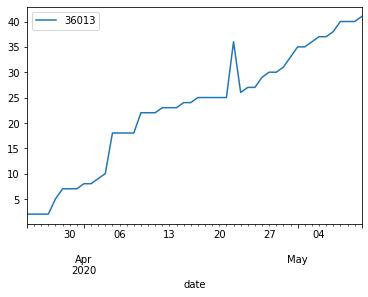

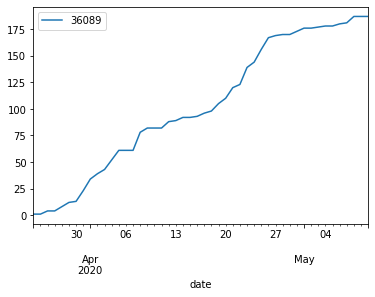

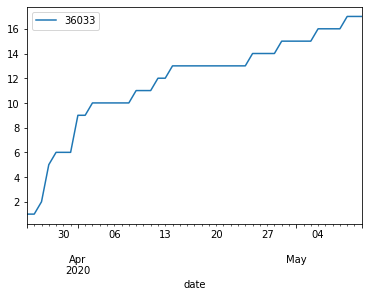

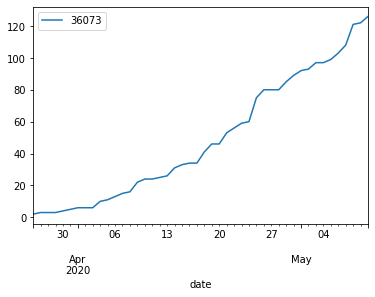

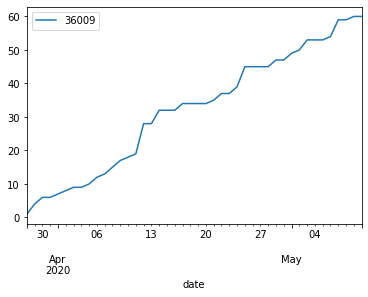

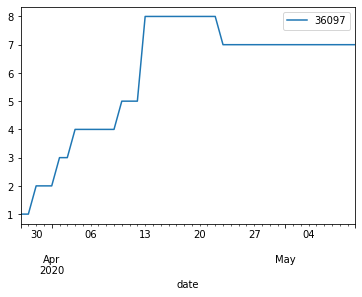

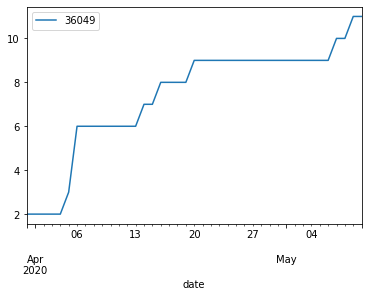

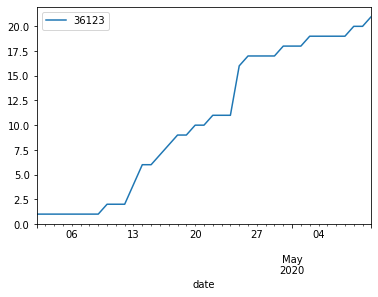

In [21]:
for key, value in cases_dict.items():
    value['confirmed_cases'].plot(label=key)
    plt.legend()
    plt.show()

In [22]:
def my_logistic(t, a, b, c):
    return c / (1 + a * np.exp(-b*t))

p0 = np.random.exponential(size=3)
p0
bounds = (0, [100000., 5., 1000000000.])

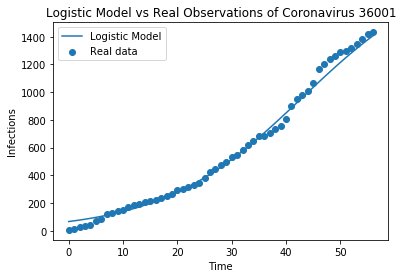

MSE of  36001 in test set is:  4573.15167459677 



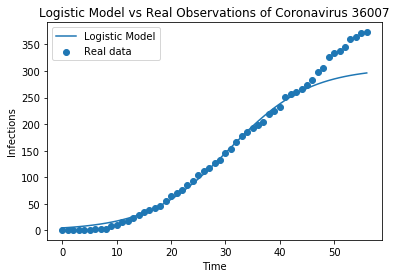

MSE of  36007 in test set is:  2691.0437940294223 



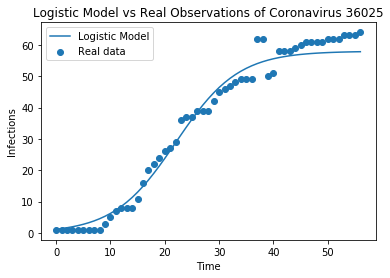

MSE of  36025 in test set is:  19.647169639740913 



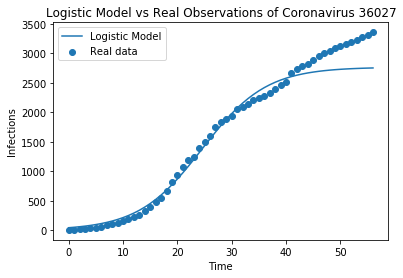

MSE of  36027 in test set is:  177663.5566893652 



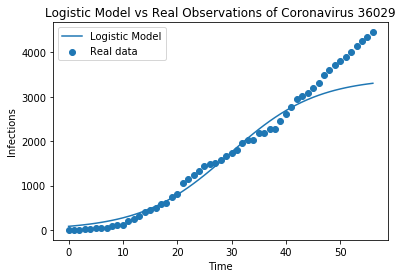

MSE of  36029 in test set is:  512176.25573988195 



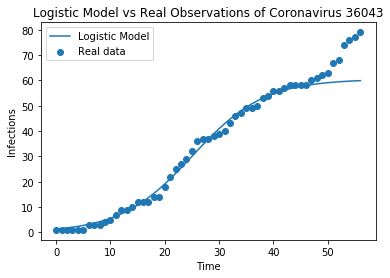

MSE of  36043 in test set is:  93.3783758546709 



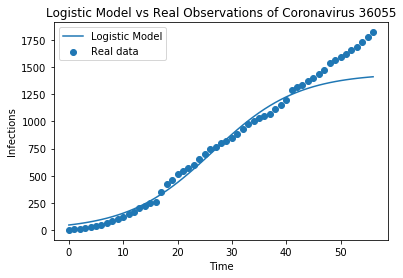

MSE of  36055 in test set is:  60622.09876785567 



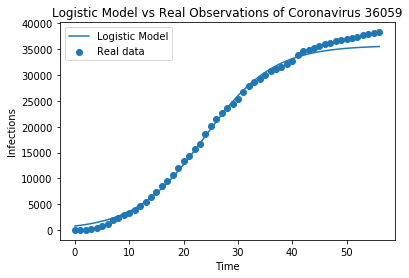

MSE of  36059 in test set is:  3851514.2576564653 



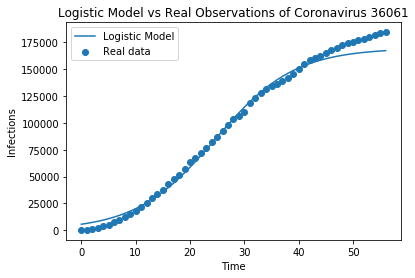

MSE of  36061 in test set is:  142828851.94457895 



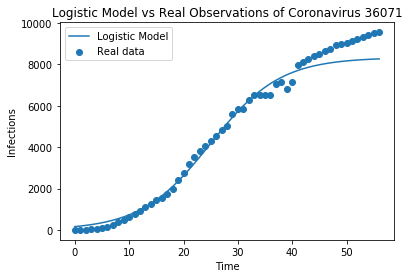

MSE of  36071 in test set is:  902223.6154712911 



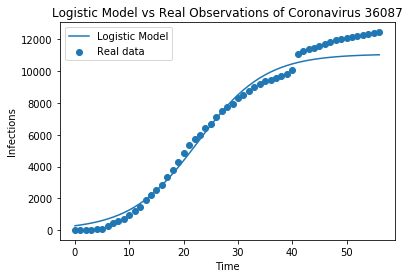

MSE of  36087 in test set is:  1336798.4272788898 



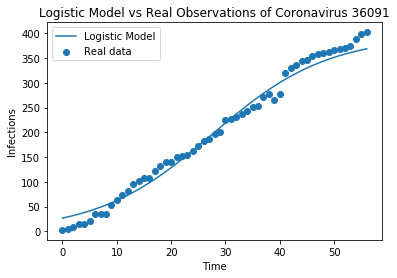

MSE of  36091 in test set is:  369.91915930640107 



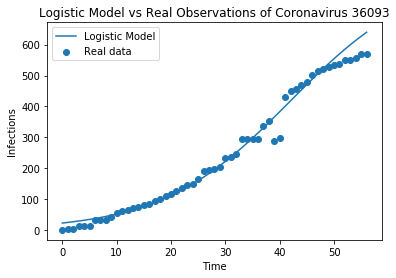

MSE of  36093 in test set is:  1153.890892654961 



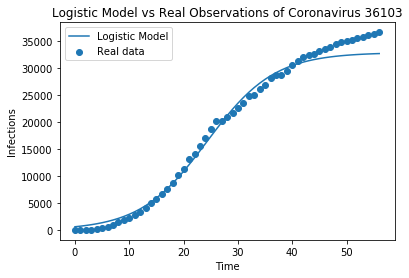

MSE of  36103 in test set is:  7854784.5197370555 



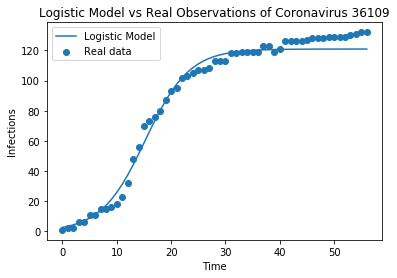

MSE of  36109 in test set is:  72.96768680754393 



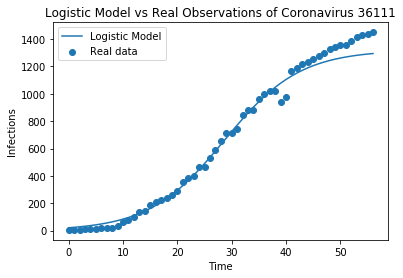

MSE of  36111 in test set is:  11132.787017632774 



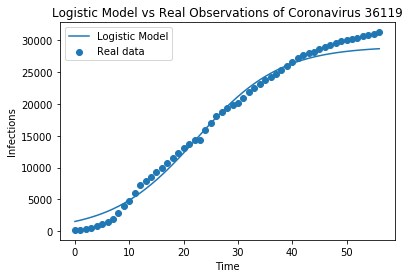

MSE of  36119 in test set is:  3523564.4786639386 



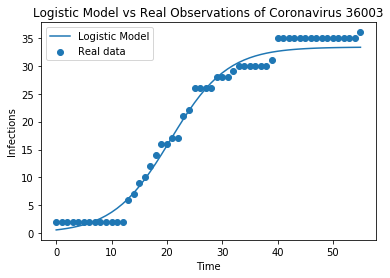

MSE of  36003 in test set is:  3.1743526909813813 



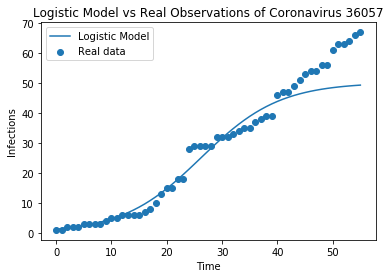

MSE of  36057 in test set is:  130.94938867820957 



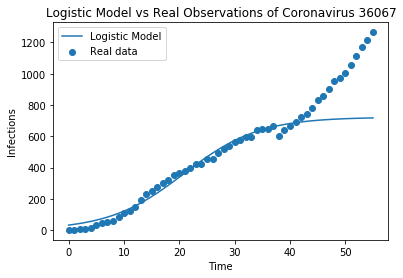

MSE of  36067 in test set is:  102481.45181307002 



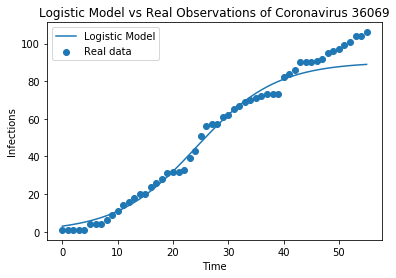

MSE of  36069 in test set is:  105.68779919247194 



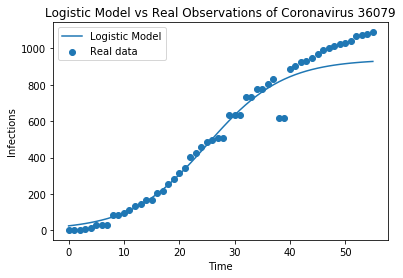

MSE of  36079 in test set is:  14298.729059949921 



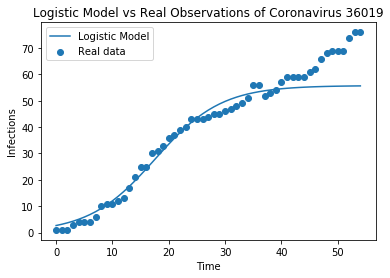

MSE of  36019 in test set is:  165.9354675274863 



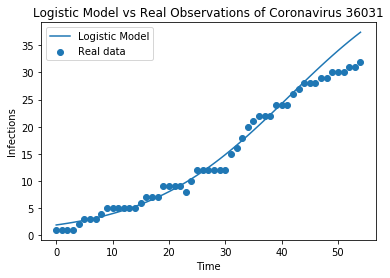

MSE of  36031 in test set is:  12.396315769792954 



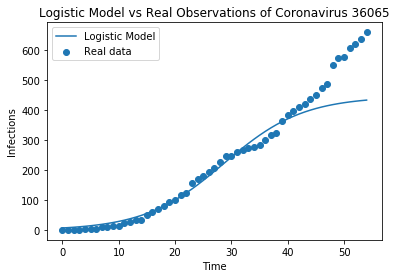

MSE of  36065 in test set is:  18843.598786991683 



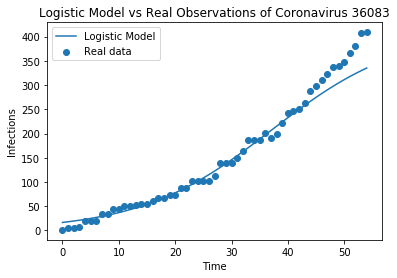

MSE of  36083 in test set is:  1848.3225330392875 



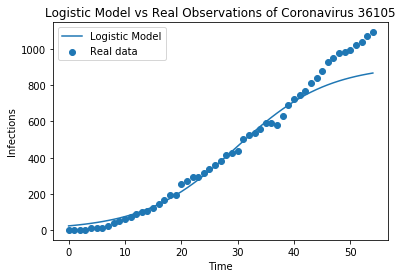

MSE of  36105 in test set is:  22316.919687836467 



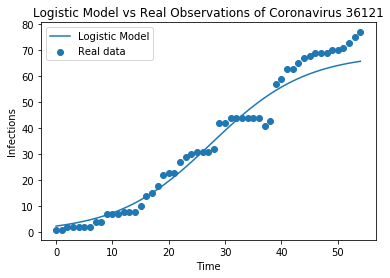

MSE of  36121 in test set is:  48.96916257150887 



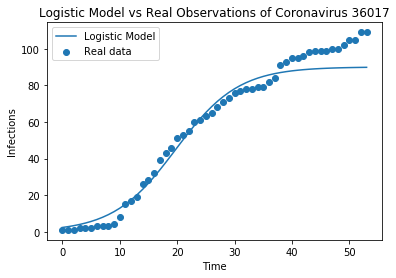

MSE of  36017 in test set is:  158.3630780029474 



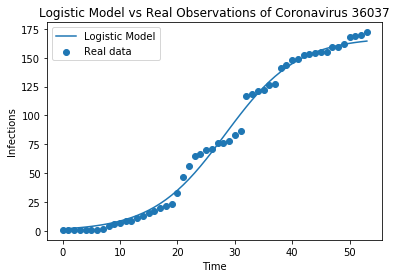

MSE of  36037 in test set is:  11.826222445044 



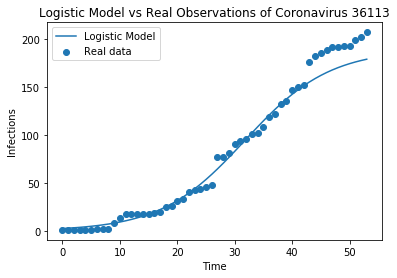

MSE of  36113 in test set is:  501.178838281577 



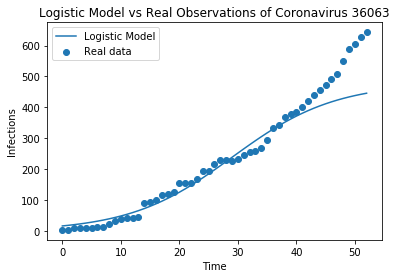

MSE of  36063 in test set is:  12210.61273362026 



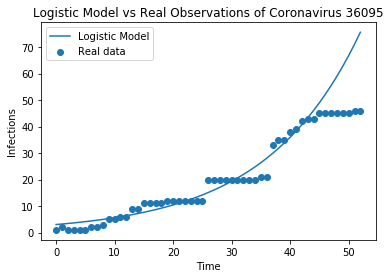

MSE of  36095 in test set is:  180.53478492110762 



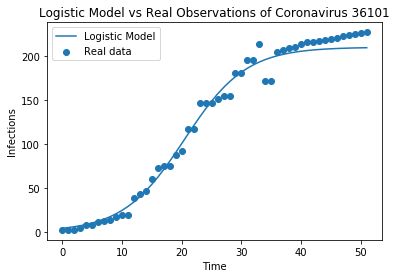

MSE of  36101 in test set is:  161.0367413969581 



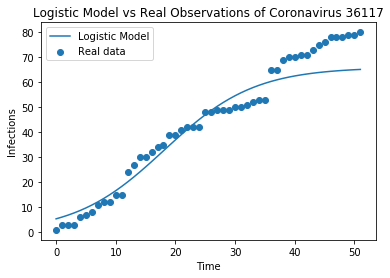

MSE of  36117 in test set is:  141.04829073187494 



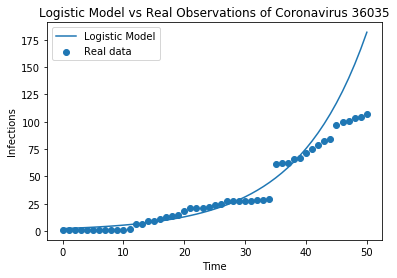

MSE of  36035 in test set is:  1002.4521461504648 



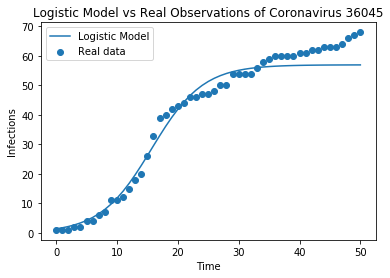

MSE of  36045 in test set is:  43.3619146398037 



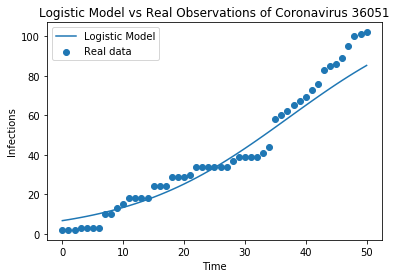

MSE of  36051 in test set is:  147.62726767576996 



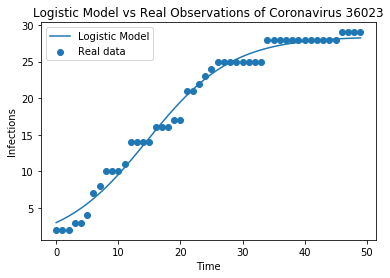

MSE of  36023 in test set is:  0.22672750838159256 



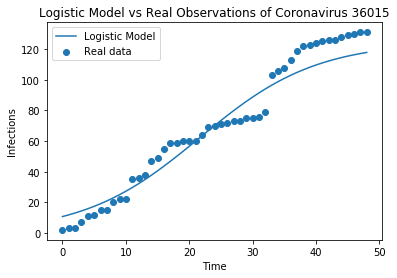

MSE of  36015 in test set is:  195.83520874267901 



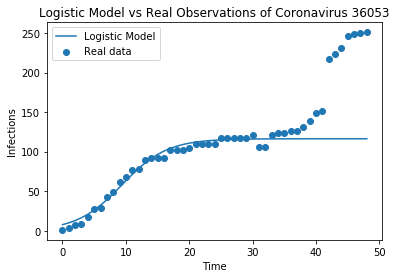

MSE of  36053 in test set is:  9004.04313385209 



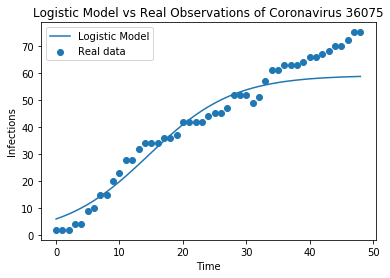

MSE of  36075 in test set is:  109.65479493059638 



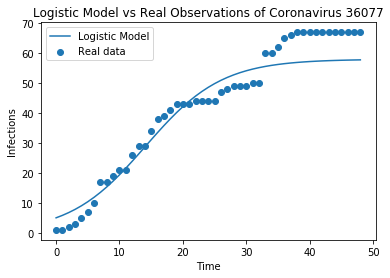

MSE of  36077 in test set is:  91.75403615813855 



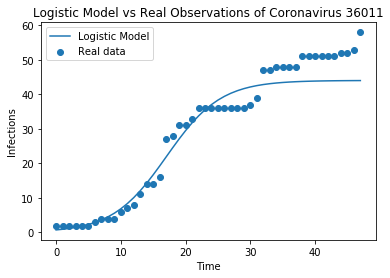

MSE of  36011 in test set is:  53.365066184875545 



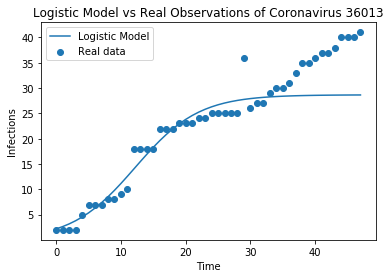

MSE of  36013 in test set is:  77.8417780449237 



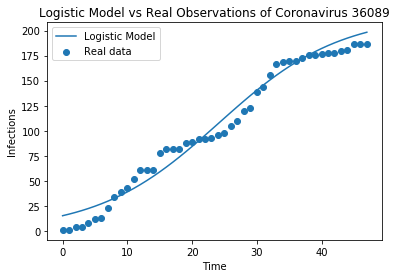

MSE of  36089 in test set is:  56.08033489886882 



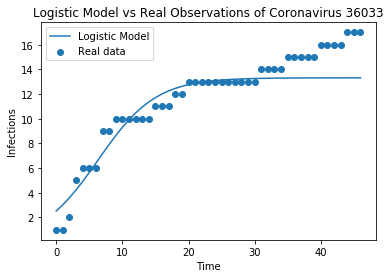

MSE of  36033 in test set is:  6.7384607565472905 



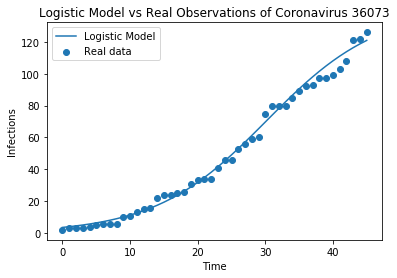

MSE of  36073 in test set is:  32.85652975090674 



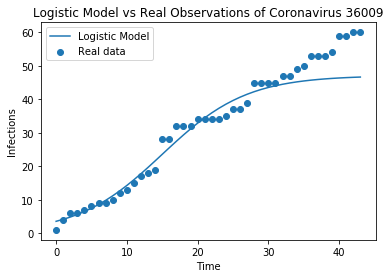

MSE of  36009 in test set is:  74.94016026960749 



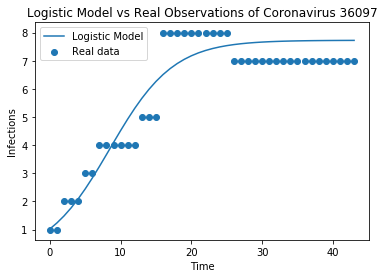

MSE of  36097 in test set is:  0.5087386441498218 



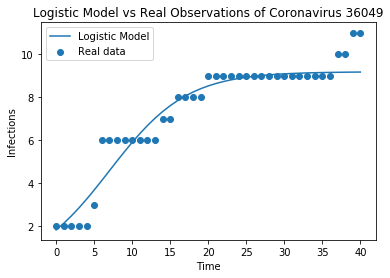

MSE of  36049 in test set is:  0.49072396924543077 



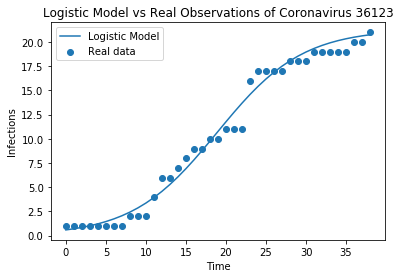

MSE of  36123 in test set is:  0.6426937161683036 



In [25]:
county = []
mse = []

prediction = []
confirmed_cases = []
date = []
FIPS = []

for key, value in cases_dict.items():
    (a,b,c),cov = optim.curve_fit(my_logistic, list(range(len(cases_train_dict[key]['confirmed_cases']))), cases_train_dict[key]['confirmed_cases'], bounds=bounds, p0=p0)
    plt.scatter(list(range(len(cases_dict[key]['confirmed_cases']))), cases_dict[key]['confirmed_cases'])
    tmp = np.array(range(len(cases_dict[key]['confirmed_cases'])))
    y_pred_all =  c / (1 + a * np.exp(-b*tmp))
    plt.plot(tmp, y_pred_all)
    plt.title('Logistic Model vs Real Observations of Coronavirus '+ str(key))
    plt.legend([ 'Logistic Model', 'Real data'])
    plt.xlabel('Time')
    plt.ylabel('Infections')
    plt.show()

    pred_date = np.array(range(len(cases_train_dict[key]['confirmed_cases']),len(cases_train_dict[key]['confirmed_cases'])+len(cases_test[cases_test.FIPS == key])))
    y_pred_test = c / (1 + a * np.exp(-b*pred_date))
    y_true = np.array(cases_test[cases_test.FIPS == key].confirmed_cases)

    print('MSE of ',key,'in test set is: ',np.mean((y_pred_test - y_true) ** 2), '\n' )
    
    county.append(key)
    mse.append(np.mean((y_pred_test - y_true) ** 2))
    
    prediction.extend(y_pred_all)
    date.extend(cases_dict[key].index)
    confirmed_cases.extend(cases_dict[key]['confirmed_cases'])
    FIPS.extend([key]*len(y_pred_all))
    
    

In [26]:
county_mse = pd.DataFrame({'county':county, 'MSE':mse})
county_mse = county_mse.sort_values(by=['county'])
county_mse.to_csv('baseline_mse.csv')

In [27]:
baseline_pred = pd.DataFrame({'FIPS':FIPS, 'date':date, 'prediction':prediction, 'confirmed_cases':confirmed_cases})
baseline_pred.to_csv('baseline_prediction.csv')

In [2]:
#compared with baseline model performance
nyc_summary=pd.DataFrame()
bk_summary=pd.DataFrame()

In [3]:
expit_pred = pd.read_csv('PredictedConfirmedCases_Model_risk_density_weighted_expit.csv')
gaussian_cdf_pred = pd.read_csv('PredictedConfirmedCases_Model_risk_density_weighted_gaussian_cdf.csv')
ln_gaussian_cdf_pred = pd.read_csv('PredictedConfirmedCases_Model_risk_density_weighted_ln_gaussian_cdf.csv')
baseline_pred = pd.read_csv('baseline_prediction.csv')

In [4]:
nyc_summary['date'] = baseline_pred[baseline_pred.FIPS == 36061]['date'].values
nyc_summary['confirmed_cases'] = baseline_pred[baseline_pred.FIPS == 36061]['confirmed_cases'].values
nyc_summary['baseline_pred'] = baseline_pred[baseline_pred.FIPS == 36061]['prediction'].values
nyc_summary['expit_pred'] = expit_pred[expit_pred.FIPS == 36061]['predicted'].values
nyc_summary['gaussian_cdf_pred'] = gaussian_cdf_pred[gaussian_cdf_pred.FIPS == 36061]['predicted'].values
nyc_summary['ln_gaussian_cdf_pred'] = ln_gaussian_cdf_pred[ln_gaussian_cdf_pred.FIPS == 36061]['predicted'].values

In [11]:
nyc_summary.date[1]

'2020-03-16'

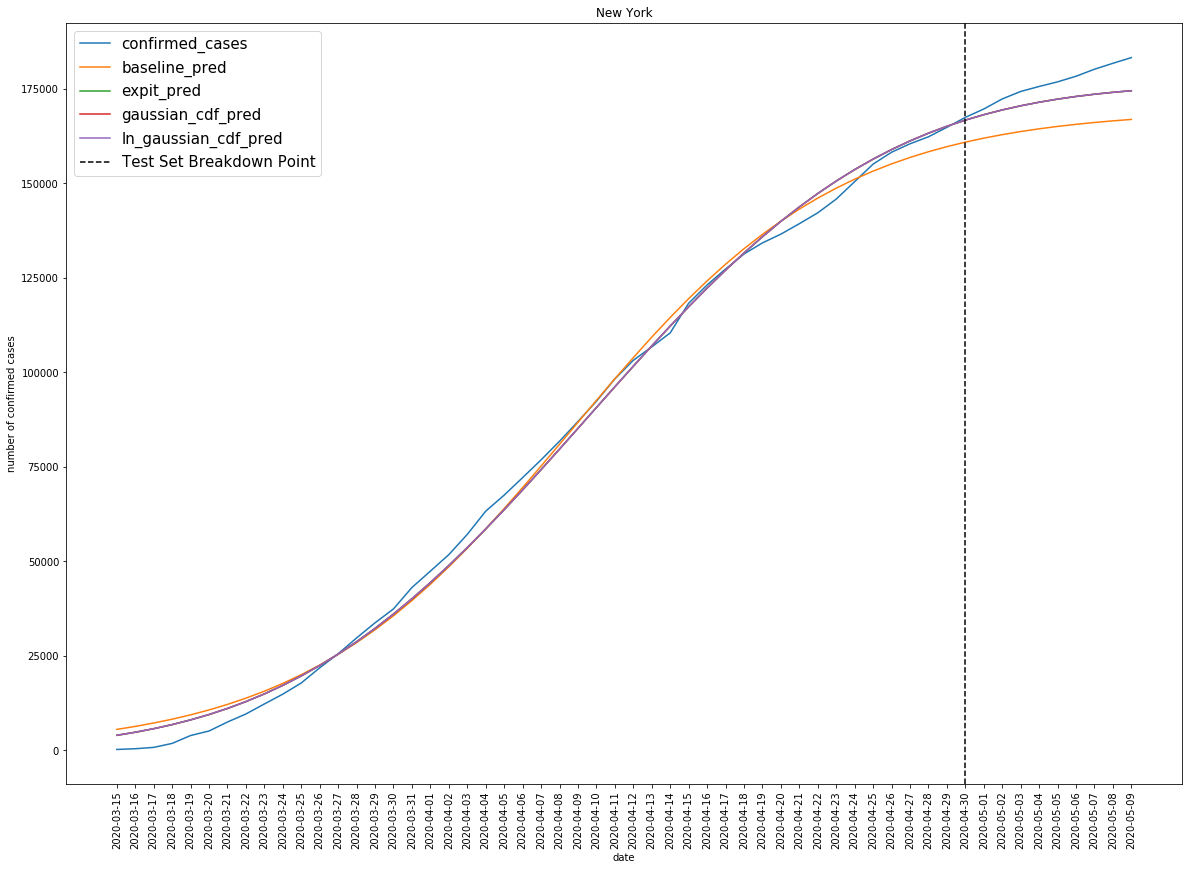

In [13]:
fig, ax2 = plt.subplots(nrows = 1, ncols = 1, figsize = (20,14))
plt.plot(range(len(nyc_summary.confirmed_cases)), nyc_summary.confirmed_cases,  label='confirmed_cases')
plt.plot(range(len(nyc_summary.confirmed_cases)), nyc_summary.baseline_pred,  label='baseline_pred')
plt.plot(range(len(nyc_summary.confirmed_cases)), nyc_summary.expit_pred,  label='expit_pred')
plt.plot(range(len(nyc_summary.confirmed_cases)), nyc_summary.gaussian_cdf_pred,  label='gaussian_cdf_pred')
plt.plot(range(len(nyc_summary.confirmed_cases)), nyc_summary.ln_gaussian_cdf_pred,  label='ln_gaussian_cdf_pred')
ax2.axvline(range(len(nyc_summary.confirmed_cases))[46], label = 'Test Set Breakdown Point', ls = '--',color = 'black')
plt.xticks(range(len(nyc_summary.confirmed_cases)),nyc_summary.date)
plt.xticks(rotation=90)
plt.ylabel('number of confirmed cases')
plt.xlabel('date')
plt.title('New York')
plt.legend(prop={'size': 15}) 
plt.savefig('New York comparison.png')

In [14]:
bk_summary['date'] = baseline_pred[baseline_pred.FIPS == 36079]['date'].values
bk_summary['confirmed_cases'] = baseline_pred[baseline_pred.FIPS == 36079]['confirmed_cases'].values
bk_summary['baseline_pred'] = baseline_pred[baseline_pred.FIPS == 36079]['prediction'].values
bk_summary['expit_pred'] = expit_pred[expit_pred.FIPS == 36079]['predicted'].values[1:]
bk_summary['gaussian_cdf_pred'] = gaussian_cdf_pred[gaussian_cdf_pred.FIPS == 36079]['predicted'].values[1:]
bk_summary['ln_gaussian_cdf_pred'] = ln_gaussian_cdf_pred[ln_gaussian_cdf_pred.FIPS == 36079]['predicted'].values[1:]

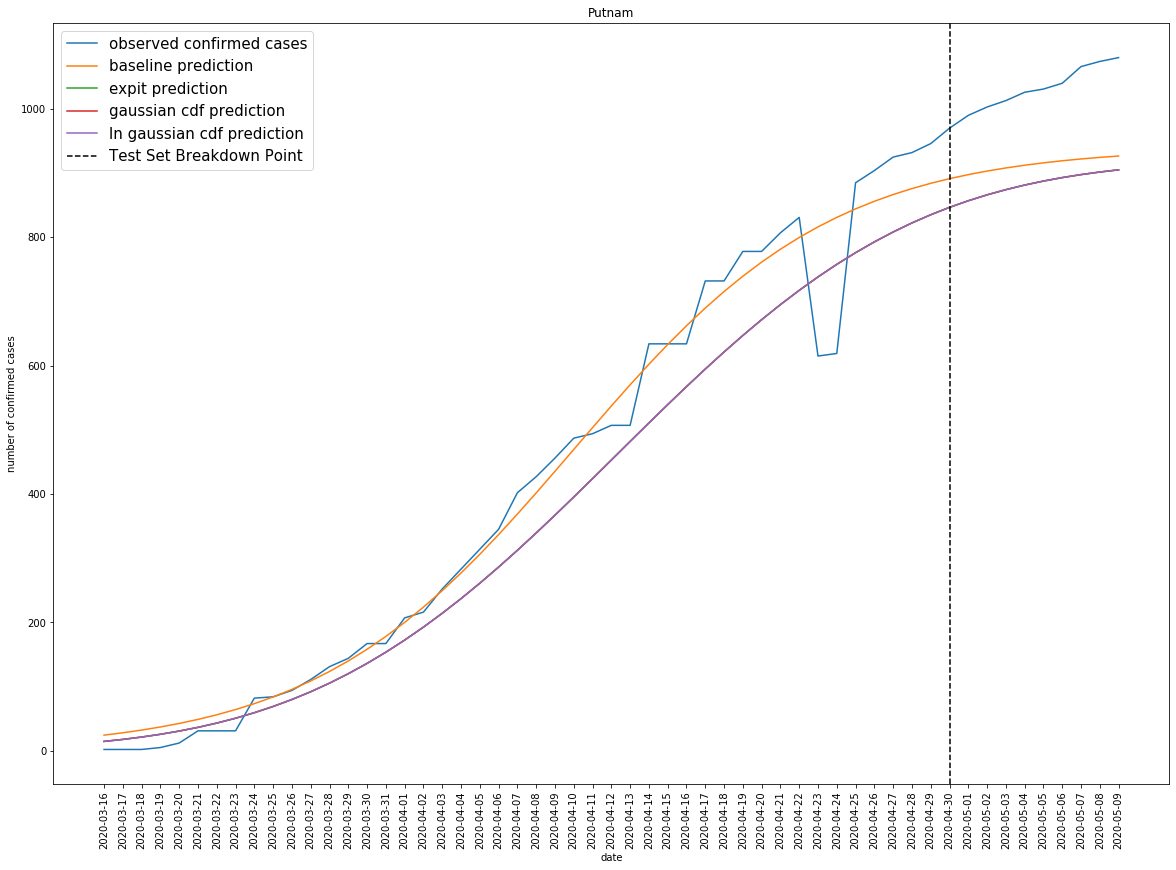

In [15]:
fig, ax2 = plt.subplots(nrows = 1, ncols = 1, figsize = (20,14))
plt.plot(range(len(bk_summary.date)), bk_summary.confirmed_cases,  label='observed confirmed cases')
plt.plot(range(len(bk_summary.date)), bk_summary.baseline_pred,  label='baseline prediction')
plt.plot(range(len(bk_summary.date)), bk_summary.expit_pred,  label='expit prediction')
plt.plot(range(len(bk_summary.date)), bk_summary.gaussian_cdf_pred,  label='gaussian cdf prediction')
plt.plot(range(len(bk_summary.date)), bk_summary.ln_gaussian_cdf_pred,  label='ln gaussian cdf prediction')
ax2.axvline(range(len(bk_summary.date))[45], label = 'Test Set Breakdown Point', ls = '--',color = 'black')
plt.xticks(range(len(bk_summary.confirmed_cases)),bk_summary.date)
plt.xticks(rotation=90)
plt.ylabel('number of confirmed cases')
plt.xlabel('date')
plt.title('Putnam')
plt.legend(prop={'size': 15}) 
plt.savefig('Putnam comparison.png')